Sara Mancini (66458A) & Betül Gül (V13000)
<h1> PDAC Data Integration using Miss-SNF </h1>
Scientific Visualization 2025/26

### Install miss-snf

In [ ]:
install.packages("devtools")
library(devtools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: usethis



In [ ]:
system("git clone https://github.com/AnacletoLAB/missSNF.git")

In [ ]:
install("./missSNF")

BiocGenerics (NA -> 0.56.0  ) [CRAN]
BH           (NA -> 1.87.0-1) [CRAN]
statmod      (NA -> 1.5.1   ) [CRAN]
RBGL         (NA -> 1.86.0  ) [CRAN]
graph        (NA -> 1.88.0  ) [CRAN]
limma        (NA -> 3.66.0  ) [CRAN]
prettyGraphs (NA -> 2.2.0   ) [CRAN]
PerfMeas     (NA -> 1.2.5   ) [CRAN]
NetPreProc   (NA -> 1.2     ) [CRAN]
alluvial     (NA -> 0.1-2   ) [CRAN]
ExPosition   (NA -> 2.11.0  ) [CRAN]
RANKS        (NA -> 1.1     ) [CRAN]
NetInt       (NA -> 1.0.1   ) [CRAN]
SNFtool      (NA -> 2.3.1   ) [CRAN]


Installing 14 packages: BiocGenerics, BH, statmod, RBGL, graph, limma, prettyGraphs, PerfMeas, NetPreProc, alluvial, ExPosition, RANKS, NetInt, SNFtool

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/content/missSNF/DESCRIPTION’ ... OK
* preparing ‘missSNF’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘missSNF_1.0.0.tar.gz’

Running /usr/lib/R/bin/R CMD INSTALL /tmp/Rtmp17Uf4O/missSNF_1.0.0.tar.gz \
  --install-tests 
* installing to library ‘/usr/local/lib/R/site-library’
* installing *source* package ‘missSNF’ ...
** this is package ‘missSNF’ version ‘1.0.0’
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DO

In [ ]:
library(missSNF)

Package 'missSNF' version 1.0.0



#### other imports

In [ ]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("BiocManager")
BiocManager::install("ComplexHeatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'ComplexHeatmap'

also installing the dependencies ‘shape’, ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘iterators’, ‘circlize’, ‘GetoptLong’, ‘colorspace’, ‘clue’, ‘GlobalOptions’, ‘png’, ‘IRanges’, ‘matrixStats’, ‘foreach’, ‘doParallel’


Old packages: 'broom', 'htmltools', 'httr2', 'isoband', 'selectr', 'shiny',
  'testthat', 'vroom', 'xml2', 'yaml'



In [ ]:
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [ ]:
install.packages("igraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Data upload

Unzipping (PDAC_data.zip should be uploaded in the dir before this)

In [ ]:
# path to uploaded zip
zip_file <- "PDAC_data.zip"

# create folder for unzipping
dir.create("unzip_data", showWarnings = FALSE)

# unzip all files into the folder
unzip(zip_file, exdir = "unzip_data")

# check what got extracted
list.files("unzip_data")

[1] "PDAC_data"

Selecting only the non-clinical datasets & transposing all of them so that rows: patients, cols: features

In [ ]:
data_folder <- "unzip_data/PDAC_data/"
fs <- list.files(data_folder, pattern="\\.csv$", full.names=TRUE)

# read all files, but filter only non-clinical for Mall
read_num_csv <- function(f){
  df <- read.csv(f, row.names=1, check.names=FALSE, stringsAsFactors=FALSE)
  df[] <- lapply(df, function(col) suppressWarnings(as.numeric(col)))
  as.matrix(df)
}

all_data <- setNames(lapply(fs, read_num_csv), basename(fs))

# transpose rows/cols for missSNF
Mall <- lapply(all_data[!grepl("clinical", names(all_data), ignore.case=TRUE)], t)

Docs Vis Overall

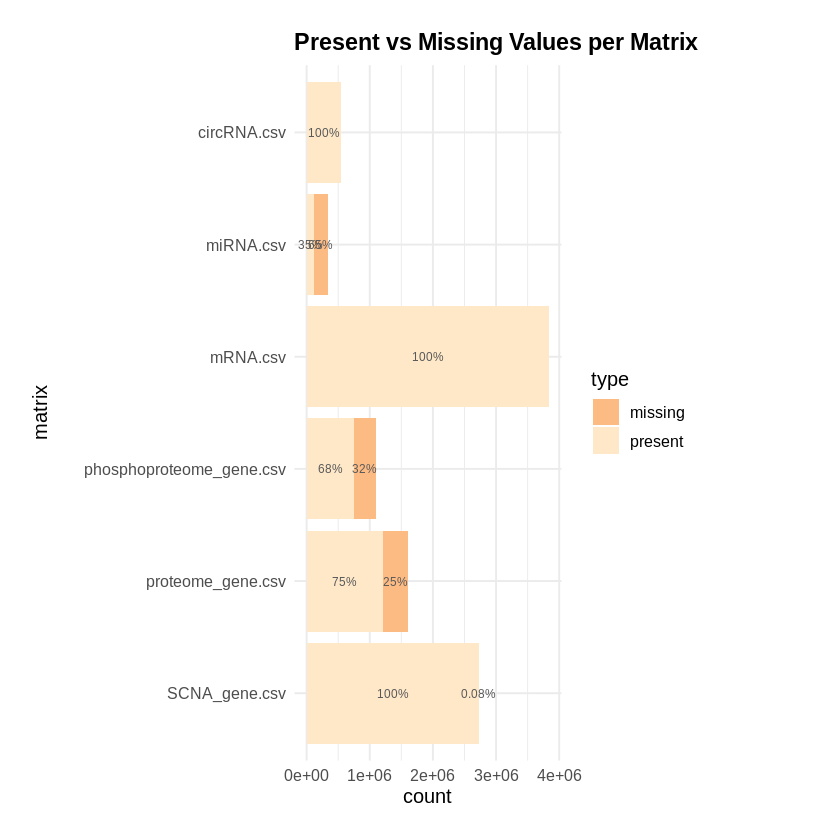

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)

plot_presence_missing <- function(Mall, outfile = "presence_missing.png") {

  df_list <- lapply(names(Mall), function(name){
    mat <- Mall[[name]]
    total_vals <- prod(dim(mat))
    missing_vals <- sum(is.na(mat))
    present_vals <- total_vals - missing_vals

    data.frame(
      matrix = name,
      present = present_vals,
      missing = missing_vals
    )
  })

  df <- bind_rows(df_list)

  df_long <- df %>%
    pivot_longer(cols = c("present", "missing"),
                 names_to = "type",
                 values_to = "count")

  # custom percent labels
  df_long <- df_long %>%
    group_by(matrix) %>%
    mutate(pct = count / sum(count),
           label = case_when(
             pct == 0 ~ "",
             pct < 0.01 & pct > 0 ~ sprintf("%.2f%%", pct*100),
             TRUE ~ scales::percent(pct, accuracy = 1)
           ))

  # reverse the order of matrices so first item is top
  df_long$matrix <- factor(df_long$matrix, levels = rev(names(Mall)))

  p <- ggplot(df_long, aes(x = count, y = matrix, fill = type)) +
    geom_col(position = "stack") +
    geom_text(
      aes(label = label),
      position = position_stack(vjust = 0.5),
      color = "gray35",
      size = 2.5
    ) +
    scale_fill_manual(values = c(
      present = "#fee8c8",
      missing = "#fdbb84"
    )) +
    ggtitle("Present vs Missing Values per Matrix") +
    theme_minimal(base_size = 12) +
    theme(
      legend.position = "right",
      plot.margin = margin(20, 80, 20, 20),
      plot.title = element_text(size = 14, face = "bold")
    )

  ggsave(
    filename = outfile,
    plot = p,
    width = 12,
    height = 4,
    dpi = 300
  )

  return(p)
}

plot_presence_missing(Mall)

### Missing pts analysis

get.miss.pts

In [ ]:
library(missSNF)
missing_patients <- get.miss.pts(Mall, perc.na = 0.2, miss.symbols = NULL)

Heatmap of missing values qty per patient per document

In [ ]:
library(ComplexHeatmap)
library(circlize)
library(grid)

miss_count <- sapply(Mall, function(mat) rowSums(is.na(mat)))
mat <- miss_count

if(is.null(rownames(mat))) rownames(mat) <- paste0("Patient_", seq_len(nrow(mat)))
if(is.null(colnames(mat))) colnames(mat) <- paste0("Dataset_", seq_len(ncol(mat)))

col_fun <- colorRamp2(
  breaks = c(min(mat, na.rm = TRUE), median(mat, na.rm = TRUE), max(mat, na.rm = TRUE)),
  colors = c("#fee8c8", "#fdbb84", "#e34a33")
)

# legend
heatmap_legend_param = list(
  title = "",
  title_gp = gpar(fontsize = 16, fontface = "bold"),
  labels_gp = gpar(fontsize = 14),
  legend_height = unit(8, "cm"),
  legend_width = unit(3, "cm"),
  direction = "vertical",
  title_position = "topcenter"
)

# create heatmap
ht <- Heatmap(
  t(mat),
  name = "Missing Features",
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_row_names = TRUE,
  show_column_names = FALSE,
  row_names_side = "left",
  row_names_gp = gpar(fontsize = 10),
  column_names_rot = 0,
  column_names_gp = gpar(fontsize = 6),
  column_title = "Patients",
  column_title_side = "bottom",
  column_title_gp = gpar(fontsize = 14, fontface = "bold"),
  row_title = "Datasets",
  col = col_fun,
  heatmap_legend_param = heatmap_legend_param,
  use_raster = TRUE,
  width = unit(50, "cm"),
  height = unit(12, "cm")
)

# save to PNG
png("missing_heatmap.png", width = 4200, height = 1200, res = 150)

grid.newpage()
# title
pushViewport(viewport(layout = grid.layout(2, 1, heights = unit.c(unit(1, "cm"), unit(1, "npc") - unit(1, "cm")))))
grid.text("Patient Missing Values per Document", vp = viewport(layout.pos.row = 1, layout.pos.col = 1),
          gp = gpar(fontsize = 28, fontface = "bold"))
# draw heatmap
pushViewport(viewport(layout.pos.row = 2, layout.pos.col = 1))
draw(ht)
popViewport(2)

dev.off()

Loading required package: grid

ComplexHeatmap version 2.26.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements a

agg_record_1868043322 
                    2

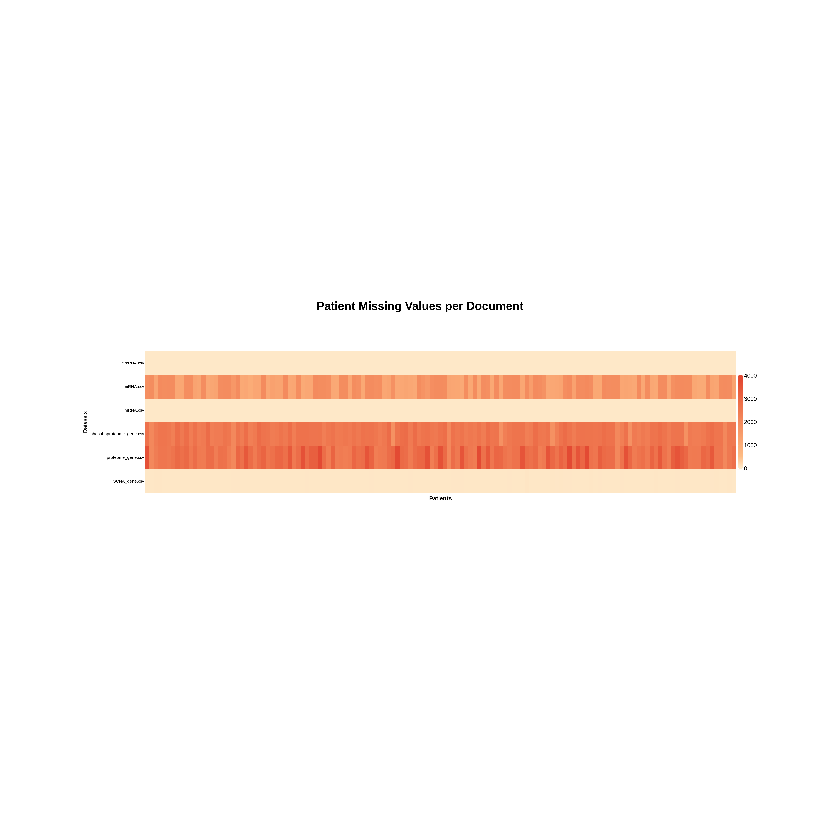

In [ ]:
library(png)
library(grid)

img <- readPNG("missing_heatmap.png")
grid::grid.raster(img)

Stacked missing count per patient over all docs

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(scales)

# prepare dataframe
df_long <- do.call(rbind, lapply(names(Mall), function(mat_name) {
  mat <- Mall[[mat_name]]
  missing_counts <- rowSums(is.na(mat))
  data.frame(
    Patient = seq_len(nrow(mat)),
    MissingCount = missing_counts,
    Matrix = mat_name
  )
}))

# compute mean and sd per patient across all matrices
total_missing_per_patient <- sapply(seq_len(nrow(Mall[[1]])), function(i) {
  sum(sapply(Mall, function(mat) {
    if (nrow(mat) >= i) sum(is.na(mat[i, ])) else 0
  }))
})

mean_missing <- mean(total_missing_per_patient)
sd_missing <- sd(total_missing_per_patient)

# create interpolated 6-color palette for matrices
base_colors <- c("#fee8c8", "#fdbb84", "#e34a33")
palette_colors <- colorRampPalette(base_colors)(length(unique(df_long$Matrix)))
matrix_colors <- setNames(palette_colors, unique(df_long$Matrix))

# plot
png("missing_per_patient_stacked.png", width = 3000, height = 1500, res = 300)

ggplot(df_long, aes(x = Patient, y = MissingCount, fill = Matrix)) +
  geom_bar(stat = "identity", position = "stack") +
  geom_ribbon(aes(ymin = mean_missing - sd_missing, ymax = mean_missing + sd_missing, x = Patient),
              fill = "gray50", alpha = 0.3) +
  geom_hline(yintercept = mean_missing, color = "black", linetype = "dashed", size = 1) +
  scale_fill_manual(values = matrix_colors) +
  theme_minimal() +
  labs(title = "Missing Values per Patient by Dataset",
       x = NULL,
       y = "Number of Missing Values") +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    panel.grid = element_blank(),
    legend.position = "right"
  )

dev.off()

cat("Mean fraction missing per patient:", round(mean_missing, 3), "\n")
cat("Standard deviation of fraction missing per patient:", round(sd_missing, 3), "\n")
variability_pct <- (sd_missing / mean_missing) * 100
cat("Variability % of missing values across patients:", round(variability_pct, 2), "%\n")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


agg_record_1645955989 
                    2

Mean fraction missing per patient: 7010.467 
Standard deviation of fraction missing per patient: 658.056 
Variability % of missing values across patients: 9.39 %


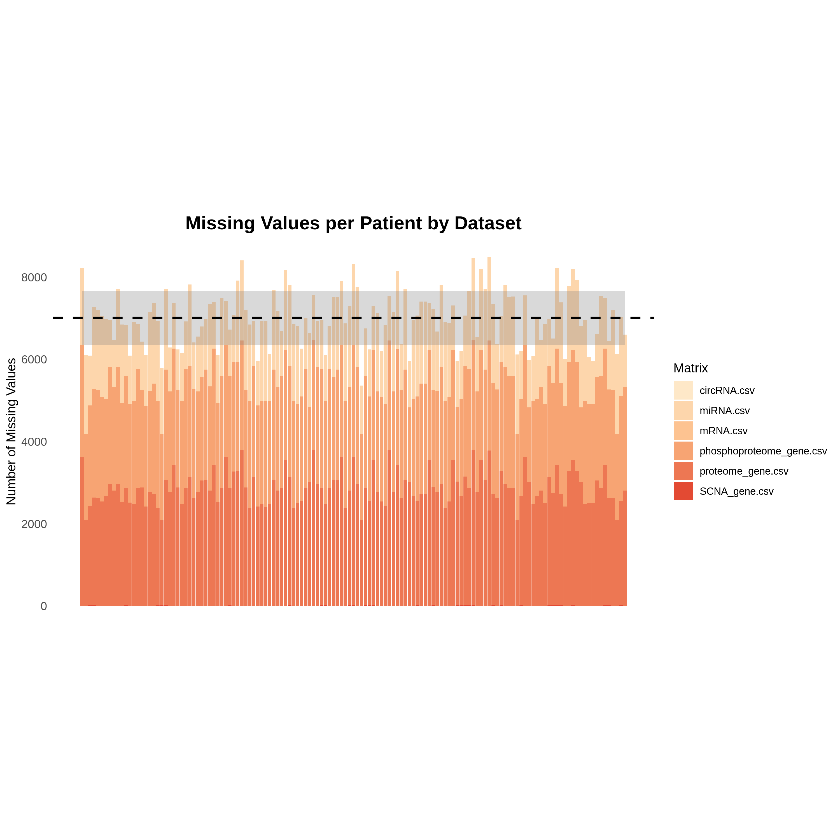

In [ ]:
library(png)
library(grid)

img <- readPNG("missing_per_patient_stacked.png")
grid::grid.raster(img)

Correlations across mx w missing pts

In [ ]:
# get matrices with missing values
matrices_with_missing <- names(Mall)[sapply(Mall, function(x) sum(is.na(x)) > 0)]

# compute fraction missing per patient (row) for each matrix
frac_missing_list <- lapply(Mall[matrices_with_missing], function(mat) {
  rowMeans(is.na(mat))
})

# combine into a dataframe (patients x matrices)
frac_missing_df <- do.call(cbind, frac_missing_list)

# compute correlation between matrices based on per-patient missingness
cor_missing <- cor(frac_missing_df, use = "pairwise.complete.obs")

print("Correlation of missingness across matrices with missing values:")
print(round(cor_missing, 3))

[1] "Correlation of missingness across matrices with missing values:"
                         miRNA.csv phosphoproteome_gene.csv proteome_gene.csv
miRNA.csv                    1.000                    0.012            -0.043
phosphoproteome_gene.csv     0.012                    1.000             0.416
proteome_gene.csv           -0.043                    0.416             1.000
SCNA_gene.csv                0.024                   -0.014            -0.055
                         SCNA_gene.csv
miRNA.csv                        0.024
phosphoproteome_gene.csv        -0.014
proteome_gene.csv               -0.055
SCNA_gene.csv                    1.000


In [ ]:
library(ggplot2)
library(reshape2)

# compute fractions
matrices_with_missing <- names(Mall)[sapply(Mall, function(x) sum(is.na(x)) > 0)]
frac_missing_list <- lapply(Mall[matrices_with_missing], function(mat) rowMeans(is.na(mat)))
frac_missing_df <- do.call(cbind, frac_missing_list)

# correlations
cor_missing <- cor(frac_missing_df, use = "pairwise.complete.obs")

# melt for ggplot
cor_df <- melt(cor_missing)
colnames(cor_df) <- c("Matrix1", "Matrix2", "Correlation")

pal <- c("#fee8c8", "#fdbb84", "#e34a33")

png("missingness_correlation_heatmap.png", width = 3000, height = 2200, res = 300)

ggplot(cor_df, aes(Matrix1, Matrix2, fill = Correlation)) +
  geom_tile(color = "white") +
  scale_fill_gradientn(colors = pal, limits = c(-1, 1)) +
  geom_text(aes(label = round(Correlation, 2)), size = 4, color = "black") +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 0, size = 8, vjust = 1),
    axis.text.y = element_text(size = 8),
    panel.grid = element_blank(),
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_blank()
  ) +
  ggtitle("Correlation of Missingness Across Matrices")

dev.off()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




agg_record_1771897814 
                    2

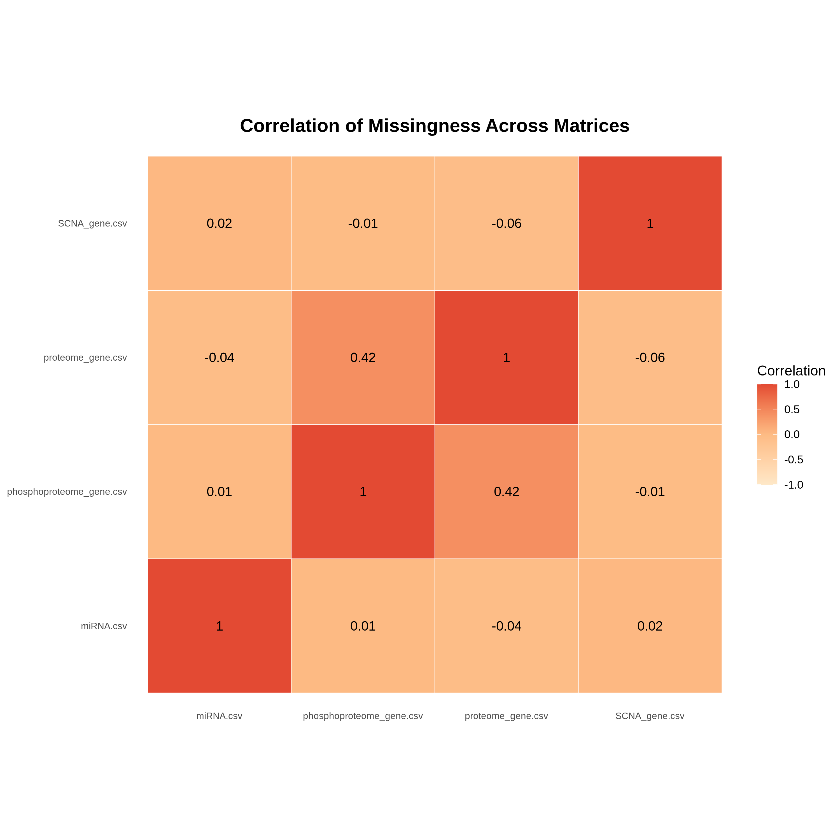

In [ ]:
library(png)
library(grid)

img <- readPNG("missingness_correlation_heatmap.png")
grid::grid.raster(img)

Missingness across features

In [ ]:
library(dplyr)
library(tidyr)

# build df + compute useful stats
missingness_stats <- lapply(names(Mall), function(nm) {
  mat <- Mall[[nm]]
  missing_frac <- colMeans(is.na(mat))

  data.frame(
    matrix = nm,
    mean_missing = mean(missing_frac),
    median_missing = median(missing_frac),
    sd_missing = sd(missing_frac),
    min_missing = min(missing_frac),
    max_missing = max(missing_frac),
    pct_features_eq_100 = mean(missing_frac >= 1) * 100,
    pct_features_over_90 = mean(missing_frac > 0.9) * 100,
    pct_features_over_80 = mean(missing_frac > 0.8) * 100,
    pct_features_over_70 = mean(missing_frac > 0.7) * 100,
    pct_features_over_60 = mean(missing_frac > 0.6) * 100,
    pct_features_over_50 = mean(missing_frac > 0.5) * 100,
    n_features = length(missing_frac)
  )
}) %>% bind_rows()

print(missingness_stats)

                    matrix mean_missing median_missing sd_missing min_missing
1              circRNA.csv 0.0000000000     0.00000000  0.0000000           0
2                miRNA.csv 0.6484567603     0.72992701  0.3200425           0
3                 mRNA.csv 0.0000000000     0.00000000  0.0000000           0
4 phosphoproteome_gene.csv 0.3203954592     0.13138686  0.3617963           0
5        proteome_gene.csv 0.2455914587     0.02919708  0.3365382           0
6            SCNA_gene.csv 0.0007667424     0.00000000  0.0266448           0
  max_missing pct_features_eq_100 pct_features_over_90 pct_features_over_80
1           0          0.00000000           0.00000000           0.00000000
2           1          0.20695364          31.04304636          43.62582781
3           0          0.00000000           0.00000000           0.00000000
4           1          0.66216892          11.49425287          18.60319840
5           1          0.26582061           7.12570743          13.0423598

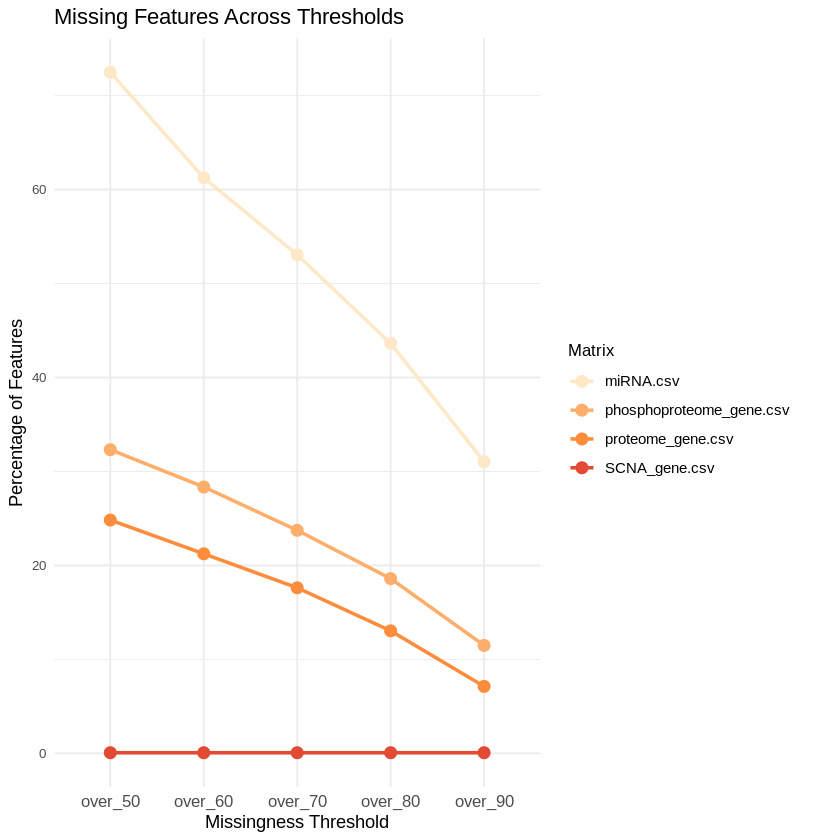

In [ ]:
library(ggplot2)
library(dplyr)
library(tidyr)

# stats for matrices with missing values
missing_stats <- data.frame(
  matrix = c("miRNA.csv","phosphoproteome_gene.csv","proteome_gene.csv","SCNA_gene.csv"),
  over_50 = c(72.48, 32.32, 24.83, 0.07),
  over_60 = c(61.26, 28.35, 21.24, 0.07),
  over_70 = c(53.06, 23.74, 17.62, 0.07),
  over_80 = c(43.63, 18.60, 13.04, 0.07),
  over_90 = c(31.04, 11.49, 7.13, 0.07)
)

# reshape for plotting
missing_long <- missing_stats %>%
  pivot_longer(cols = starts_with("over"), names_to = "threshold", values_to = "pct_features")

# order thresholds
missing_long$threshold <- factor(missing_long$threshold, levels = c("over_50","over_60","over_70","over_80","over_90"))

pal <- c("#fee8c8", "#fdae6b", "#fd8d3c", "#e34a33")

# plot
ggplot(missing_long, aes(x = threshold, y = pct_features, group = matrix, color = matrix)) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  scale_color_manual(values = pal) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 10),
    axis.text.y = element_text(size = 8),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 9)
  ) +
  labs(
    title = "Missing Features Across Thresholds",
    x = "Missingness Threshold",
    y = "Percentage of Features",
    color = "Matrix"
  )

# save as image
ggsave("missingness_features_line_plot.png", width = 6, height = 5)

#### Filtering cols based on missing pts analysis

In [ ]:
# compute % missing per patient per matrix
Mall_clean <- lapply(Mall, function(mat) {
  keep <- colMeans(is.na(mat)) <= 0.8
  mat[, keep, drop = FALSE]
})

missing_summary <- lapply(Mall_clean, function(mat) {
  rowMeans(is.na(mat))
})

# compute max missing % per matrix
max_missing_per_matrix <- sapply(missing_summary, max)
min_missing_per_matrix <- sapply(missing_summary, min)

patient_frac_missing <- lapply(Mall_clean, function(M) rowMeans(is.na(M)))
sapply(patient_frac_missing, function(x) sum(x > 0.2))

max_missing_per_matrix
min_missing_per_matrix

circRNA.csv                miRNA.csv                 mRNA.csv 
                       0                       80                        0 
phosphoproteome_gene.csv        proteome_gene.csv            SCNA_gene.csv 
                      34                       16                        0

circRNA.csv                miRNA.csv                 mRNA.csv 
             0.000000000              0.723201175              0.000000000 
phosphoproteome_gene.csv        proteome_gene.csv            SCNA_gene.csv 
             0.223791251              0.229957598              0.000754072

circRNA.csv                miRNA.csv                 mRNA.csv 
              0.00000000               0.08737151               0.00000000 
phosphoproteome_gene.csv        proteome_gene.csv            SCNA_gene.csv 
              0.12463546               0.08440982               0.00000000

get.miss.pts again for comparison

In [ ]:
library(missSNF)

missing_patients <- get.miss.pts(Mall_clean, perc.na = 0.2, miss.symbols = NULL)

ERROR: Error in library(missSNF): there is no package called ‘missSNF’


### Miss-SNF

In [ ]:
library(missSNF)
library(SNFtool)

# 2. Binary-matrix check for correct similarity kernel
is_binary_matrix <- function(M){
  vals <- unique(as.vector(M))
  vals <- vals[!is.na(vals)]
  length(vals) > 0 && all(vals %in% c(0,1))
}

sims <- sapply(Mall_clean, function(M) {
  if (is_binary_matrix(M)) "scaled.exp.chi2" else "scaled.exp.euclidean"
})

# 3. K-nearest neighbors parameter
N <- nrow(Mall_clean[[1]])
K_global <- max(5, min(20, N - 1))
sims.arg <- lapply(seq_along(sims), function(i) list(kk = K_global))

# 4. Run miss.snf using reconstruct + median imputation for partially-missing patients
fit <- miss.snf(
  Mall     = Mall_clean,
  sims     = sims,
  sims.arg = sims.arg,
  mode     = "reconstruct",
  perc.na  = 0.2,       # allowed missing %
  impute   = "median",  # impute patients with few missing values
  K        = K_global,
  t        = 20
)

W <- fit$W
dim(W)

In [ ]:
saveRDS(fit, file = "fit_result.rds")

In [ ]:
length(fit$removed.pts)         # number of patients removed
fit$removed.pts                 # names of removed patients

[1] 0

character(0)

### Some vis

In [ ]:
# Load saved miss.snf result
fit <- readRDS("fit_result.rds")

# Recreate W from the loaded fit object
W <- fit$W

# (optional) check dimensions
dim(W)


[1] 137 137

In [ ]:
library(igraph)

# --- Normalize W to [0,1] ---
W_norm <- W / max(W)

n <- nrow(W_norm)
K <- 6# try 5, 10, 15, 20 etc.

# --- Build KNN similarity matrix ---
W_knn <- matrix(0, nrow = n, ncol = n)
rownames(W_knn) <- rownames(W_norm)
colnames(W_knn) <- colnames(W_norm)

for (i in 1:n) {
  # indices of top-K neighbours (excluding self)
  idx <- order(W_norm[i, ], decreasing = TRUE)
  idx <- idx[idx != i][1:K]
  W_knn[i, idx] <- W_norm[i, idx]
}

# Make the matrix symmetric (undirected graph)
W_knn <- pmax(W_knn, t(W_knn))

# --- Run Louvain on KNN graph ---
g_knn <- graph_from_adjacency_matrix(W_knn, mode = "undirected",
                                     weighted = TRUE, diag = FALSE)
cl_knn <- cluster_louvain(g_knn)
cluster_knn <- factor(membership(cl_knn))

table(cluster_knn)



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




cluster_knn
 1  2  3  4  5  6 
25 34 21 32 17  8 

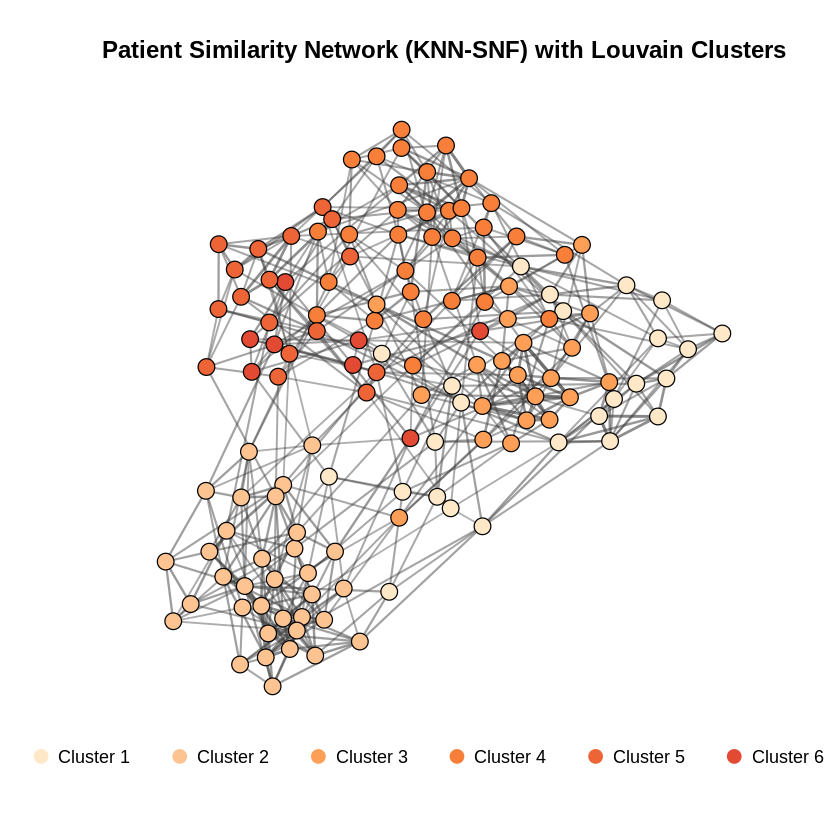

In [ ]:
library(igraph)
library(grDevices)

## --- 1) Build graph from the KNN similarity matrix ---

# W_knn: symmetric patient-patient similarity matrix (after KNN filtering)
g_knn <- graph_from_adjacency_matrix(
  W_knn,
  mode  = "undirected",
  weighted = TRUE,
  diag  = FALSE
)

## --- 2) Cluster labels from KNN-Louvain result ---

# Make sure cluster_knn is a factor
cluster_knn <- factor(cluster_knn)

# Number of clusters
n_clusters <- length(levels(cluster_knn))


## --- 3) Layout for visualization ---

# Use a force-directed layout so that similar patients are placed close
set.seed(123)  # for reproducibility
coords <- layout_with_fr(g_knn)   # Fruchterman–Reingold layout


## --- 4) Colors and edge aesthetics ---

# Generate a palette interpolating between your 3 base colors
base_colors <- c("#fee8c8", "#fd8d3c", "#e34a33")
palette_fun <- colorRampPalette(base_colors)
palette <- palette_fun(n_clusters)

# Assign vertex colors by cluster
V(g_knn)$color <- palette[as.integer(cluster_knn)]

# Edge width and alpha proportional to similarity
# --- Stronger but still readable edge style ---
w <- E(g_knn)$weight
max_w <- max(w, na.rm = TRUE)

# Alpha range: 0.25 - 0.75  (more visible)
edge_alpha <- 0.25 + 0.50 * (w / max_w)

# Edge thickness range: 0.8 - 2.8
edge_lwd <- 0.8 + 2.0 * (w / max_w)

# Slightly darker grey
edge_col <- rgb(0.25, 0.25, 0.25, alpha = edge_alpha)

plot(
  g_knn,
  layout       = coords,
  vertex.color = V(g_knn)$color,
  vertex.size  = 6,
  vertex.label = NA,
  edge.width   = edge_lwd,
  edge.color   = edge_col,
  main         = "Patient Similarity Network (KNN-SNF) with Louvain Clusters"
)

## --- 6) Legend for clusters ---

par(xpd = TRUE)  # allow legend outside plot region
legend(
  "bottom",
  inset  = c(0, -0.10),
  legend = paste("Cluster", levels(cluster_knn)),
  col    = palette,
  pch    = 19,
  pt.cex = 1.5,
  horiz  = TRUE,
  bty    = "n",
  cex    = 0.9
)
par(xpd = FALSE)


Convergence

In [ ]:
install.packages("ggridges")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



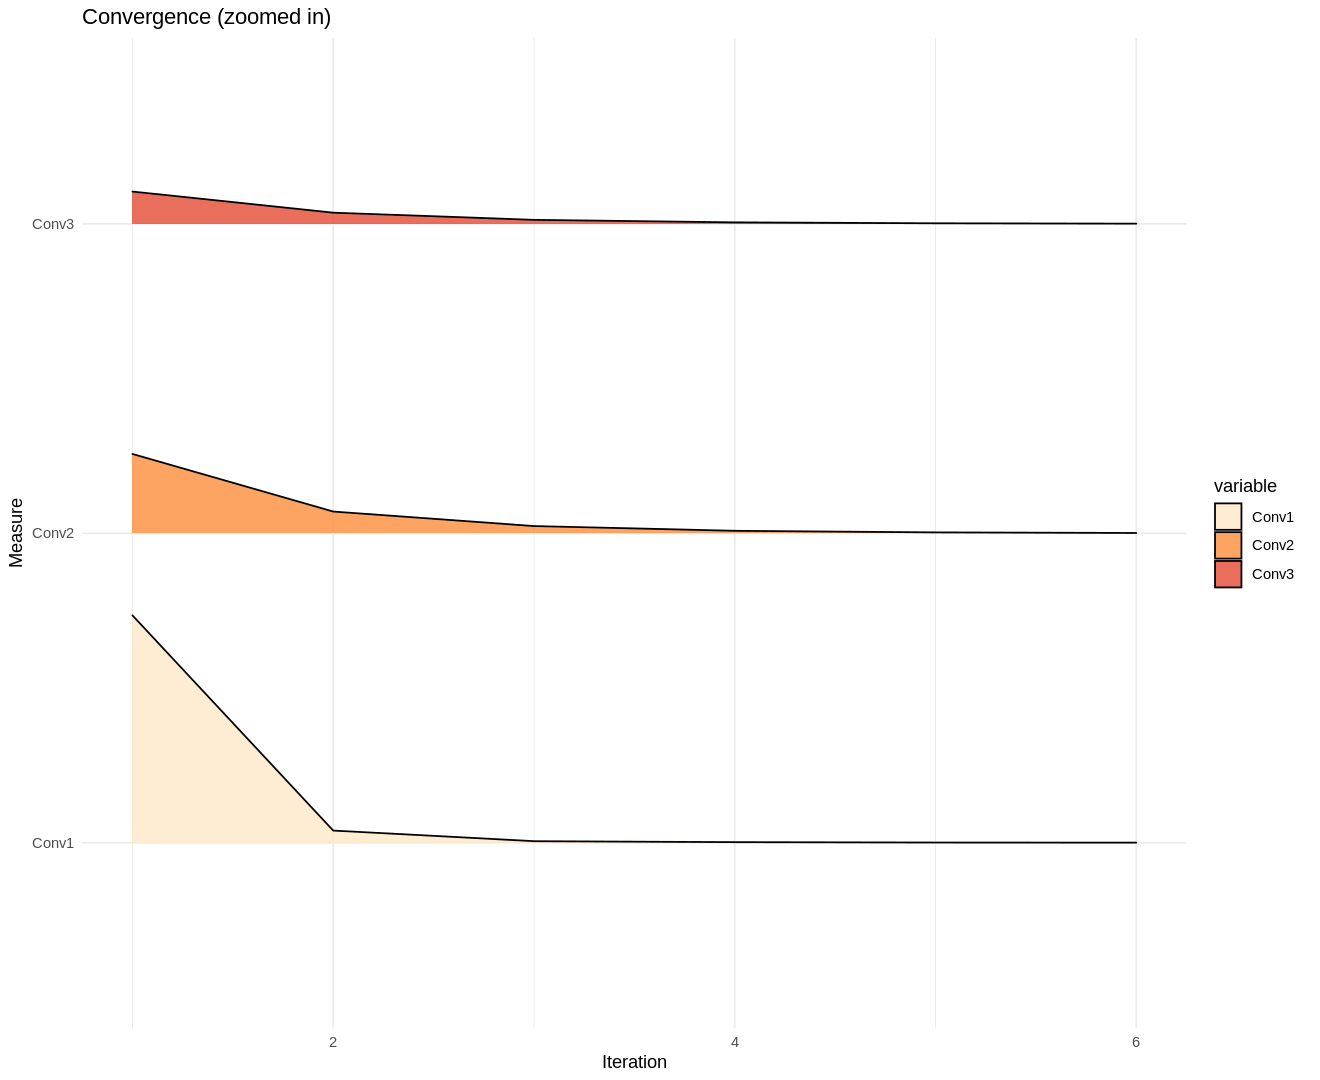

In [ ]:
library(ggridges)
library(reshape2)
library(ggplot2)


conv_df <- data.frame(
  Iteration = 1:length(fit$conv1),
  Conv1 = fit$conv1,
  Conv2 = fit$conv2,
  Conv3 = fit$conv3
)
conv_melt <- melt(conv_df, id.vars="Iteration")

# pick only first 30 iterations
conv_melt_small <- conv_melt[conv_melt$Iteration <= 6, ]

ggplot(conv_melt_small, aes(x=Iteration, y=variable, height=value, fill=variable)) +
  geom_ridgeline(alpha=0.8, scale=12) +
  scale_fill_manual(values=c("#fee8c8","#fd8d3c","#e34a33")) +
  theme_minimal() +
  labs(title="Convergence (zoomed in)", x="Iteration", y="Measure")

In [ ]:
# cluster_knn: Louvain clusters on KNN-SNF graph
# W_knn: KNN similarity matrix (137 x 137)

cluster_knn <- factor(cluster_knn)
patient_ids <- rownames(W_knn)  # or rownames(Mall[[1]])
length(cluster_knn); length(patient_ids)


[1] 137

[1] 137

In [ ]:
library(dplyr)
library(stringr)

clin <- read.csv("clinical_data.csv", stringsAsFactors = FALSE)


str(clin)


'data.frame':	140 obs. of  25 variables:
 $ case_id                                 : chr  "C3L-00017" "C3L-00102" "C3L-00189" "C3L-00277" ...
 $ histology_diagnosis                     : chr  "PDAC" "PDAC" "PDAC" "PDAC" ...
 $ age                                     : int  69 42 68 69 62 80 61 62 72 34 ...
 $ sex                                     : chr  "Male" "Male" "Female" "Male" ...
 $ race                                    : chr  "White" "White" "" "White" ...
 $ participant_country                     : chr  "United States" "United States" "Cada" "Other" ...
 $ tumor_site                              : chr  "head" "head" "head" "tail" ...
 $ tumor_size_cm                           : num  4.5 3 2.7 5 2.8 2.5 3 3 3.5 2.5 ...
 $ tumor_necrosis                          : chr  "Not identified" "Not identified" "Not identified" "Not identified" ...
 $ lymph_vascular_invasion                 : chr  "Not identified" "Present" "Not identified" "Not identified" ...
 $ perineural_invasi

In [ ]:
saveRDS(clin, "clin.rds")


In [ ]:
library(dplyr)
library(stringr)

clin <- read.csv("clinical_data.csv", stringsAsFactors = FALSE)

# 1) Identify character columns
char_cols <- sapply(clin, is.character)

# 2) Convert "" to NA only in character columns
clin[char_cols] <- lapply(clin[char_cols], function(x) {
  x[x == ""] <- NA
  x
})

str(clin)


'data.frame':	140 obs. of  25 variables:
 $ case_id                                 : chr  "C3L-00017" "C3L-00102" "C3L-00189" "C3L-00277" ...
 $ histology_diagnosis                     : chr  "PDAC" "PDAC" "PDAC" "PDAC" ...
 $ age                                     : int  69 42 68 69 62 80 61 62 72 34 ...
 $ sex                                     : chr  "Male" "Male" "Female" "Male" ...
 $ race                                    : chr  "White" "White" NA "White" ...
 $ participant_country                     : chr  "United States" "United States" "Cada" "Other" ...
 $ tumor_site                              : chr  "head" "head" "head" "tail" ...
 $ tumor_size_cm                           : num  4.5 3 2.7 5 2.8 2.5 3 3 3.5 2.5 ...
 $ tumor_necrosis                          : chr  "Not identified" "Not identified" "Not identified" "Not identified" ...
 $ lymph_vascular_invasion                 : chr  "Not identified" "Present" "Not identified" "Not identified" ...
 $ perineural_invasi

In [ ]:
clin <- clin %>%
  mutate(
    age            = as.numeric(age),
    tumor_size_cm  = as.numeric(tumor_size_cm),
    bmi            = as.numeric(bmi),
    follow_up_days = as.numeric(follow_up_days)
  )


In [ ]:
clin <- clin %>%
  mutate(
    sex                 = factor(sex),                 # Male / Female
    race                = factor(race),                # White / Black / etc.
    participant_country = factor(participant_country), # USA / Cada / Other
    tumor_site          = factor(tumor_site),          # head / body / tail
    tumor_necrosis      = factor(tumor_necrosis),
    lymph_vascular_invasion = factor(lymph_vascular_invasion),
    perineural_invasion     = factor(perineural_invasion),
    tumor_stage_pathological = factor(tumor_stage_pathological),
    alcohol_consumption     = factor(alcohol_consumption),
    tobacco_smoking_history = factor(tobacco_smoking_history),
    vital_status            = factor(vital_status),        # Living / Deceased
    is_this_patient_lost_to_follow_up = factor(is_this_patient_lost_to_follow_up),
    cause_of_death         = factor(cause_of_death),
    histology_diagnosis    = factor(histology_diagnosis)
  )
clin$case_id <- as.character(clin$case_id)


In [ ]:
clin <- clin %>%
  mutate(
    pn_clean = str_extract(pathologic_staging_regiol_lymph_nodes_pn, "N[0-3]"),
    pn_factor = factor(
      pn_clean,
      levels  = c("N0", "N1", "N2", "N3"),
      ordered = TRUE
    )
  )


In [ ]:
clin <- clin %>%
  mutate(
    pt_clean = str_extract(pathologic_staging_primary_tumor_pt, "T[0-4]"),
    pt_factor = factor(
      pt_clean,
      levels  = c("T0", "T1", "T2", "T3", "T4"),
      ordered = TRUE
    )
  )


In [ ]:
clin <- clin %>%
  mutate(
    pm_clean = str_extract(pathologic_staging_distant_metastasis_pm, "M[0-1X]"),
    pm_clean = ifelse(pm_clean == "MX", NA, pm_clean),
    pm_factor = factor(
      pm_clean,
      levels  = c("M0", "M1"),
      ordered = TRUE
    )
  )


In [ ]:
clin <- clin %>%
  mutate(
    cm_clean = str_extract(clinical_staging_distant_metastasis_cm, "M[0-1X]"),
    cm_clean = ifelse(cm_clean == "MX", NA, cm_clean),
    cm_factor = factor(
      cm_clean,
      levels  = c("M0", "M1"),
      ordered = TRUE
    )
  )


In [ ]:
clin <- clin %>%
  mutate(
    residual_code = substr(residual_tumor, 1, 2),  # "R0", "R1", "R2", "RX"
    residual_code = ifelse(residual_code %in% c("R0","R1","R2","RX"),
                           residual_code, NA),
    residual_tumor_ord = factor(
      residual_code,
      levels  = c("R0", "R1", "R2", "RX"),
      ordered = TRUE
    )
  )


In [ ]:
clin_clean <- clin %>%
  select(
    case_id,
    histology_diagnosis,
    age,
    sex, race, participant_country,
    tumor_site,
    tumor_size_cm,
    tumor_necrosis,
    lymph_vascular_invasion,
    perineural_invasion,
    pn_factor, pt_factor, pm_factor, cm_factor,
    residual_tumor_ord,
    tumor_stage_pathological,
    bmi,
    alcohol_consumption,
    tobacco_smoking_history,
    follow_up_days,
    vital_status,
    is_this_patient_lost_to_follow_up,
    cause_of_death
  )


In [ ]:
str(clin_clean)
head(clin_clean)


'data.frame':	140 obs. of  24 variables:
 $ case_id                          : chr  "C3L-00017" "C3L-00102" "C3L-00189" "C3L-00277" ...
 $ histology_diagnosis              : Factor w/ 2 levels "Adenosquamous carcinoma",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ age                              : num  69 42 68 69 62 80 61 62 72 34 ...
 $ sex                              : Factor w/ 2 levels "Female","Male": 2 2 1 2 1 2 1 2 2 1 ...
 $ race                             : Factor w/ 2 levels "Black or African American",..: 2 2 NA 2 NA 2 NA NA NA NA ...
 $ participant_country              : Factor w/ 12 levels "Bulgaria","Cada",..: 12 12 2 7 2 12 2 8 2 2 ...
 $ tumor_site                       : Factor w/ 5 levels "body","body and tail",..: 3 3 3 5 1 3 3 3 3 3 ...
 $ tumor_size_cm                    : num  4.5 3 2.7 5 2.8 2.5 3 3 3.5 2.5 ...
 $ tumor_necrosis                   : Factor w/ 2 levels "Not identified",..: 1 1 1 1 1 1 2 1 1 1 ...
 $ lymph_vascular_invasion          : Factor w/ 3 levels "Indet

,case_id,histology_diagnosis,age,sex,race,participant_country,tumor_site,tumor_size_cm,tumor_necrosis,lymph_vascular_invasion,⋯,cm_factor,residual_tumor_ord,tumor_stage_pathological,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death
,<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,⋯,<ord>,<ord>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
1,C3L-00017,PDAC,69,Male,White,United States,head,4.5,Not identified,Not identified,⋯,NA,RX,Stage IIA,28.36,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Current reformed smoker within past 15 years,426,Living,Yes,NA
2,C3L-00102,PDAC,42,Male,White,United States,head,3.0,Not identified,Present,⋯,M0,R0,Stage III,26.93,Alcohol consumption history not available,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,249,Deceased,No,pancreatic carcinoma
3,C3L-00189,PDAC,68,Female,NA,Cada,head,2.7,Not identified,Not identified,⋯,M0,R1,Stage IIB,34.28,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,"Current reformed smoker, more than 15 years",1035,Deceased,No,pancreatic carcinoma
4,C3L-00277,PDAC,69,Male,White,Other,tail,5.0,Not identified,Not identified,⋯,NA,R2,Stage IIB,24.00,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,610,Deceased,Yes,pancreatic carcinoma
5,C3L-00401,PDAC,62,Female,NA,Cada,body,2.8,Not identified,Present,⋯,M0,R0,Stage IIB,22.42,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,1228,Living,No,NA
6,C3L-00589,PDAC,80,Male,White,United States,head,2.5,Not identified,Present,⋯,M0,R0,Stage IIB,27.43,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Current reformed smoker within past 15 years,1046,Living,No,NA


In [ ]:
sapply(clin_clean, class)


$case_id
[1] "character"

$histology_diagnosis
[1] "factor"

$age
[1] "numeric"

$sex
[1] "factor"

$race
[1] "factor"

$participant_country
[1] "factor"

$tumor_site
[1] "factor"

$tumor_size_cm
[1] "numeric"

$tumor_necrosis
[1] "factor"

$lymph_vascular_invasion
[1] "factor"

$perineural_invasion
[1] "factor"

$pn_factor
[1] "ordered" "factor" 

$pt_factor
[1] "ordered" "factor" 

$pm_factor
[1] "ordered" "factor" 

$cm_factor
[1] "ordered" "factor" 

$residual_tumor_ord
[1] "ordered" "factor" 

$tumor_stage_pathological
[1] "factor"

$bmi
[1] "numeric"

$alcohol_consumption
[1] "factor"

$tobacco_smoking_history
[1] "factor"

$follow_up_days
[1] "numeric"

$vital_status
[1] "factor"

$is_this_patient_lost_to_follow_up
[1] "factor"

$cause_of_death
[1] "factor"

In [ ]:
clusters_df <- data.frame(
  case_id = patient_ids,
  cluster_knn = cluster_knn
)

head(clusters_df)
table(clusters_df$cluster_knn)


,case_id,cluster_knn
,<chr>,<fct>
C3L-03394,C3L-03394,1
C3N-03428,C3N-03428,1
C3L-02112,C3L-02112,2
C3N-01719,C3N-01719,1
C3N-03670,C3N-03670,1
C3N-02998,C3N-02998,1



 1  2  3  4  5  6 
25 34 21 32 17  8 

In [ ]:
nrow(clusters_df)                    # how many patients have a cluster?
length(unique(clusters_df$case_id))  # are the case_id values unique?

setdiff(clin_clean$case_id, clusters_df$case_id)  # patients present in clinical data but missing in omics data


[1] 137

[1] 137

[1] "C3L-02115" "C3L-02890" "C3N-01997"

In [ ]:
all.equal(
  sort(patient_ids),
  sort(clin_clean$case_id)
)


[1] "Lengths (137, 140) differ (string compare on first 137)"
[2] "104 string mismatches"

In [ ]:
clin_cluster <- clin_clean %>%
    mutate(patient_id = rownames(clin_clean),
           cluster_knn = cluster_knn[patient_id])


In [ ]:
clin_analysis <- clin_cluster %>%
    filter(!is.na(cluster_knn))


In [ ]:
setdiff(clin_clean$case_id, patient_ids)


[1] "C3L-02115" "C3L-02890" "C3N-01997"

In [ ]:
clin_analysis <- clin_cluster %>%
  filter(!is.na(cluster_knn))


In [ ]:
dput(cluster_knn)


structure(c(`C3L-03394` = 1L, `C3N-03428` = 1L, `C3L-02112` = 2L, 
`C3N-01719` = 1L, `C3N-03670` = 1L, `C3N-02998` = 1L, `C3N-03211` = 1L, 
`C3L-01052` = 2L, `C3N-00512` = 2L, `C3N-02295` = 1L, `C3N-01012` = 2L, 
`C3N-01502` = 1L, `C3L-01053` = 2L, `C3L-03632` = 2L, `C3L-00401` = 2L, 
`C3L-01054` = 2L, `C3N-00517` = 2L, `C3N-03440` = 2L, `C3L-04495` = 1L, 
`C3N-04284` = 2L, `C3N-00957` = 1L, `C3L-03395` = 2L, `C3N-00303` = 1L, 
`C3N-00513` = 2L, `C3N-01166` = 2L, `C3N-01382` = 2L, `C3N-01011` = 2L, 
`C3L-04473` = 2L, `C3L-00640` = 3L, `C3L-00189` = 1L, `C3N-01998` = 2L, 
`C3L-01036` = 3L, `C3N-03069` = 4L, `C3L-00881` = 2L, `C3N-01715` = 3L, 
`C3N-03426` = 3L, `C3N-00198` = 1L, `C3N-01380` = 1L, `C3N-01388` = 1L, 
`C3L-03388` = 5L, `C3N-02589` = 2L, `C3L-03356` = 1L, `C3N-02944` = 6L, 
`C3N-00436` = 4L, `C3L-00928` = 1L, `C3L-01124` = 6L, `C3N-02592` = 1L, 
`C3N-01383` = 4L, `C3N-03439` = 5L, `C3N-03006` = 2L, `C3N-01165` = 6L, 
`C3N-03173` = 2L, `C3L-04475` = 4L, `C3L-04853` = 6L, `C3

In [ ]:
clusters_df <- data.frame(
  case_id     = names(cluster_knn),
  cluster_knn = cluster_knn
)

clin_cluster <- clin_clean %>%
  left_join(clusters_df, by = "case_id")


In [ ]:
clin_analysis <- clin_cluster %>%
  filter(!is.na(cluster_knn))


In [ ]:
clin_cluster


case_id,histology_diagnosis,age,sex,race,participant_country,tumor_site,tumor_size_cm,tumor_necrosis,lymph_vascular_invasion,⋯,residual_tumor_ord,tumor_stage_pathological,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death,cluster_knn
<chr>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,⋯,<ord>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
C3L-00017,PDAC,69,Male,White,United States,head,4.5,Not identified,Not identified,⋯,RX,Stage IIA,28.36,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Current reformed smoker within past 15 years,426,Living,Yes,NA,5
C3L-00102,PDAC,42,Male,White,United States,head,3.0,Not identified,Present,⋯,R0,Stage III,26.93,Alcohol consumption history not available,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,249,Deceased,No,pancreatic carcinoma,1
C3L-00189,PDAC,68,Female,NA,Cada,head,2.7,Not identified,Not identified,⋯,R1,Stage IIB,34.28,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,"Current reformed smoker, more than 15 years",1035,Deceased,No,pancreatic carcinoma,1
C3L-00277,PDAC,69,Male,White,Other,tail,5.0,Not identified,Not identified,⋯,R2,Stage IIB,24.00,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,610,Deceased,Yes,pancreatic carcinoma,4
C3L-00401,PDAC,62,Female,NA,Cada,body,2.8,Not identified,Present,⋯,R0,Stage IIB,22.42,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,1228,Living,No,NA,2
C3L-00589,PDAC,80,Male,White,United States,head,2.5,Not identified,Present,⋯,R0,Stage IIB,27.43,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Current reformed smoker within past 15 years,1046,Living,No,NA,5
C3L-00598,PDAC,61,Female,NA,Cada,head,3.0,Present,Present,⋯,R0,Stage III,16.00,Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women,Current smoker: Includes daily and non-daily smokers,422,Deceased,No,pancreatic carcinoma,3
C3L-00599,PDAC,62,Male,NA,Poland,head,3.0,Not identified,Present,⋯,R0,Stage IIB,25.05,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime,1189,Living,No,NA,5
C3L-00622,PDAC,72,Male,NA,Cada,head,3.5,Not identified,Present,⋯,R1,Stage IIB,28.74,Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women,"Current reformed smoker, more than 15 years",311,Deceased,No,unknown,4


In [ ]:
install.packages("ggpubr")
library(ggpubr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘Deriv’, ‘forecast’, ‘microbenchmark’, ‘rbibutils’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Loading required package: ggplot2



In [ ]:
install.packages("devtools")
devtools::install_github("kassambara/survminer")
library(survminer)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




litedown     (NA     -> 0.8   ) [CRAN]
xml2         (1.5.0  -> 1.5.1 ) [CRAN]
jpeg         (NA     -> 0.1-11) [CRAN]
markdown     (NA     -> 2.0   ) [CRAN]
isoband      (0.2.7  -> 0.3.0 ) [CRAN]
yaml         (2.3.10 -> 2.3.12) [CRAN]
broom        (1.0.10 -> 1.0.11) [CRAN]
gridtext     (NA     -> 0.1.5 ) [CRAN]
km.ci        (NA     -> 0.5-6 ) [CRAN]
KMsurv       (NA     -> 0.1-6 ) [CRAN]
mvtnorm      (NA     -> 1.3-3 ) [CRAN]
exactRank... (NA     -> 0.8-35) [CRAN]
ggtext       (NA     -> 0.1.2 ) [CRAN]
survMisc     (NA     -> 0.5.6 ) [CRAN]
maxstat      (NA     -> 0.7-26) [CRAN]


Installing 15 packages: litedown, xml2, jpeg, markdown, isoband, yaml, broom, gridtext, km.ci, KMsurv, mvtnorm, exactRankTests, ggtext, survMisc, maxstat

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpiqWMue/remotes114863d0596e/kassambara-survminer-e23fa12/DESCRIPTION’ ... OK
* preparing ‘survminer’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘survminer_0.5.1.999.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [ ]:
library(dplyr)
library(ggplot2)
library(survival)

# 1) cluster NA
clin_analysis <- clin_cluster %>%
  filter(!is.na(cluster_knn))

clin_analysis$cluster_knn <- factor(clin_analysis$cluster_knn)


In [ ]:
str(clin_cluster)
table(clin_cluster$cluster_knn, useNA = "ifany")


'data.frame':	140 obs. of  25 variables:
 $ case_id                          : chr  "C3L-00017" "C3L-00102" "C3L-00189" "C3L-00277" ...
 $ histology_diagnosis              : Factor w/ 2 levels "Adenosquamous carcinoma",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ age                              : num  69 42 68 69 62 80 61 62 72 34 ...
 $ sex                              : Factor w/ 2 levels "Female","Male": 2 2 1 2 1 2 1 2 2 1 ...
 $ race                             : Factor w/ 2 levels "Black or African American",..: 2 2 NA 2 NA 2 NA NA NA NA ...
 $ participant_country              : Factor w/ 12 levels "Bulgaria","Cada",..: 12 12 2 7 2 12 2 8 2 2 ...
 $ tumor_site                       : Factor w/ 5 levels "body","body and tail",..: 3 3 3 5 1 3 3 3 3 3 ...
 $ tumor_size_cm                    : num  4.5 3 2.7 5 2.8 2.5 3 3 3.5 2.5 ...
 $ tumor_necrosis                   : Factor w/ 2 levels "Not identified",..: 1 1 1 1 1 1 2 1 1 1 ...
 $ lymph_vascular_invasion          : Factor w/ 3 levels "Indet


   1    2    3    4    5    6 <NA> 
  25   34   21   32   17    8    3 

In [ ]:
write.csv(clin_cluster, "clin_cluster.csv", row.names = FALSE)


In [ ]:
# Packages
library(dplyr)

# 1) Read merged clinical + cluster table
clin_cluster <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE)

# 2) Keep only patients that have a cluster label (remove the 3 with NA)
clin_analysis <- clin_cluster %>%
  filter(!is.na(cluster_knn))

# 3) Ensure cluster_knn is a factor
clin_analysis$cluster_knn <- factor(clin_analysis$cluster_knn)

# 4) Rebuild ordinal variables as ordered factors (in case they were lost when saving CSV)
clin_analysis$pn_factor  <- factor(clin_analysis$pn_factor,
                                   levels = c("N0","N1","N2","N3"),
                                   ordered = TRUE)

clin_analysis$pt_factor  <- factor(clin_analysis$pt_factor,
                                   levels = c("T0","T1","T2","T3","T4"),
                                   ordered = TRUE)

clin_analysis$pm_factor  <- factor(clin_analysis$pm_factor,
                                   levels = c("M0","M1"),
                                   ordered = TRUE)

clin_analysis$cm_factor  <- factor(clin_analysis$cm_factor,
                                   levels = c("M0","M1"),
                                   ordered = TRUE)

clin_analysis$residual_tumor_ord <- factor(clin_analysis$residual_tumor_ord,
                                           levels = c("R0","R1","R2","RX"),
                                           ordered = TRUE)

# 5) Ensure nominal categorical variables are factors
fac_vars <- c(
  "histology_diagnosis",
  "sex",
  "race",
  "participant_country",
  "tumor_site",
  "tumor_necrosis",
  "lymph_vascular_invasion",
  "perineural_invasion",
  "tumor_stage_pathological",
  "alcohol_consumption",
  "tobacco_smoking_history",
  "vital_status",
  "is_this_patient_lost_to_follow_up",
  "cause_of_death"
)

clin_analysis[fac_vars] <- lapply(clin_analysis[fac_vars], factor)


In [ ]:
# Numeric variables
numeric_vars <- c("age", "tumor_size_cm", "bmi")

# Ordinal variables (ordered factors)
ordinal_vars <- c("pn_factor", "pt_factor", "pm_factor", "cm_factor", "residual_tumor_ord")

# Nominal variables (unordered categorical)
nominal_vars <- c(
  "histology_diagnosis",
  "sex",
  "race",
  "participant_country",
  "tumor_site",
  "tumor_necrosis",
  "lymph_vascular_invasion",
  "perineural_invasion",
  "tumor_stage_pathological",
  "alcohol_consumption",
  "tobacco_smoking_history",
  "vital_status",
  "is_this_patient_lost_to_follow_up",
  "cause_of_death"
)


In [ ]:
# Numeric variables
numeric_vars <- c("age", "tumor_size_cm", "bmi", "follow_up_days")

# Ordinal variables (ordered factors)
ordinal_vars <- c("pn_factor", "pt_factor", "pm_factor", "cm_factor", "residual_tumor_ord")

# Nominal variables (unordered categorical)
nominal_vars <- c(
  "histology_diagnosis",
  "sex",
  "race",
  "participant_country",
  "tumor_site",
  "tumor_necrosis",
  "lymph_vascular_invasion",
  "perineural_invasion",
  "tumor_stage_pathological",
  "alcohol_consumption",
  "tobacco_smoking_history",
  "vital_status",
  "is_this_patient_lost_to_follow_up",
  "cause_of_death"
)


numericnew


#tests

In [ ]:
clin <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE)

# converting the cluster column to a factor
clin$cluster_knn <- factor(clin$cluster_knn)


In [ ]:
# Numeric variables
numeric_vars <- c("age", "tumor_size_cm", "bmi")

# Ordinal variables
ordinal_vars <- c("pn_factor","pt_factor","pm_factor","cm_factor","residual_tumor_ord")

# Nominal variables
nominal_vars <- c(
  "sex","race","participant_country","tumor_site","tumor_necrosis",
  "lymph_vascular_invasion","perineural_invasion","tumor_stage_pathological",
  "alcohol_consumption","tobacco_smoking_history","vital_status",
  "is_this_patient_lost_to_follow_up","cause_of_death"
)


#numeric test

In [ ]:
library(dplyr)

# Build a summary table for numeric Kruskal–Wallis tests
numeric_kw_df <- bind_rows(
  lapply(names(numeric_results), function(var) {
    test_res <- numeric_results[[var]]
    data.frame(
      variable     = var,
      chi_squared  = unname(test_res$statistic),
      df           = unname(test_res$parameter),
      p_value      = test_res$p.value,
      stringsAsFactors = FALSE
    )
  })
) %>%
  mutate(
    p_fdr              = p.adjust(p_value, method = "fdr"),
    significant_0_05   = ifelse(p_value < 0.05, "YES", "NO"),
    significant_0_05_fdr = ifelse(p_fdr < 0.05, "YES", "NO")
  ) %>%
  arrange(p_value)

numeric_kw_df


variable,chi_squared,df,p_value,p_fdr,significant_0_05,significant_0_05_fdr
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
tumor_size_cm,17.801413,5,0.003205869,0.01282347,YES,YES
bmi,7.982472,5,0.157204295,0.23174317,NO,NO
follow_up_days,7.695955,5,0.173807375,0.23174317,NO,NO
age,5.089488,5,0.405056963,0.40505696,NO,NO


In [ ]:
library(dplyr)

# Extract pairwise table for tumor_size_cm
pairwise_tumor_size <- pairwise_results[["tumor_size_cm"]] %>%
  mutate(
    p_raw  = round(p_raw, 4),
    p_adj  = round(p_adj, 4),
    sig_0_05_raw = ifelse(p_raw < 0.05, "YES", "NO"),
    sig_0_05_fdr = ifelse(p_adj < 0.05, "YES", "NO")
  ) %>%
  arrange(p_adj)

pairwise_tumor_size


var,cluster1,cluster2,p_raw,p_adj,sig_0_05_raw,sig_0_05_fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
tumor_size_cm,1,6,0.0053,0.0264,YES,YES
tumor_size_cm,2,4,0.0032,0.0264,YES,YES
tumor_size_cm,4,6,0.0037,0.0264,YES,YES
tumor_size_cm,3,6,0.0150,0.0564,YES,NO
tumor_size_cm,1,2,0.0207,0.0620,YES,NO
tumor_size_cm,5,6,0.0377,0.0943,YES,NO
tumor_size_cm,2,3,0.0525,0.1124,NO,NO
tumor_size_cm,4,5,0.0957,0.1794,NO,NO
tumor_size_cm,2,6,0.1798,0.2997,NO,NO


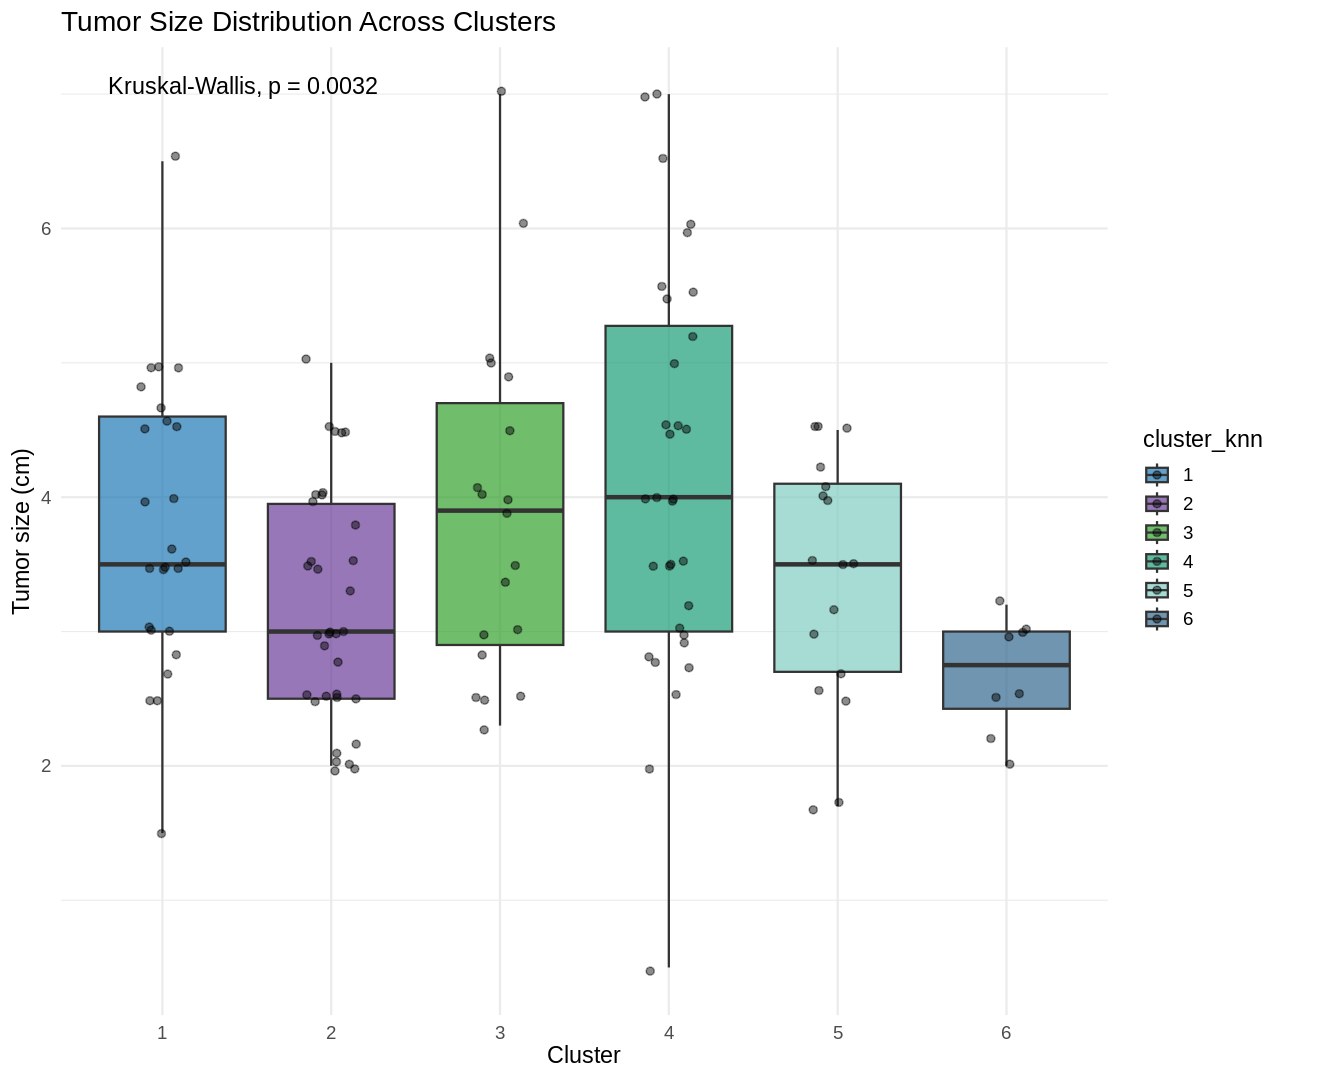

In [ ]:
library(ggplot2)
library(ggpubr)

# Filter out NAs for plotting
plot_data <- clin_analysis %>%
  dplyr::filter(!is.na(cluster_knn), !is.na(tumor_size_cm))

# Your cluster color palette
cluster_cols <- c(
  "1" = "#1f78b4",  # deep blue
  "2" = "#6a3d9a",  # violet/purple
  "3" = "#33a02c",  # cold green
  "4" = "#1b9e77",  # teal-green
  "5" = "#80cdc1",  # soft teal-blue
  "6" = "#31688e"   # dark steel blue
)

ggplot(plot_data, aes(x = cluster_knn, y = tumor_size_cm, fill = cluster_knn)) +
  geom_boxplot(alpha = 0.7, outlier.shape = NA, na.rm = TRUE) +
  geom_jitter(width = 0.15, alpha = 0.45, size = 1.8, na.rm = TRUE) +
  stat_compare_means(
    method = "kruskal.test"
    # no label.y → ggpubr will place it automatically within the scale
  ) +
  scale_fill_manual(values = cluster_cols) +
  labs(
    title = "Tumor Size Distribution Across Clusters",
    x = "Cluster",
    y = "Tumor size (cm)"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
install.packages("effsize")
library(effsize)
library(dplyr)

numeric_vars <- c("age", "tumor_size_cm", "bmi")

df <- clin

delta_list <- list()

for (var in numeric_vars) {

  x <- df[[var]]
  cl <- factor(df$cluster_knn)

  ok <- !is.na(x) & !is.na(cl)
  x <- x[ok]
  cl <- cl[ok]

  cl_pairs <- combn(levels(cl), 2, simplify = FALSE)

  for (p in cl_pairs) {
    g1 <- p[1]
    g2 <- p[2]

    x1 <- x[cl == g1]
    x2 <- x[cl == g2]

    d <- cliff.delta(x1, x2)$estimate
    mag <- cliff.delta(x1, x2)$magnitude

    delta_list[[length(delta_list) + 1]] <- data.frame(
      variable = var,
      cluster1 = g1,
      cluster2 = g2,
      delta = d,
      magnitude = mag
    )
  }
}

delta_df <- bind_rows(delta_list)

# Kontrol
head(delta_df)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,variable,cluster1,cluster2,delta,magnitude
,<chr>,<chr>,<chr>,<dbl>,<ord>
1,age,1,2,-0.17764706,small
2,age,1,3,-0.03809524,negligible
3,age,1,4,-0.18000000,small
4,age,1,5,-0.34352941,medium
5,age,1,6,-0.36000000,medium
6,age,2,3,0.10224090,negligible


In [ ]:
library(igraph)
library(dplyr)

plot_effect_network <- function(delta_df, var_name, drop_negligible = TRUE) {

  df_var <- delta_df %>% filter(variable == var_name)

  if (drop_negligible) {
    df_var <- df_var %>% filter(magnitude != "negligible")
  }

  if (nrow(df_var) == 0) {
    message("No non-negligible effects for: ", var_name)
    return(NULL)
  }

  edges <- df_var %>%
    transmute(
      from      = as.character(cluster1),
      to        = as.character(cluster2),
      weight    = abs(delta),
      magnitude = magnitude
    )

  all_clusters <- sort(unique(c(edges$from, edges$to)))
  vertices <- data.frame(name = all_clusters)

  g <- graph_from_data_frame(edges, directed = FALSE, vertices = vertices)

  mag_levels <- c("small", "medium", "large")
  mag_colors <- c("skyblue3", "orange", "red3")
  names(mag_colors) <- mag_levels

  E(g)$color <- mag_colors[E(g)$magnitude]
  E(g)$width <- 2 + 8 * E(g)$weight

  lay <- layout_in_circle(g)

  plot(
    g,
    layout = lay,
    vertex.size = 30,
    vertex.label = V(g)$name,
    vertex.label.cex = 1.2,
    vertex.color = "white",
    vertex.frame.color = "black",
    edge.color = E(g)$color,
    edge.width = E(g)$width,
    main = paste("Effect-size network for:", var_name)
  )

  legend(
    "topleft",
    legend = names(mag_colors),
    col    = mag_colors,
    lwd    = 4,
    bty    = "n",
    title  = "Cliff’s Delta\nMagnitude"
  )
}


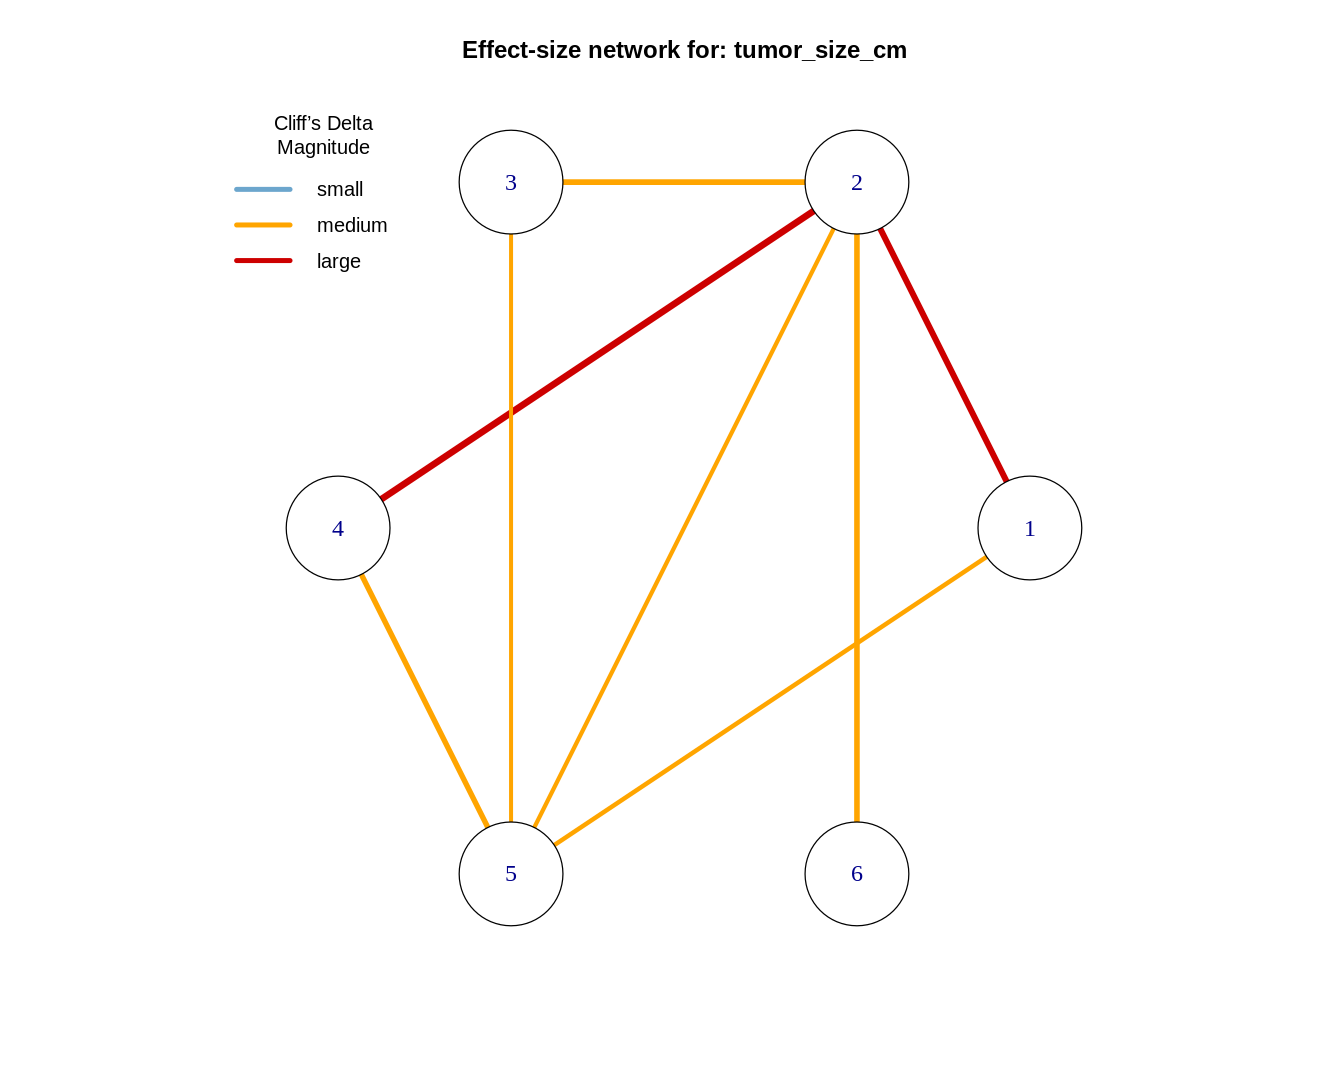

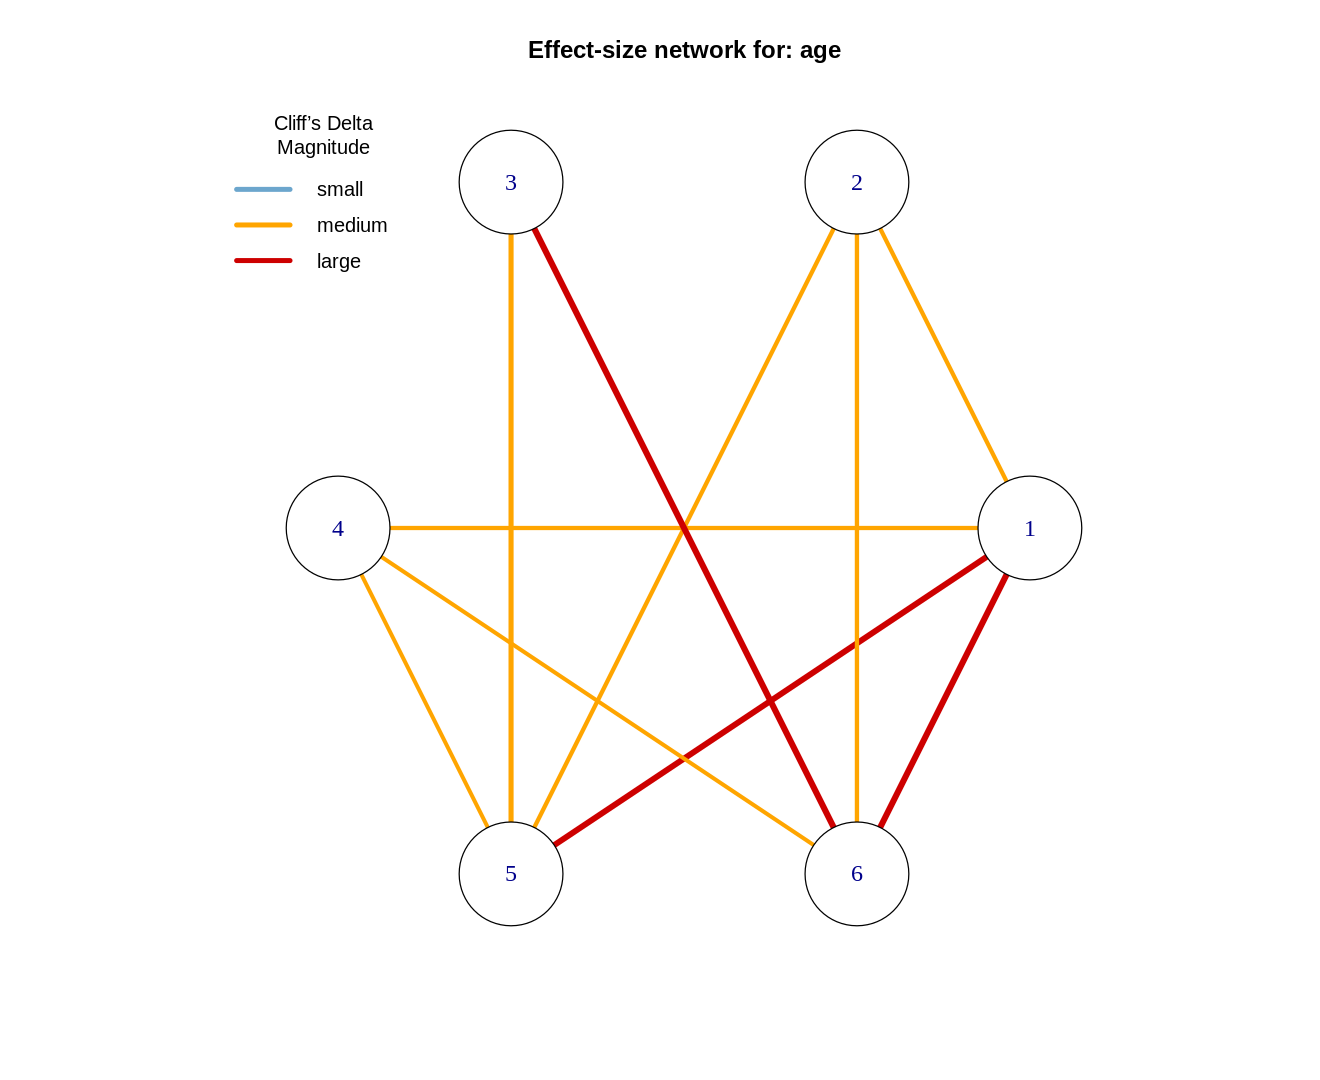

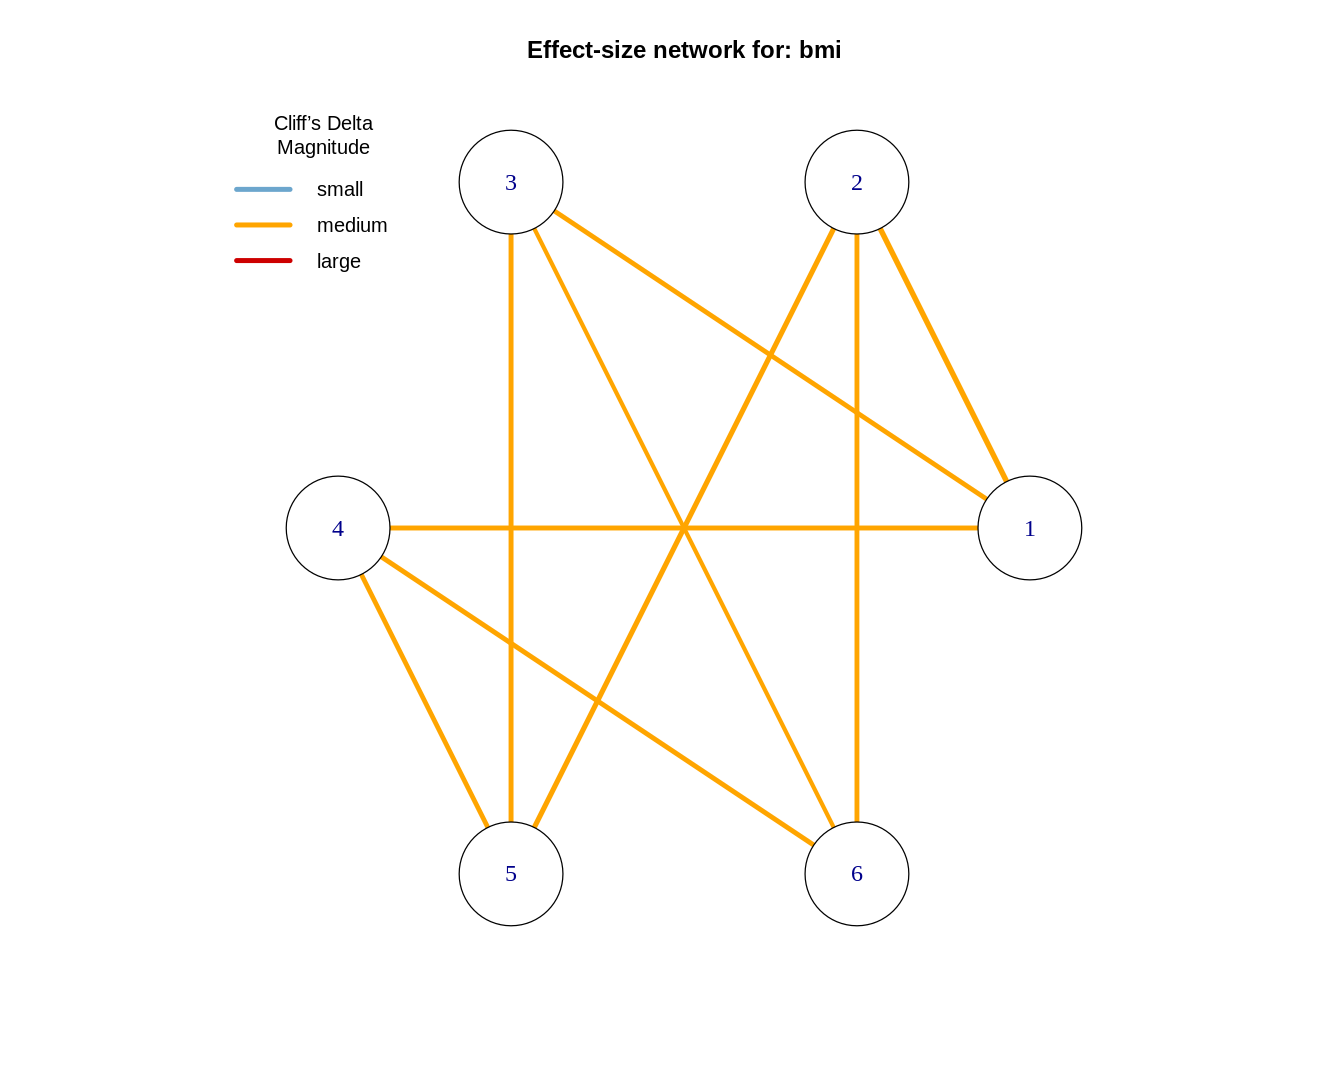

In [ ]:
plot_effect_network(delta_df, "tumor_size_cm")
plot_effect_network(delta_df, "age")
plot_effect_network(delta_df, "bmi")


In [ ]:
clin_cluster <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE)


In [ ]:
clin_cluster$cluster_knn <- factor(clin_cluster$cluster_knn)


In [ ]:
install.packages("ggpubr", dependencies = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(dplyr)
library(ggplot2)
library(ggpubr)

clin_noNA <- clin_cluster %>%
  filter(!is.na(cluster_knn))

clin_noNA$cluster_knn <- factor(clin_noNA$cluster_knn)


Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


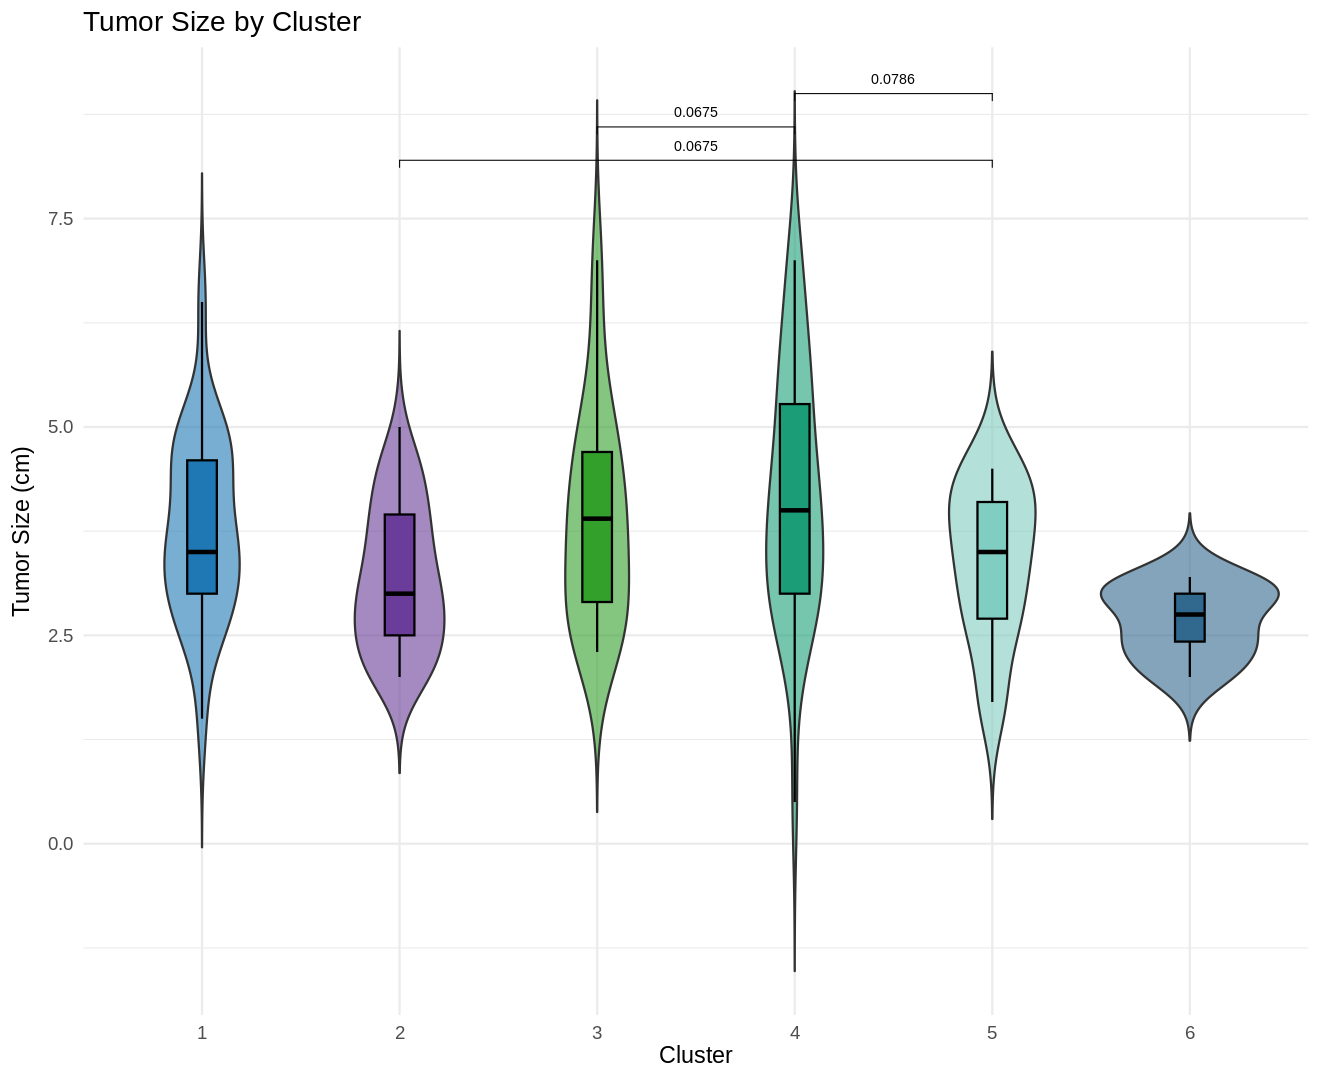

In [ ]:
library(dplyr)
library(ggplot2)
library(ggpubr)

# 1) Remove rows with NA in the cluster column
clin_noNA <- clin_cluster %>%
  filter(!is.na(cluster_knn))

clin_noNA$cluster_knn <- factor(clin_noNA$cluster_knn)

# 2) Pairs extracted from the Dunn post-hoc results
sig_tumor <- data.frame(
  group1     = c("2", "3", "4"),
  group2     = c("5", "4", "5"),
  p.adj      = c(0.0675, 0.0675, 0.0786),
  y.position = c(8.2, 8.6, 9.0)
)

# 3) New color palette (NO red/pink/brown)
my_cols <- c(
  "#1f78b4",  # deep blue
  "#6a3d9a",  # violet/purple
  "#33a02c",  # cool green
  "#1b9e77",  # teal-green
  "#80cdc1",  # soft teal-blue
  "#31688e"   # dark steel blue
)

# 4) Violin + boxplot
p_tumor <- ggplot(clin_noNA,
                  aes(x = cluster_knn, y = tumor_size_cm, fill = cluster_knn)) +
  geom_violin(trim = FALSE, alpha = 0.6) +
  geom_boxplot(width = 0.15, outlier.size = 0.8, color = "black") +
  scale_fill_manual(values = my_cols) +
  labs(title = "Tumor Size by Cluster",
       x = "Cluster",
       y = "Tumor Size (cm)") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none")

# 5) Add significance bars
p_tumor +
  stat_pvalue_manual(
    sig_tumor,
    label = "p.adj",
    tip.length = 0.01,
    size = 3
  )


#survival analysis

In [ ]:
install.packages("survminer", dependencies = TRUE)
library(survival)
library(survminer)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bdsmatrix’, ‘bbmle’, ‘fastGHQuad’, ‘lsoda’, ‘assertthat’, ‘deSolve’, ‘mstate’, ‘muhaz’, ‘rstpm2’, ‘statmod’, ‘flexsurv’, ‘cmprsk’




In [ ]:
library(survival)
library(survminer)

# Event: deceased = 1, living = 0
clin$event <- ifelse(clin$vital_status == "Deceased", 1, 0)

# Survival object
surv_obj <- Surv(time = clin$follow_up_days, event = clin$event)


In [ ]:
surv_obj


  [1]  426+  249  1035   610  1228+ 1046+  422  1189+  311   864+  594+  602 
 [13]    3+  761   369+  765+  300     0+  743   191   794+  399+  270+    5+
 [25]  912   715   344   376   594   287   276   261+  679+  723   716+  632 
 [37]  740+  118   403   190   211   243    68   785+  256+   90   817+  549+
 [49]   11   369+   NA?  466+   78+  330+  313+  246    NA   240+  225    20 
 [61]  290   300+  356+  288   196   279  1364+ 1098+  323   599   652+ 1001 
 [73] 1006   425   795   688+  901   469    NA?  880+ 1068+  616+  240   678+
 [85]  640+  460   142   400   454   734   667+  810  1049+  435   108   335 
 [97]  454+  857+  186   359+  371   479+  358   754+  458   294   430   664+
[109]  609+   70   122   122   708+   58    NA?  348    NA?  733+   32+  398 
[121]  285   122   285    39   457   315+  728+  701   377+  483+   20   696+
[133]  696+  259+  368+  305   348   303     1     8 

In [ ]:
table(clin$vital_status, clin$event)


          
            0  1
  Deceased  0 77
  Living   59  0

In [ ]:

try(detach("package:survminer", unload = TRUE, force = TRUE), silent = TRUE)
try(unloadNamespace("survminer"), silent = TRUE)

try(remove.packages("survminer"), silent = TRUE)

unlink("/usr/local/lib/R/site-library/survminer", recursive = TRUE, force = TRUE)

install.packages("survminer", dependencies = TRUE)
library(survminer)


Removing package from ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”
Warning message in get(method, envir = home):
“internal error 1 in R_decompress1 with libdeflate”

Attaching package: ‘survminer’


The following obje

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”
Ignoring unknown labels:
• colour : "Cluster"


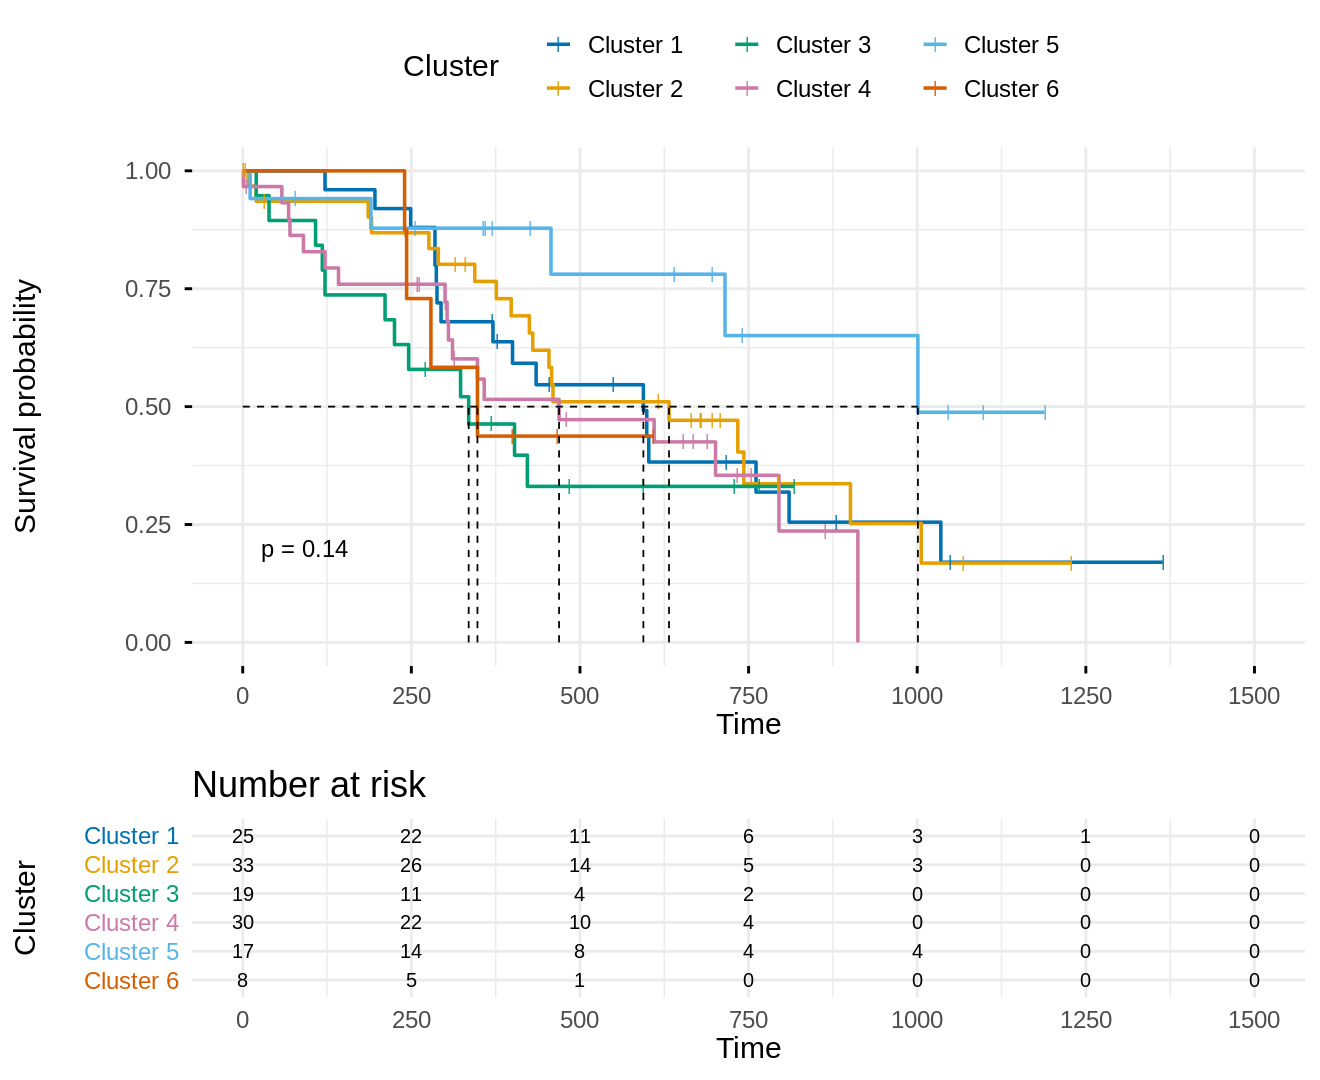

In [ ]:
library(survival)
library(ggplot2)


clin$cluster_knn <- factor(clin$cluster_knn)

palette_vibrant <- c(
  "#0072B2", # Bright Blue
  "#E69F00", # Vivid Orange
  "#009E73", # Vibrant Green
  "#CC79A7", # Strong Pink/Purple
  "#56B4E9", # Sky Blue
  "#D55E00"  # Brick Orange
)


km_cols <- palette_vibrant[seq_along(levels(clin$cluster_knn))]


fit_km <- survfit(Surv(follow_up_days, event) ~ cluster_knn, data = clin)


options(repr.plot.width = 11, repr.plot.height = 9)

# KM plot
km_plot <- ggsurvplot(
  fit_km,
  data = clin,
  pval = TRUE,
  conf.int = FALSE,
  risk.table = TRUE,
  risk.table.height = 0.30,
  risk.table.fontsize = 4.2,
  surv.median.line = "hv",
  palette = km_cols,
  ggtheme = theme_minimal(base_size = 18),
  censor.shape = 124,
  censor.size = 3,
  legend.title = "Cluster",
  legend.labs = paste0("Cluster ", levels(clin$cluster_knn)),
  break.time.by = 250
)

km_plot


In [ ]:

library(survival)
library(survminer)
library(dplyr)

# 1) Start from your merged clinical + cluster table
df_surv <- clin

# 2) Keep only rows with non-missing follow-up, status and cluster
df_surv <- df_surv %>%
  filter(!is.na(follow_up_days),
         !is.na(vital_status),
         !is.na(cluster_knn))

# 3) Create event indicator: 1 = Deceased, 0 = Living
df_surv <- df_surv %>%
  mutate(status = ifelse(vital_status == "Deceased", 1, 0))

# 4) Make sure cluster_knn is a factor (categorical)
df_surv$cluster_knn <- factor(df_surv$cluster_knn)

# 5) Survival object
surv_obj <- Surv(time = df_surv$follow_up_days,
                 event = df_surv$status)


In [ ]:
library(dplyr)
library(survival)

## 1) Cox model summary -> per-cluster table

s_cox <- summary(cox_fit)

coef_mat <- s_cox$coefficients
ci_mat   <- s_cox$conf.int

cox_df <- data.frame(
  level    = rownames(coef_mat),
  coef     = coef_mat[, "coef"],
  se_coef  = coef_mat[, "se(coef)"],
  z        = coef_mat[, "z"],
  p_value  = coef_mat[, "Pr(>|z|)"],
  HR       = ci_mat[, "exp(coef)"],
  HR_low95 = ci_mat[, "lower .95"],
  HR_up95  = ci_mat[, "upper .95"],
  row.names = NULL
)

# Extract cluster id from term name: "cluster_knn2" -> "2"
cox_df <- cox_df %>%
  mutate(
    cluster = gsub("cluster_knn", "", level)
  ) %>%
  select(-level)

# Define cluster levels (baseline = first level in df_surv$cluster_knn)
all_clusters <- levels(df_surv$cluster_knn)
baseline     <- all_clusters[1]

# Add baseline row for cluster 1 (HR = 1, coef = 0, p = NA)
baseline_row <- data.frame(
  coef     = 0,
  se_coef  = NA_real_,
  z        = NA_real_,
  p_value  = NA_real_,
  HR       = 1,
  HR_low95 = NA_real_,
  HR_up95  = NA_real_,
  cluster  = baseline,
  stringsAsFactors = FALSE
)

cox_full <- bind_rows(baseline_row, cox_df) %>%
  mutate(
    cluster  = factor(cluster, levels = all_clusters),
    p_value  = round(p_value, 4),
    HR       = round(HR, 3),
    HR_low95 = round(HR_low95, 3),
    HR_up95  = round(HR_up95, 3),
    coef     = round(coef, 3),
    se_coef  = round(se_coef, 3),
    z        = round(z, 3),
    sig_0_05 = ifelse(!is.na(p_value) & p_value < 0.05, "YES", "NO"),
    sig_0_10 = ifelse(!is.na(p_value) & p_value < 0.10, "YES", "NO")
  ) %>%
  arrange(cluster)


## 2) Kaplan–Meier summary -> per-cluster table

fit_km_cluster <- survfit(surv_obj ~ cluster_knn, data = df_surv)

sf      <- summary(fit_km_cluster)
km_raw  <- as.data.frame(sf$table)

# Determine which column is sample size
n_col <- if ("n" %in% colnames(km_raw)) {
  "n"
} else if ("n.start" %in% colnames(km_raw)) {
  "n.start"
} else {
  "records"
}

km_df <- data.frame(
  cluster = gsub("cluster_knn=", "", rownames(km_raw)),
  n       = km_raw[[n_col]],
  median  = km_raw[, "median"],
  med_low = km_raw[, "0.95LCL"],
  med_up  = km_raw[, "0.95UCL"],
  row.names = NULL
) %>%
  mutate(
    cluster = factor(cluster, levels = all_clusters)
  )


## 3) Merge KM + Cox into a single table

combined_table <- km_df %>%
  left_join(cox_full, by = "cluster") %>%
  arrange(cluster)

combined_table


cluster,n,median,med_low,med_up,coef,se_coef,z,p_value,HR,HR_low95,HR_up95,sig_0_05,sig_0_10
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,25,594,371,NA,0.000,NA,NA,NA,1.000,NA,NA,NO,NO
2,33,632,430,NA,-0.077,0.335,-0.229,0.8189,0.926,0.481,1.785,NO,NO
3,19,335,225,NA,0.458,0.383,1.197,0.2311,1.581,0.747,3.347,NO,NO
4,30,469,305,NA,0.234,0.343,0.684,0.4942,1.264,0.645,2.476,NO,NO
5,17,1001,715,NA,-0.954,0.510,-1.872,0.0613,0.385,0.142,1.046,NO,YES
6,8,348,243,NA,0.275,0.563,0.489,0.6248,1.317,0.437,3.970,NO,NO


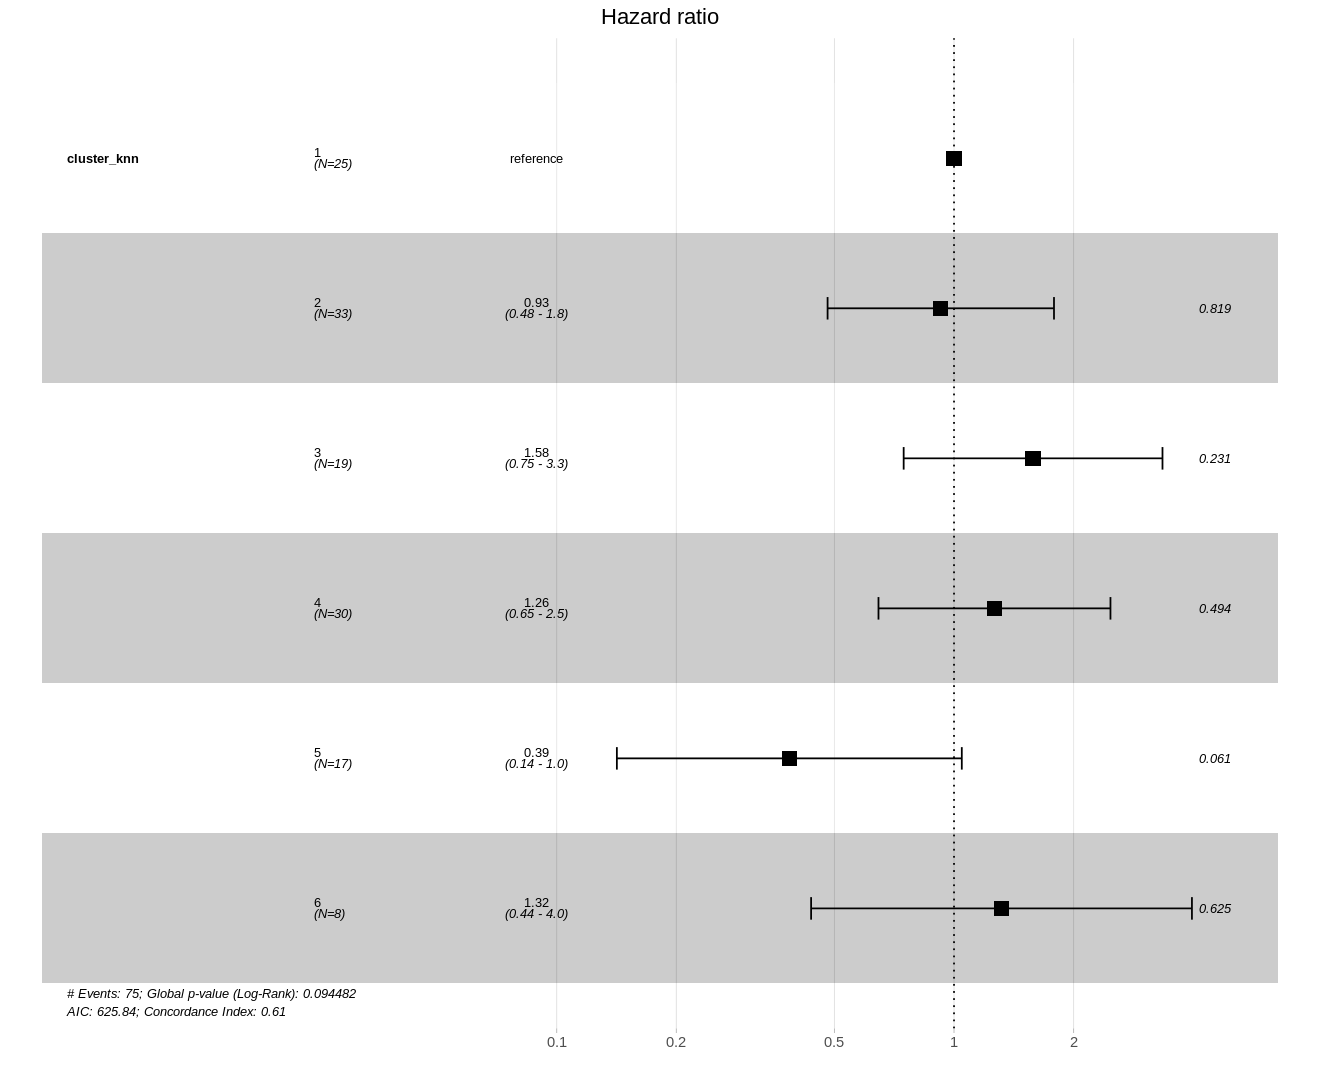

In [ ]:
ggforest(cox_fit, data = df_surv)


#ordinal

In [ ]:
## ---------- 0. Load data ----------

# Read merged clinical + cluster table
clin <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE)

# Make sure cluster_knn is a factor
clin$cluster_knn <- factor(clin$cluster_knn)

## ---------- 1. Define ordinal variables ----------

ordinal_vars <- c("pn_factor",
                  "pt_factor",
                  "pm_factor",
                  "cm_factor",
                  "residual_tumor_ord")

## ---------- 2. Recode them as ordered factors (with correct level order) ----------

# NOTE: if some levels do not exist in your data, R will just ignore them.

clin$pn_factor <- factor(
  clin$pn_factor,
  levels = c("N0", "N1", "N2", "NX"),
  ordered = TRUE
)

clin$pt_factor <- factor(
  clin$pt_factor,
  levels = c("T0", "T1", "T2", "T3", "T4"),
  ordered = TRUE
)

clin$pm_factor <- factor(
  clin$pm_factor,
  levels = c("M0", "M1"),
  ordered = TRUE
)

clin$cm_factor <- factor(
  clin$cm_factor,
  levels = c("M0", "M1"),
  ordered = TRUE
)

clin$residual_tumor_ord <- factor(
  clin$residual_tumor_ord,
  levels = c("R0", "R1", "R2", "RX"),
  ordered = TRUE
)



In [ ]:
library(dplyr)

ordinal_vars <- c(
  "pn_factor",
  "pt_factor",
  "pm_factor",
  "cm_factor",
  "residual_tumor_ord"
)

ordinal_kw_list <- list()

for (var in ordinal_vars) {

  x <- clin[[var]]
  g <- clin$cluster_knn

  ok <- complete.cases(x, g)
  x_ok <- x[ok]
  g_ok <- g[ok]

  x_num <- as.numeric(x_ok)

  if (length(unique(x_num)) > 1 && length(unique(g_ok)) > 1) {

    test_res <- kruskal.test(x_num ~ g_ok)

    ordinal_kw_list[[var]] <- data.frame(
      variable         = var,
      chi_squared      = unname(test_res$statistic),
      df               = unname(test_res$parameter),
      p_value          = test_res$p.value,
      stringsAsFactors = FALSE
    )

  } else {
    ordinal_kw_list[[var]] <- data.frame(
      variable         = var,
      chi_squared      = NA_real_,
      df               = NA_real_,
      p_value          = NA_real_,
      stringsAsFactors = FALSE
    )
  }
}

ordinal_kw_df <- bind_rows(ordinal_kw_list)

ordinal_kw_df <- ordinal_kw_df %>%
  mutate(
    p_fdr          = p.adjust(p_value, method = "fdr"),
    significant_0_05_raw = ifelse(p_value < 0.05, "YES", "NO"),
    significant_0_05_fdr = ifelse(p_fdr  < 0.05, "YES", "NO")
  )

ordinal_kw_df


variable,chi_squared,df,p_value,p_fdr,significant_0_05_raw,significant_0_05_fdr
<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
pn_factor,4.248242,5,0.5142565,0.5142565,NO,NO
pt_factor,12.694393,5,0.0264173,0.1320865,YES,NO
pm_factor,8.035216,5,0.1543055,0.2915123,NO,NO
cm_factor,7.677835,5,0.1749074,0.2915123,NO,NO
residual_tumor_ord,5.873171,5,0.3187563,0.3984453,NO,NO


In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# Shared data preparation
df_pt <- clin %>%
  filter(!is.na(pt_factor), !is.na(cluster_knn)) %>%
  count(cluster_knn, pt_factor) %>%
  group_by(cluster_knn) %>%
  mutate(prop = n / sum(n))


[1] "T0" "T1" "T2" "T3" "T4"

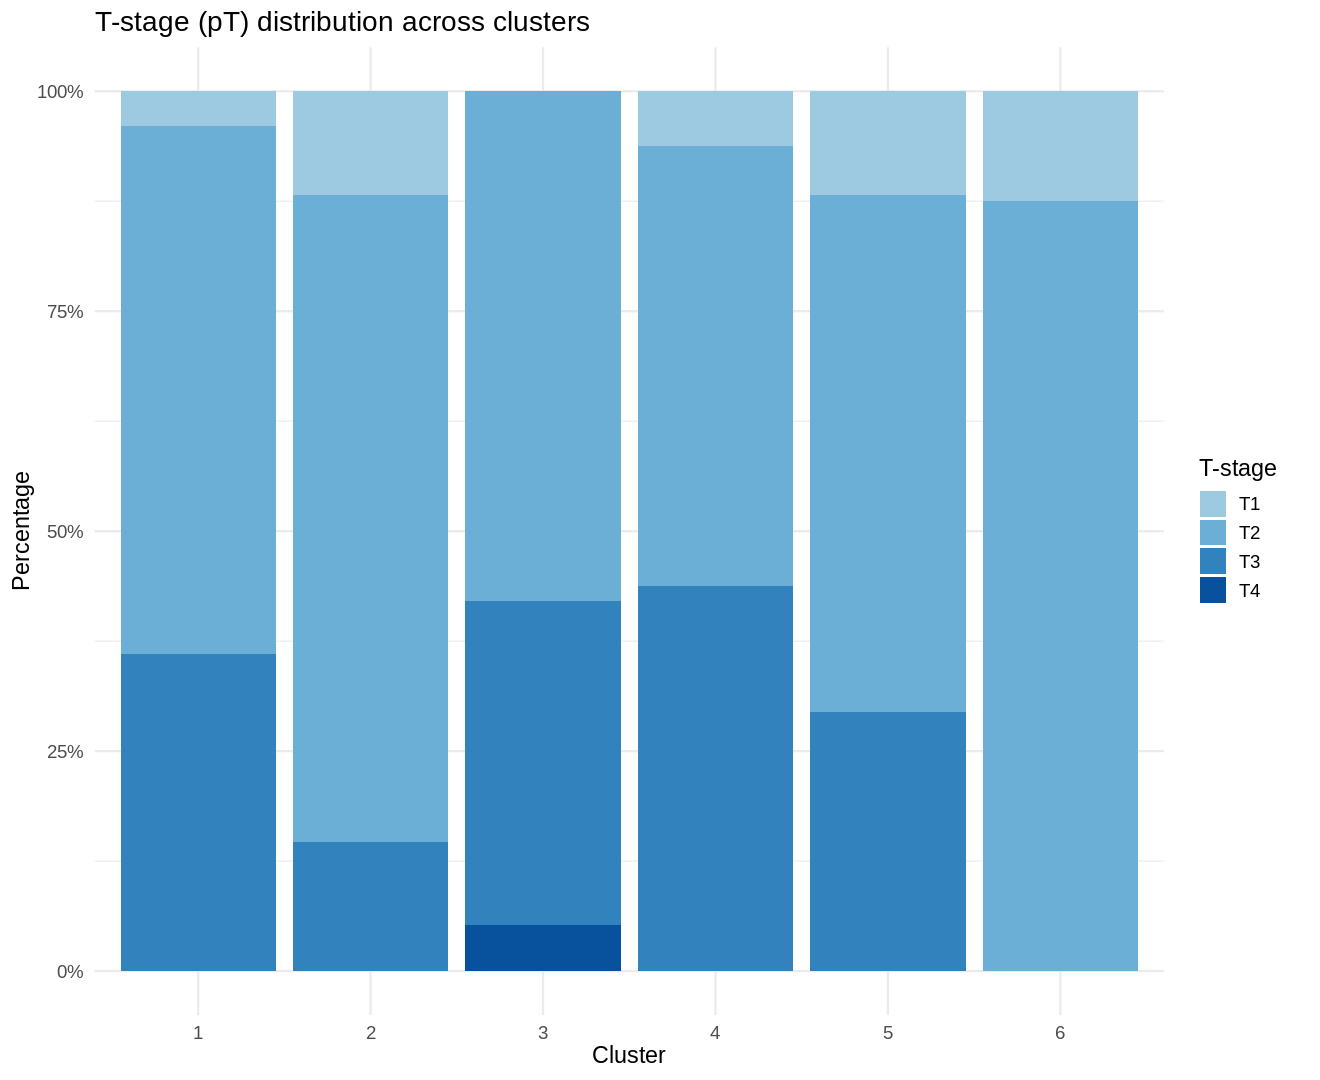

In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# Check levels (just to be sure)
levels(clin$pt_factor)
# Should be: "T0" "T1" "T2" "T3" "T4"

# Biologically ordered palette: low stage -> light, high stage -> dark
pt_factor_cols <- c(
  "T0" = "#deebf7",  # very light blue (in situ / minimal)
  "T1" = "#9ecae1",  # light blue
  "T2" = "#6baed6",  # medium blue
  "T3" = "#3182bd",  # darker blue
  "T4" = "#08519c"   # darkest blue (highest T)
)

# Data prep
df_pt <- clin %>%
  filter(!is.na(pt_factor), !is.na(cluster_knn)) %>%
  count(cluster_knn, pt_factor) %>%
  group_by(cluster_knn) %>%
  mutate(prop = n / sum(n))

# Plot
ggplot(df_pt, aes(x = cluster_knn, y = prop, fill = pt_factor)) +
  geom_bar(stat = "identity") +
  scale_y_continuous(labels = percent_format()) +
  scale_fill_manual(values = pt_factor_cols) +
  labs(
    title = "T-stage (pT) distribution across clusters",
    x = "Cluster",
    y = "Percentage",
    fill = "T-stage"
  ) +
  theme_minimal(base_size = 14)


#nominal

In [ ]:
library(dplyr)

df <- clin

nominal_vars <- c(
  "sex",
  "race",
  "tumor_site",
  "tumor_necrosis",
  "lymph_vascular_invasion",
  "perineural_invasion",
  "vital_status",
  "cause_of_death",
  "tumor_stage_pathological",
  "alcohol_consumption",
  "tobacco_smoking_history",
  "is_this_patient_lost_to_follow_up"
)

results_list <- list()

for (v in nominal_vars) {
  tbl <- table(df[[v]], df$cluster_knn)

  if (nrow(tbl) == 2 && ncol(tbl) == 2 && any(tbl < 5)) {
    test <- fisher.test(tbl)
    test_type <- "Fisher exact (2x2)"
  } else if (any(tbl < 5)) {
    test <- chisq.test(tbl, simulate.p.value = TRUE, B = 10000)
    test_type <- "Chi-square (simulated)"
  } else {
    test <- chisq.test(tbl)
    test_type <- "Chi-square"
  }

  results_list[[v]] <- data.frame(
    variable        = v,
    test_type       = test_type,
    statistic       = if (!is.null(test$statistic)) unname(test$statistic) else NA_real_,
    p_value         = test$p.value,
    significant_0_05 = ifelse(test$p.value < 0.05, "YES", "NO"),
    stringsAsFactors = FALSE
  )
}

nominal_results_df <- bind_rows(results_list)

nominal_results_df


Warning message in chisq.test(tbl, simulate.p.value = TRUE, B = 10000):
“cannot compute simulated p-value with zero marginals”
Warning message in chisq.test(tbl, simulate.p.value = TRUE, B = 10000):
“Chi-squared approximation may be incorrect”


variable,test_type,statistic,p_value,significant_0_05
<chr>,<chr>,<dbl>,<dbl>,<chr>
sex,Chi-square (simulated),5.024842,0.43175682,NO
race,Chi-square (simulated),NaN,NaN,NA
tumor_site,Chi-square (simulated),15.435412,0.78322168,NO
tumor_necrosis,Chi-square (simulated),10.060786,0.07019298,NO
lymph_vascular_invasion,Chi-square (simulated),6.810897,0.75572443,NO
perineural_invasion,Chi-square (simulated),26.735504,0.00459954,YES
vital_status,Chi-square (simulated),7.209204,0.21627837,NO
cause_of_death,Chi-square (simulated),49.110468,0.20067993,NO
tumor_stage_pathological,Chi-square (simulated),30.962613,0.19148085,NO


In [ ]:
clin$tumor_site_bin <- ifelse(clin$tumor_site == "head",
                              "head",
                              "non-head")

clin$tumor_site_bin <- factor(clin$tumor_site_bin)


In [ ]:
clin$alcohol_bin <- dplyr::case_when(
  clin$alcohol_consumption %in% c(
    "Lifelong non-drinker",
    "Consumed alcohol in the past, but currently a non-drinker"
  ) ~ "non-drinker",

  clin$alcohol_consumption %in% c(
    "Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women"
  ) ~ "moderate",

  clin$alcohol_consumption %in% c(
    "Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women"
  ) ~ "heavy",

  TRUE ~ NA_character_
)

clin$alcohol_bin <- factor(clin$alcohol_bin)


In [ ]:
clin$death_bin <- ifelse(clin$cause_of_death == "pancreatic carcinoma",
                         "pancreatic",
                         "non-pancreatic")

clin$death_bin <- factor(clin$death_bin)


In [ ]:
clin$smoking_bin <- dplyr::case_when(
  clin$tobacco_smoking_history %in% c(
    "Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime"
  ) ~ "never",

  clin$tobacco_smoking_history %in% c(
    "Current reformed smoker within past 15 years",
    "Current reformed smoker, more than 15 years",
    "Current reformed smoker, years unknown"
  ) ~ "former",

  clin$tobacco_smoking_history %in% c(
    "Current smoker: Includes daily and non-daily smokers"
  ) ~ "current",

  TRUE ~ NA_character_
)

clin$smoking_bin <- factor(clin$smoking_bin)


In [ ]:
library(dplyr)

# Tumor site
clin$tumor_site_bin <- ifelse(clin$tumor_site == "head", "head", "non-head")
clin$tumor_site_bin <- factor(clin$tumor_site_bin)

# Alcohol
clin$alcohol_bin <- dplyr::case_when(
  clin$alcohol_consumption %in% c(
    "Lifelong non-drinker",
    "Consumed alcohol in the past, but currently a non-drinker"
  ) ~ "non-drinker",
  clin$alcohol_consumption %in% c(
    "Alcohol consumption equal to or less than 2 drinks per day for men and 1 drink or less per day for women"
  ) ~ "moderate",
  clin$alcohol_consumption %in% c(
    "Alcohol consumption more than 2 drinks per day for men and more than 1 drink per day for women"
  ) ~ "heavy",
  TRUE ~ NA_character_
)
clin$alcohol_bin <- factor(clin$alcohol_bin)

# Cause of death
clin$death_bin <- ifelse(clin$cause_of_death == "pancreatic carcinoma",
                         "pancreatic", "non-pancreatic")
clin$death_bin <- factor(clin$death_bin)

# Smoking
clin$smoking_bin <- dplyr::case_when(
  clin$tobacco_smoking_history %in% c(
    "Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime"
  ) ~ "never",

  clin$tobacco_smoking_history %in% c(
    "Current reformed smoker within past 15 years",
    "Current reformed smoker, more than 15 years",
    "Current reformed smoker, years unknown"
  ) ~ "former",

  clin$tobacco_smoking_history %in% c(
    "Current smoker: Includes daily and non-daily smokers"
  ) ~ "current",

  TRUE ~ NA_character_
)
clin$smoking_bin <- factor(clin$smoking_bin)


In [ ]:
nominal_vars <- c(
  "tumor_site_bin",
  "alcohol_bin",
  "death_bin",
  "smoking_bin"
)


In [ ]:
library(dplyr)

bin_nominal_vars <- c(
  "tumor_site_bin",
  "alcohol_bin",
  "death_bin",
  "smoking_bin"
)

bin_results_list <- list()

for (var in bin_nominal_vars) {

  df_tmp <- clin %>%
    select(cluster_knn, all_of(var)) %>%
    filter(!is.na(cluster_knn), !is.na(.data[[var]]))

  tbl <- table(df_tmp$cluster_knn, df_tmp[[var]])

  if (ncol(tbl) == 2) {
    test <- fisher.test(tbl)
    test_type <- "Fisher exact"
    stat_val <- NA_real_
  } else {
    test <- chisq.test(tbl, simulate.p.value = TRUE, B = 10000)
    test_type <- "Chi-square (simulated)"
    stat_val <- unname(test$statistic)
  }

  bin_results_list[[var]] <- data.frame(
    variable        = var,
    test_type       = test_type,
    statistic       = stat_val,
    p_value         = test$p.value,
    significant_0_05 = ifelse(test$p.value < 0.05, "YES", "NO"),
    stringsAsFactors = FALSE
  )
}

bin_nominal_results_df <- bind_rows(bin_results_list)

bin_nominal_results_df


variable,test_type,statistic,p_value,significant_0_05
<chr>,<chr>,<dbl>,<dbl>,<chr>
tumor_site_bin,Fisher exact,NA,0.1776142,NO
alcohol_bin,Chi-square (simulated),15.35874,0.1149885,NO
death_bin,Fisher exact,NA,0.3055991,NO
smoking_bin,Chi-square (simulated),23.54818,0.0079992,YES


In [ ]:
library(dplyr)

pairwise_nominal <- function(df, var, cluster_var = "cluster_knn") {

  clust_levels <- levels(df[[cluster_var]])
  pairs <- combn(clust_levels, 2, simplify = FALSE)

  results <- list()

  for (p in pairs) {
    g1 <- p[1]
    g2 <- p[2]

    sub <- df %>% filter(.data[[cluster_var]] %in% c(g1, g2))

    tbl <- table(sub[[var]], sub[[cluster_var]])

    test <- fisher.test(tbl)

    results[[paste(g1, g2, sep = "_vs_")]] <- data.frame(
      variable   = var,
      cluster1   = g1,
      cluster2   = g2,
      p_value    = test$p.value
    )
  }

  bind_rows(results)
}

# Run for smoking_bin
pairwise_smoking <- pairwise_nominal(clin, "smoking_bin")
pairwise_smoking


variable,cluster1,cluster2,p_value
<chr>,<chr>,<chr>,<dbl>
smoking_bin,1,2,0.02856001
smoking_bin,1,3,0.05181567
smoking_bin,1,4,0.06296170
smoking_bin,1,5,0.58500067
smoking_bin,1,6,0.32236284
smoking_bin,2,3,0.90697476
smoking_bin,2,4,0.84761744
smoking_bin,2,5,0.01280069
smoking_bin,2,6,0.36222502


In [ ]:
pairwise_peri <- pairwise_nominal(clin, "perineural_invasion")
pairwise_peri


variable,cluster1,cluster2,p_value
<chr>,<chr>,<chr>,<dbl>
perineural_invasion,1,2,0.193707281
perineural_invasion,1,3,1.000000000
perineural_invasion,1,4,0.230363369
perineural_invasion,1,5,1.000000000
perineural_invasion,1,6,0.018314905
perineural_invasion,2,3,0.085632535
perineural_invasion,2,4,0.667887668
perineural_invasion,2,5,0.266602982
perineural_invasion,2,6,0.001200074


In [ ]:
pairwise_smoking$p_adj <- p.adjust(pairwise_smoking$p_value, method = "BH")
pairwise_peri$p_adj   <- p.adjust(pairwise_peri$p_value, method = "BH")


In [ ]:
pairwise_smoking
pairwise_peri


variable,cluster1,cluster2,p_value,p_adj
<chr>,<chr>,<chr>,<dbl>,<dbl>
smoking_bin,1,2,0.02856001,0.1428001
smoking_bin,1,3,0.05181567,0.1554470
smoking_bin,1,4,0.06296170,0.1574043
smoking_bin,1,5,0.58500067,0.7312508
smoking_bin,1,6,0.32236284,0.5372714
smoking_bin,2,3,0.90697476,0.9069748
smoking_bin,2,4,0.84761744,0.9069748
smoking_bin,2,5,0.01280069,0.1355257
smoking_bin,2,6,0.36222502,0.5433375


variable,cluster1,cluster2,p_value,p_adj
<chr>,<chr>,<chr>,<dbl>,<dbl>
perineural_invasion,1,2,0.193707281,0.39990447
perineural_invasion,1,3,1.000000000,1.00000000
perineural_invasion,1,4,0.230363369,0.39990447
perineural_invasion,1,5,1.000000000,1.00000000
perineural_invasion,1,6,0.018314905,0.05494472
perineural_invasion,2,3,0.085632535,0.21408134
perineural_invasion,2,4,0.667887668,0.83485958
perineural_invasion,2,5,0.266602982,0.39990447
perineural_invasion,2,6,0.001200074,0.01800112


In [ ]:
library(dplyr)
library(ggplot2)
library(scales)

# Make sure factors are set
clin$cluster_knn <- factor(clin$cluster_knn)

clin$smoking_bin <- factor(
  clin$smoking_bin,
  levels = c("never", "former", "current")
)

# Adapt levels to your data order if needed
clin$perineural_invasion <- factor(
  clin$perineural_invasion,
  levels = c("Not identified", "Present", "Indetermite")
)


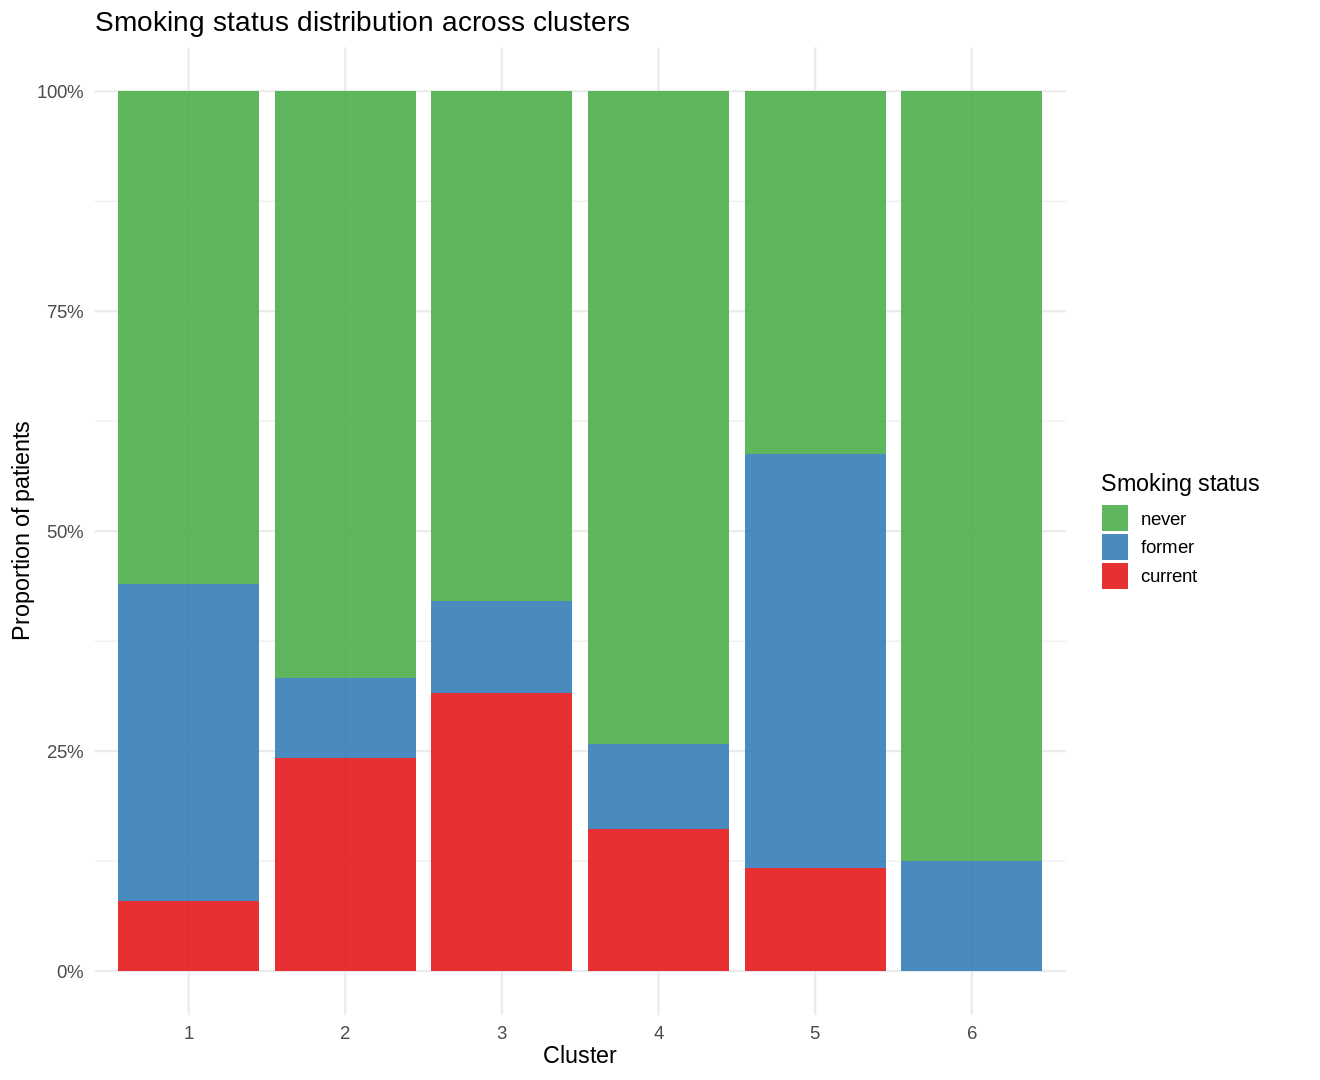

In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# New smoking color palette (scientifically intuitive)
smoking_cols <- c(
  "current" = "#e41a1c",   # bright red
  "former"  = "#377eb8",   # blue
  "never"   = "#4daf4a"    # green
)

df_smoke <- clin %>%
  filter(!is.na(smoking_bin), !is.na(cluster_knn)) %>%
  count(cluster_knn, smoking_bin) %>%
  group_by(cluster_knn) %>%
  mutate(prop = n / sum(n))

ggplot(df_smoke, aes(x = cluster_knn, y = prop, fill = smoking_bin)) +
  geom_col(alpha = 0.9) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  scale_fill_manual(values = smoking_cols) +
  labs(
    title = "Smoking status distribution across clusters",
    x = "Cluster",
    y = "Proportion of patients",
    fill = "Smoking status"
  ) +
  theme_minimal(base_size = 14)


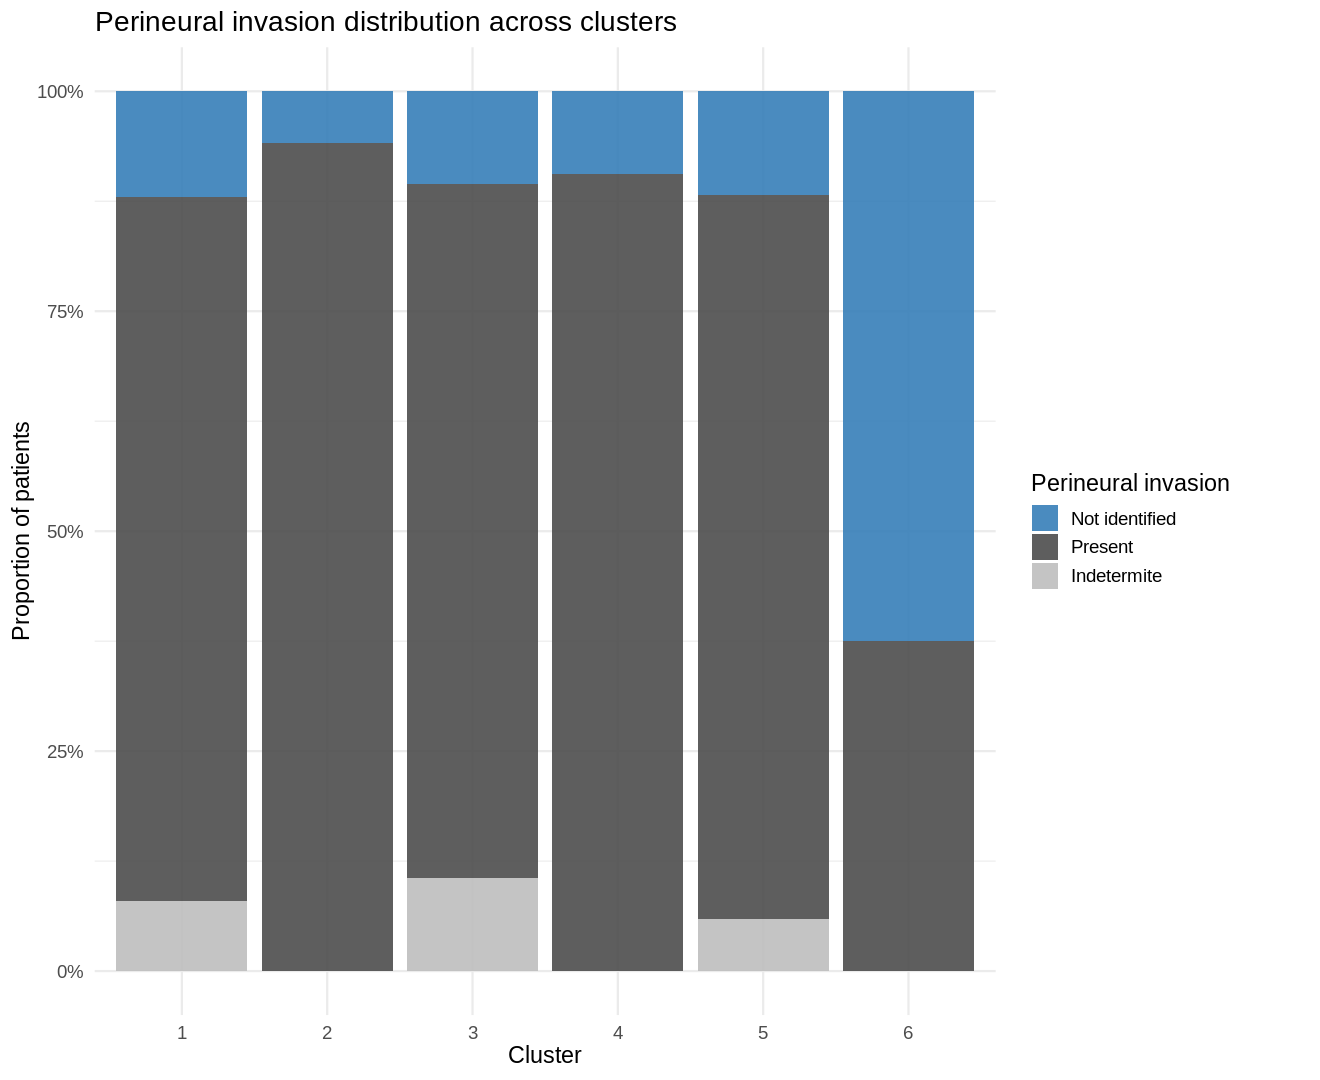

In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# Final clinically-clean color palette
peri_cols <- c(
  "Not identified" = "#377eb8",  # blue
  "Present"        = "#4d4d4d",  # dark gray
  "Indetermite"    = "#bdbdbd"   # light gray
)

df_peri <- clin %>%
  filter(!is.na(perineural_invasion), !is.na(cluster_knn)) %>%
  count(cluster_knn, perineural_invasion) %>%
  group_by(cluster_knn) %>%
  mutate(prop = n / sum(n))

ggplot(df_peri, aes(x = cluster_knn, y = prop, fill = perineural_invasion)) +
  geom_col(alpha = 0.9) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  scale_fill_manual(values = peri_cols) +
  labs(
    title = "Perineural invasion distribution across clusters",
    x = "Cluster",
    y = "Proportion of patients",
    fill = "Perineural invasion"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
install.packages("viridis")
library(viridis)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




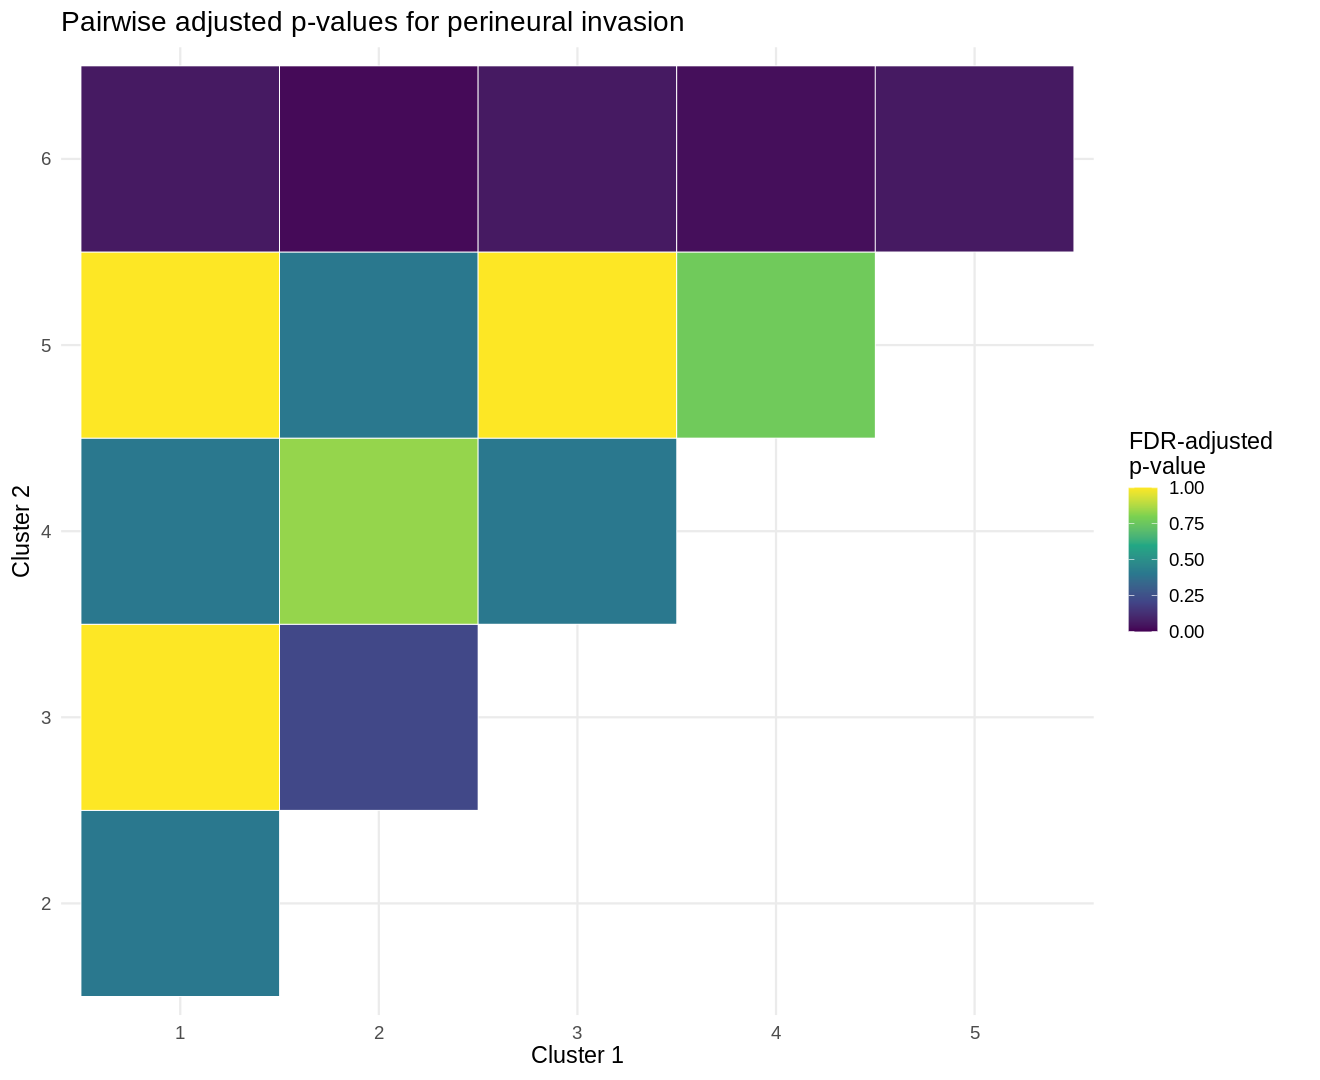

In [ ]:
pairwise_peri$cluster1 <- factor(pairwise_peri$cluster1,
                                 levels = levels(clin$cluster_knn))
pairwise_peri$cluster2 <- factor(pairwise_peri$cluster2,
                                 levels = levels(clin$cluster_knn))

ggplot(pairwise_peri, aes(x = cluster1, y = cluster2, fill = p_adj)) +
  geom_tile(color = "white") +
  scale_fill_viridis_c(
    option = "viridis",
    limits = c(0, 1),
    name   = "FDR-adjusted\np-value"
  ) +
  labs(
    title = "Pairwise adjusted p-values for perineural invasion",
    x = "Cluster 1",
    y = "Cluster 2"
  ) +
  theme_minimal(base_size = 14)


#label propagation / KNN classification

In [ ]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘e1071’, ‘ModelMetrics’, ‘pROC’, ‘recipes’




In [ ]:
install.packages("kableExtra")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘svglite’




In [ ]:
# ==============================
# Step 0 – Load libraries
# ==============================

# Core data wrangling
library(dplyr)
library(readr)

# Similarity / distance
library(cluster)

# Classification and evaluation
library(caret)

# Tables and plots
library(ggplot2)
library(knitr)
library(kableExtra)



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




In [ ]:
options(knitr.table.format = "simple")


In [ ]:
# ==============================
# Step 1 – Load omics similarity (SNF) and clinical data
# ==============================

# 1.1 Load SNF result (omics similarity)
fit <- readRDS("fit_result.rds")
W_omics <- fit$W                     # full SNF similarity: N x N
patient_ids <- rownames(W_omics)

# 1.2 Load clinical table
clin <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE)
clin$case_id <- as.character(clin$case_id)

# Align clinical table to omics order
clin <- clin[match(patient_ids, clin$case_id), ]
stopifnot(all(clin$case_id == patient_ids))

# 1.3 Define strong survival outcome label (good vs poor)
# Rules:
#   poor = Deceased OR (Living & follow_up < 365 days)
#   good = Living & follow_up >= 365 days

clin$vital_status   <- factor(clin$vital_status)
clin$follow_up_days <- as.numeric(clin$follow_up_days)

clin$outcome <- NA
clin$outcome[clin$vital_status == "Deceased"] <- "poor"
clin$outcome[clin$vital_status == "Living" & clin$follow_up_days < 400]  <- "poor"
clin$outcome[clin$vital_status == "Living" & clin$follow_up_days >= 400] <- "good"
clin$outcome <- factor(clin$outcome)

# 1.4 Keep only patients with a defined outcome (strong labels)
idx_strong <- which(!is.na(clin$outcome))
clin_s <- clin[idx_strong, ]
y <- droplevels(clin_s$outcome)

W_omics_s <- W_omics[idx_strong, idx_strong]

cat("Number of strong-outcome patients:", length(idx_strong), "\n")
cat("Dim W_omics_s:", paste(dim(W_omics_s), collapse = " x "), "\n")

# Optional: small table for outcome distribution
outcome_table <- as.data.frame(table(clin_s$outcome))
kable(outcome_table, caption = "Strong survival outcome distribution") %>%
  kable_styling(full_width = FALSE)


Number of strong-outcome patients: 133 
Dim W_omics_s: 133 x 133 


Warning message in kable_styling(., full_width = FALSE):
“Please specify format in kable. kableExtra can customize either HTML or LaTeX outputs. See https://haozhu233.github.io/kableExtra/ for details.”




Table: Strong survival outcome distribution

Var1    Freq
-----  -----
good      36
poor      97

Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `pn_num = as.numeric(pn_factor)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


,variable,min_value,max_value
,<chr>,<dbl>,<dbl>
age_z,age_z,-2.978790,1.903380
bmi_z,bmi_z,-2.313538,4.158890
tumor_size_z,tumor_size_z,-2.625659,2.877086
pn_num,pn_num,NaN,NaN
pt_num,pt_num,NaN,NaN
pm_num,pm_num,NaN,NaN
cm_num,cm_num,NaN,NaN
nec_num,nec_num,0.000000,1.000000
lymph_num,lymph_num,0.000000,1.000000


Dim W_clin_s: 133 x 133 


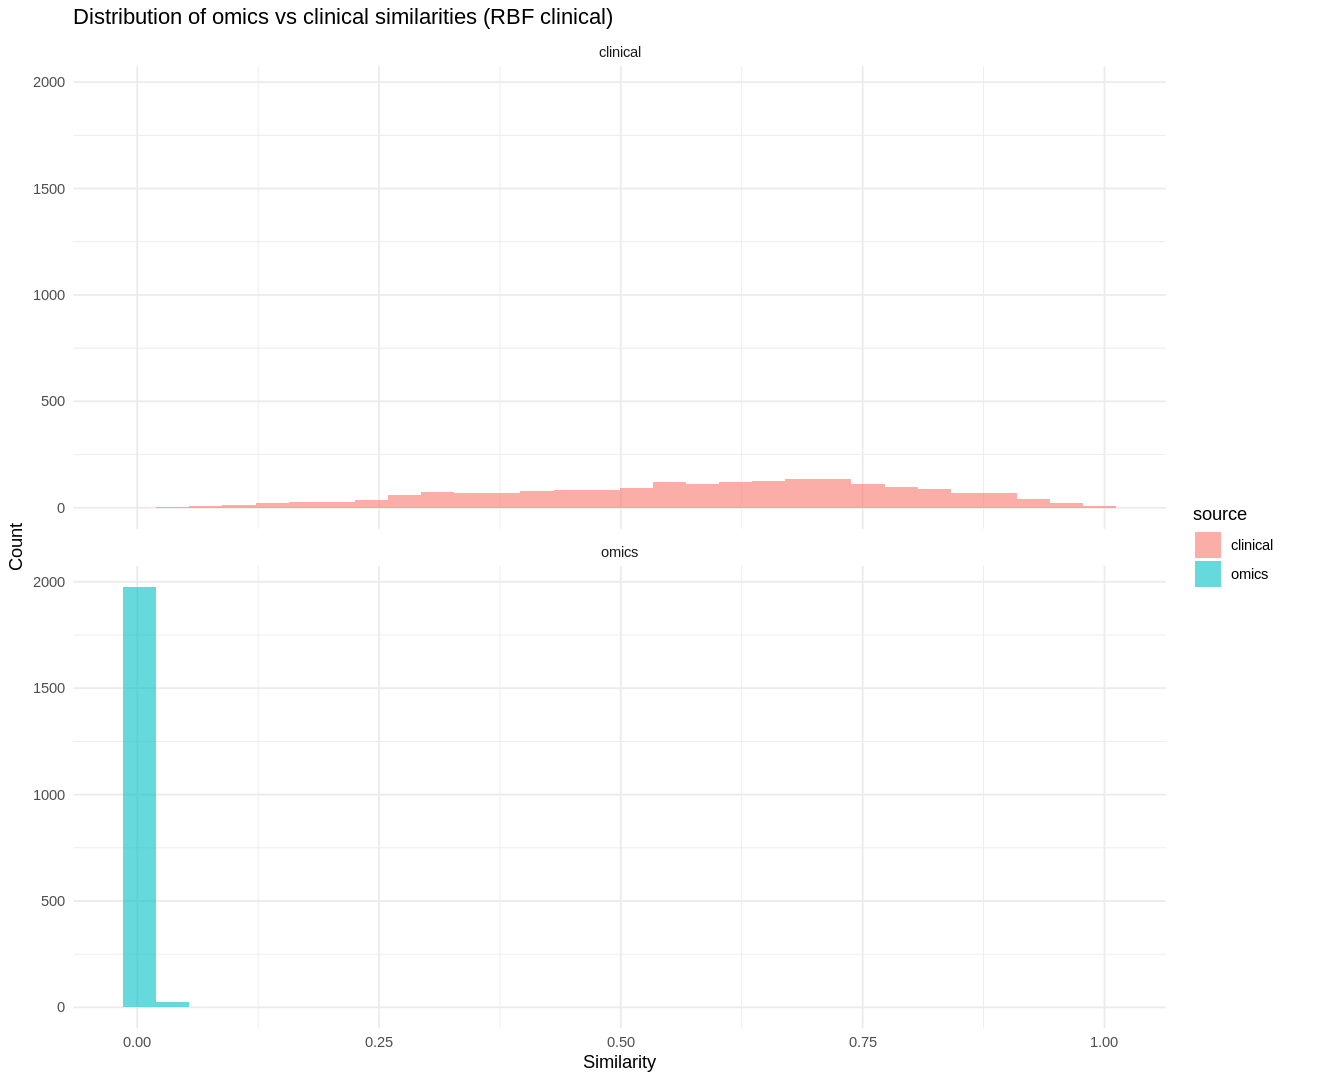

In [ ]:
# ==============================
# Step 2 – Clinical similarity (RBF on numeric encoding)
# ==============================

# clin_s: strong-outcome subset of your curated clin_cluster
# W_omics_s: corresponding omics similarity (already built)

# 2.1 Build numeric encoding of clinical features
clin_num <- clin_s %>%
  mutate(
    # numeric variables (z-score)
    age_z          = as.numeric(scale(age)),
    bmi_z          = as.numeric(scale(bmi)),
    tumor_size_z   = as.numeric(scale(tumor_size_cm)),

    # ordinal factors -> numeric ranks
    pn_num = as.numeric(pn_factor),
    pt_num = as.numeric(pt_factor),
    pm_num = as.numeric(pm_factor),
    cm_num = as.numeric(cm_factor),

    # binary encodings for categorical variables
    nec_num  = ifelse(tumor_necrosis == "Present", 1,
                 ifelse(tumor_necrosis == "Not identified", 0, NA)),
    lymph_num = ifelse(lymph_vascular_invasion == "Present", 1,
                  ifelse(lymph_vascular_invasion == "Not identified", 0, NA)),
    peri_num  = ifelse(perineural_invasion == "Present", 1,
                  ifelse(perineural_invasion == "Not identified", 0, NA))
  ) %>%
  select(
    age_z, bmi_z, tumor_size_z,
    pn_num, pt_num, pm_num, cm_num,
    nec_num, lymph_num, peri_num
  )

# 2.2 Simple imputation: replace remaining NAs by column means
for (j in seq_len(ncol(clin_num))) {
  col_mean <- mean(clin_num[[j]], na.rm = TRUE)
  clin_num[[j]][is.na(clin_num[[j]])] <- col_mean
}

# Optional: quick check of missingness and ranges
clin_num_summary <- data.frame(
  variable  = names(clin_num),
  min_value = sapply(clin_num, min),
  max_value = sapply(clin_num, max)
)
clin_num_summary  # plain df

# 2.3 Euclidean distance on numeric clinical matrix
dist_clin <- dist(clin_num, method = "euclidean")
D_clin    <- as.matrix(dist_clin)

# 2.4 Choose sigma as median of non-zero distances
d_vals  <- D_clin[upper.tri(D_clin)]
sigma_c <- median(d_vals[d_vals > 0], na.rm = TRUE)

# 2.5 Convert distance to similarity via RBF kernel
W_clin_s <- exp(- (D_clin^2) / (2 * sigma_c^2))

# 2.6 Normalize omics & clinical similarities into [0,1]
W_omics_s <- W_omics_s / max(W_omics_s, na.rm = TRUE)
W_clin_s  <- W_clin_s  / max(W_clin_s,  na.rm = TRUE)

cat("Dim W_clin_s:", paste(dim(W_clin_s), collapse = " x "), "\n")

# 2.7 Visualize similarity distributions (optional)
set.seed(123)
sample_omics <- sample(W_omics_s[upper.tri(W_omics_s)], 2000, replace = TRUE)
sample_clin  <- sample(W_clin_s[upper.tri(W_clin_s)],  2000, replace = TRUE)

sim_df <- data.frame(
  similarity = c(sample_omics, sample_clin),
  source     = rep(c("omics", "clinical"), each = 2000)
)

ggplot(sim_df, aes(x = similarity, fill = source)) +
  geom_histogram(alpha = 0.6, bins = 30, position = "identity") +
  facet_wrap(~ source, nrow = 2) +
  theme_minimal() +
  labs(
    title = "Distribution of omics vs clinical similarities (RBF clinical)",
    x = "Similarity",
    y = "Count"
  )


In [ ]:
# ==============================
# Step 3 – Weighted KNN predictor
# ==============================

predict_knn_weighted <- function(W, train_idx, test_idx, y_train, K = 9, eps = 1e-8) {
  # Ensure factor levels are consistent
  y_train <- droplevels(y_train)
  preds <- character(length(test_idx))

  for (i in seq_along(test_idx)) {
    ti <- test_idx[i]

    # Similarities from test sample to all training samples
    sims <- W[ti, train_idx]
    # Select top-K neighbors by similarity
    ord  <- order(sims, decreasing = TRUE)[1:K]

    neigh_labels <- y_train[ord]
    neigh_sims   <- sims[ord]

    # Replace negative or NA similarities with zero
    neigh_sims[neigh_sims < 0 | is.na(neigh_sims)] <- 0
    # Normalize weights
    w <- neigh_sims / (sum(neigh_sims) + eps)

    # Compute weighted vote per class
    score <- tapply(w, neigh_labels, sum)
    preds[i] <- names(which.max(score))
  }

  factor(preds, levels = levels(y_train))
}


In [ ]:
# ==============================
# Step 4 – Cross-validation helper
# ==============================

cv_weighted_knn <- function(W, y, K = 9, folds = 5) {
  set.seed(123)
  n <- length(y)

  # Create stratified folds
  fold_id <- createFolds(y, k = folds, list = FALSE)

  acc_vec  <- c()
  bacc_vec <- c()

  for (f in 1:folds) {
    test_idx  <- which(fold_id == f)
    train_idx <- setdiff(seq_len(n), test_idx)

    y_train <- y[train_idx]
    y_test  <- y[test_idx]

    preds <- predict_knn_weighted(W, train_idx, test_idx, y_train, K = K)

    cm <- confusionMatrix(preds, y_test, positive = "poor")

    acc_vec  <- c(acc_vec, cm$overall["Accuracy"])
    bacc_vec <- c(bacc_vec, cm$byClass["Balanced Accuracy"])
  }

  list(
    mean_acc  = mean(acc_vec),
    mean_bacc = mean(bacc_vec),
    sd_acc    = sd(acc_vec),
    sd_bacc   = sd(bacc_vec)
  )
}



--- Testing alpha = 0.1 ---

--- Testing alpha = 0.3 ---

--- Testing alpha = 0.5 ---

--- Testing alpha = 0.7 ---

--- Testing alpha = 0.9 ---


alpha,mean_acc,mean_bacc,sd_acc,sd_bacc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,0.7140,0.5604,0.0692,0.0879
0.3,0.7140,0.5604,0.0692,0.0879
0.5,0.7140,0.5604,0.0837,0.1027
0.7,0.7066,0.5644,0.0623,0.0714
0.9,0.6764,0.5073,0.0373,0.0690


alpha,mean_acc,mean_bacc,sd_acc,sd_bacc
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7,0.7066,0.5644,0.0623,0.0714



Best alpha = 0.7 


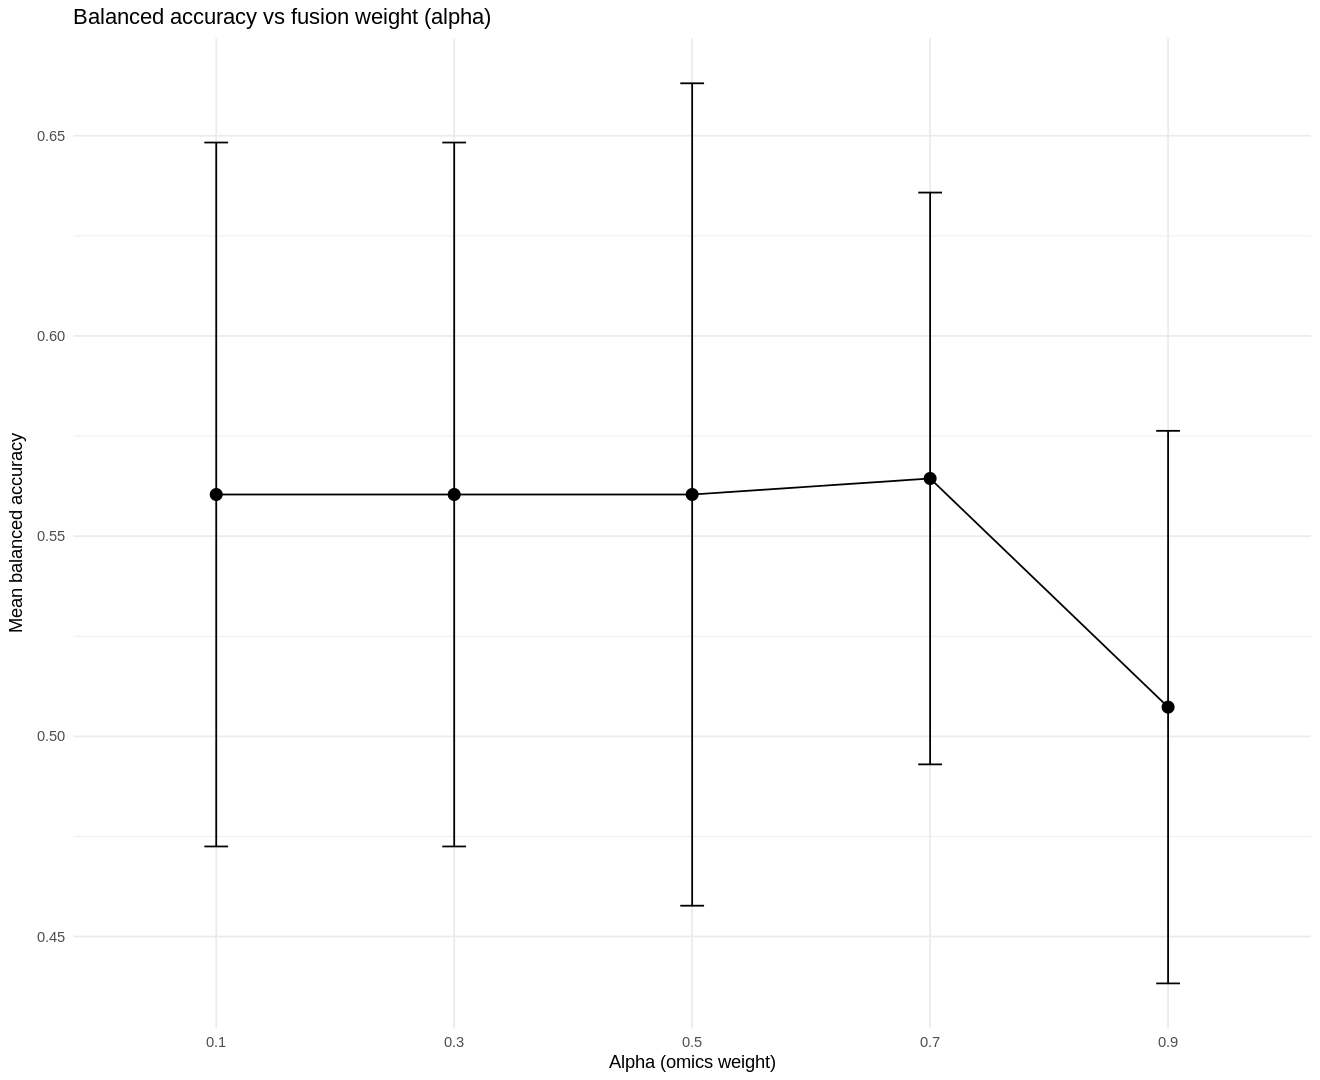

In [ ]:
# ==============================
# Step 5 – Alpha grid search for fused similarity
# ==============================

alpha_list <- c(0.1, 0.3, 0.5, 0.7, 0.9)
results_alpha <- list()

for (a in alpha_list) {
  cat("\n--- Testing alpha =", a, "---\n")

  # Build fused similarity: alpha * omics + (1 - alpha) * clinical
  W_fused_a <- a * W_omics_s + (1 - a) * W_clin_s
  W_fused_a <- W_fused_a / max(W_fused_a, na.rm = TRUE)

  res <- cv_weighted_knn(W_fused_a, y, K = 9, folds = 5)

  results_alpha[[as.character(a)]] <- res
}

# Convert results into a data frame
results_alpha_df <- bind_rows(
  lapply(names(results_alpha), function(a) {
    data.frame(
      alpha     = as.numeric(a),
      mean_acc  = results_alpha[[a]]$mean_acc,
      mean_bacc = results_alpha[[a]]$mean_bacc,
      sd_acc    = results_alpha[[a]]$sd_acc,
      sd_bacc   = results_alpha[[a]]$sd_bacc
    )
  })
)

# Round numeric columns to 4 decimals for readability
results_alpha_df <- results_alpha_df %>%
  mutate(
    mean_acc  = round(mean_acc, 4),
    mean_bacc = round(mean_bacc, 4),
    sd_acc    = round(sd_acc, 4),
    sd_bacc   = round(sd_bacc, 4)
  )

# Show as plain data frame (no kable / no HTML)
results_alpha_df

# Visualize mean balanced accuracy by alpha
ggplot(results_alpha_df, aes(x = factor(alpha), y = mean_bacc, group = 1)) +
  geom_line() +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = mean_bacc - sd_bacc, ymax = mean_bacc + sd_bacc),
                width = 0.1) +
  theme_minimal() +
  labs(
    title = "Balanced accuracy vs fusion weight (alpha)",
    x = "Alpha (omics weight)",
    y = "Mean balanced accuracy"
  )

# Select best alpha (highest mean_bacc)
best_alpha_row <- results_alpha_df %>%
  arrange(desc(mean_bacc)) %>%
  slice(1)

best_alpha <- best_alpha_row$alpha

# Also print best alpha row as data frame
best_alpha_row

cat("\nBest alpha =", best_alpha, "\n")


In [ ]:
# ==============================
# Step 6 – Final performance with best alpha (plain data frames)
# ==============================

# Build fused matrix with best alpha
W_best <- best_alpha * W_omics_s + (1 - best_alpha) * W_clin_s
W_best <- W_best / max(W_best, na.rm = TRUE)

set.seed(123)
n <- length(y)
fold_id <- createFolds(y, k = 5, list = FALSE)

pred_all <- factor(rep(NA, n), levels = levels(y))

for (f in 1:5) {
  test_idx  <- which(fold_id == f)
  train_idx <- setdiff(seq_len(n), test_idx)

  preds <- predict_knn_weighted(W_best, train_idx, test_idx, y[train_idx], K = 9)
  pred_all[test_idx] <- preds
}

cm_final <- confusionMatrix(pred_all, y, positive = "poor")



### OVERALL METRICS (LONG FORMAT, 2 decimals)
overall_long <- data.frame(
  metric = rownames(as.data.frame(cm_final$overall)),
  value  = round(as.numeric(cm_final$overall), 2),
  row.names = NULL
)
overall_long

### BY-CLASS METRICS (LONG FORMAT, 2 decimals)
byclass_long <- data.frame(
  metric = rownames(as.data.frame(cm_final$byClass)),
  value  = round(as.numeric(cm_final$byClass), 2),
  row.names = NULL
)
byclass_long


metric,value
<chr>,<dbl>
Accuracy,0.71
Kappa,0.15
AccuracyLower,0.62
AccuracyUpper,0.78
AccuracyNull,0.73
AccuracyPValue,0.76
McnemarPValue,0.02


metric,value
<chr>,<dbl>
Sensitivity,0.88
Specificity,0.25
Pos Pred Value,0.76
Neg Pred Value,0.43
Precision,0.76
Recall,0.88
F1,0.81
Prevalence,0.73
Detection Rate,0.64


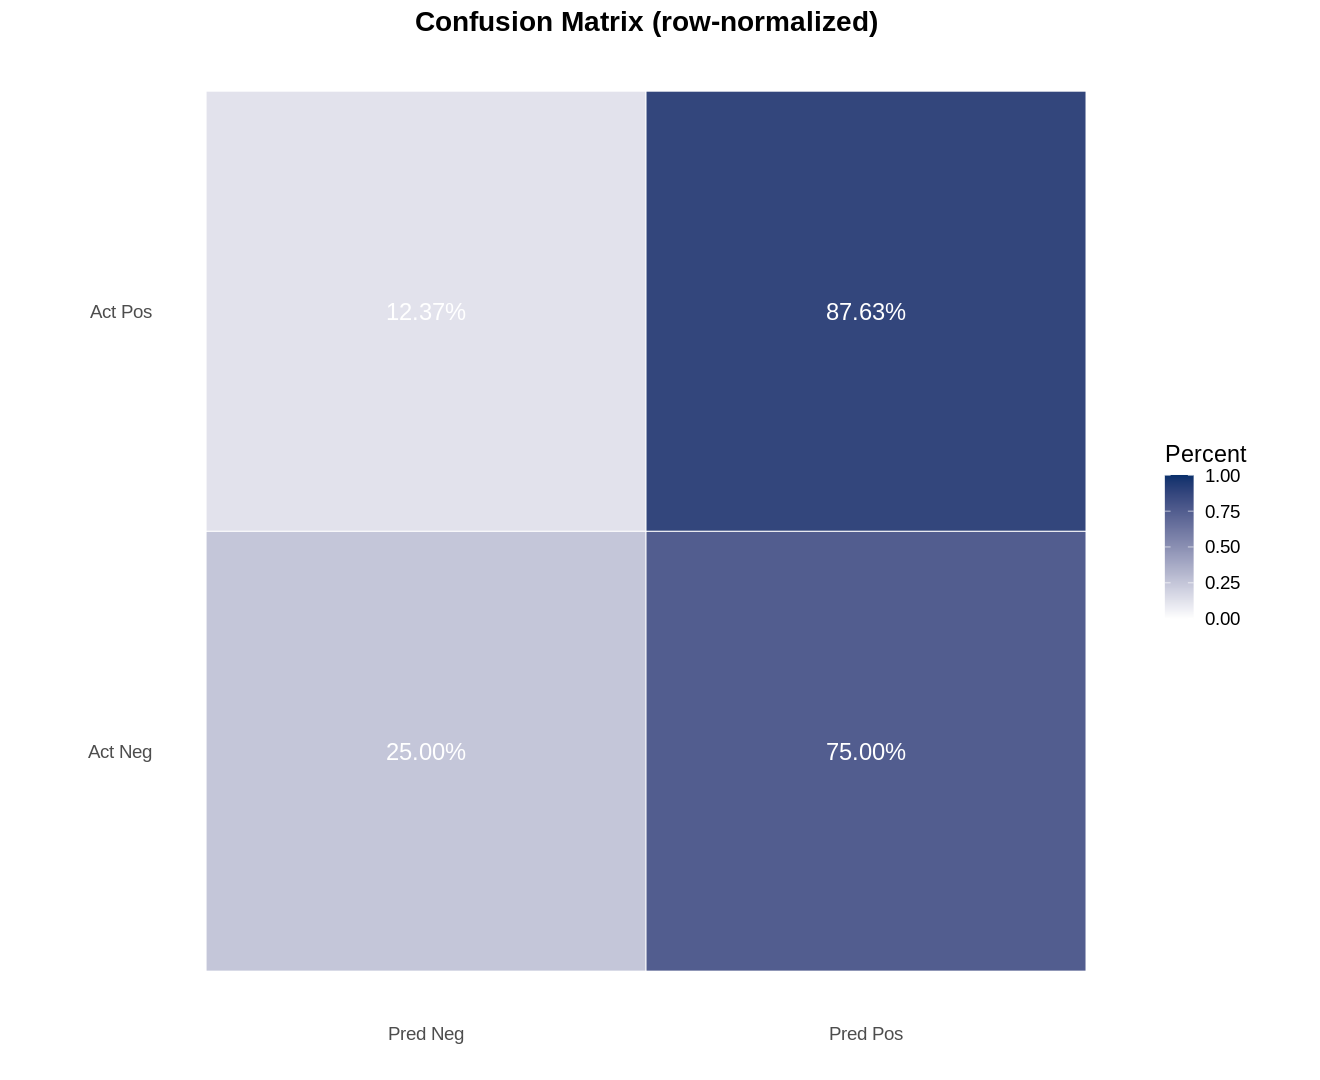

In [ ]:
library(ggplot2)
library(dplyr)
library(scales)

# cm_final is the output of caret::confusionMatrix(...)
cm <- cm_final$table

# Convert to data frame
cm_df <- as.data.frame(cm)
colnames(cm_df) <- c("Predicted", "Actual", "Freq")

# Map your factor levels to Neg/Pos labels
# Here I assume:
#   "good"  = negative class
#   "poor"  = positive class
cm_df <- cm_df %>%
  mutate(
    ActualLabel = ifelse(Actual == "good", "Act Neg", "Act Pos"),
    PredLabel   = ifelse(Predicted == "good", "Pred Neg", "Pred Pos")
  )

# Row-normalize by Actual class (
cm_df <- cm_df %>%
  group_by(ActualLabel) %>%
  mutate(
    Percent = Freq / sum(Freq),
    Label   = percent(Percent, accuracy = 0.01)
  ) %>%
  ungroup()

# Ensure the order on axes: Neg first, then Pos
cm_df$ActualLabel <- factor(cm_df$ActualLabel, levels = c("Act Neg", "Act Pos"))
cm_df$PredLabel   <- factor(cm_df$PredLabel,   levels = c("Pred Neg", "Pred Pos"))

# Plot heatmap
ggplot(cm_df, aes(x = PredLabel, y = ActualLabel, fill = Percent)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Label), size = 5, color = "white") +
  scale_fill_gradient(low = "white", high = "#08306B", limits = c(0, 1)) +
  coord_equal() +
  labs(
    x = "",
    y = "",
    title = "Confusion Matrix (row-normalized)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    panel.grid   = element_blank(),
    axis.text.x  = element_text(angle = 0, vjust = 0.5),
    plot.title   = element_text(hjust = 0.5, face = "bold")
  )


In [ ]:
# Install randomForest (only once)
install.packages("randomForest")

# Load it in every new session
library(randomForest)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(dplyr)
library(forcats)

# -----------------------------
# A1. Strong binary outcome (same logic as before)
# -----------------------------
clin_cluster <- clin_cluster %>%
  mutate(
    surv_binary = case_when(
      vital_status == "Deceased" & follow_up_days <= 400 ~ "poor",
      vital_status == "Living"   & follow_up_days >= 400 ~ "good",
      TRUE ~ NA_character_
    ),
    surv_binary = factor(surv_binary, levels = c("good", "poor"))
  )

df_surv <- clin_cluster %>%
  filter(!is.na(surv_binary))

table(df_surv$surv_binary)   # should be 33 good / 58 poor
nrow(df_surv)

# -----------------------------
# A2. Aggressive recoding of categorical variables
# -----------------------------

df_surv_recoded <- df_surv %>%
  mutate(
    # N stage: N0 vs N+
    pn_group = case_when(
      pn_factor == "N0" ~ "N0",
      pn_factor %in% c("N1", "N2") ~ "Nplus",
      TRUE ~ NA_character_
    ),

    # T stage: T1/2 vs T3/4
    pt_group = case_when(
      pt_factor %in% c("T1", "T2") ~ "T1_2",
      pt_factor %in% c("T3", "T4") ~ "T3_4",
      TRUE ~ NA_character_
    ),

    # M stage (path)
    pm_group = case_when(
      pm_factor == "M0" ~ "M0",
      pm_factor == "M1" ~ "M1",
      TRUE ~ NA_character_
    ),

    # clinical M
    cm_group = case_when(
      cm_factor == "M0" ~ "M0",
      cm_factor == "M1" ~ "M1",
      TRUE ~ NA_character_
    ),

    # Pathological stage: Early (I–II) vs Advanced (III–IV)
    stage_group = case_when(
      tumor_stage_pathological %in% c("Stage IA","Stage IB","Stage IIA","Stage IIB") ~ "Early",
      tumor_stage_pathological %in% c("Stage III","Stage IV") ~ "Advanced",
      TRUE ~ NA_character_
    ),

    # Tumor site: head vs body/tail/multi
    site_group = case_when(
      tumor_site == "head" ~ "Head",
      tumor_site %in% c("body", "tail", "body and tail") ~ "BodyTail",
      TRUE ~ "Other"
    ),

    # Lymph vascular invasion: Present vs Absent/Unknown
    lvi_group = case_when(
      lymph_vascular_invasion == "Present" ~ "Present",
      lymph_vascular_invasion %in% c("Not identified", "Indetermite") ~ "AbsentOrUnknown",
      TRUE ~ "AbsentOrUnknown"
    ),

    # Perineural invasion
    pni_group = case_when(
      perineural_invasion == "Present" ~ "Present",
      perineural_invasion %in% c("Not identified", "Indetermite") ~ "AbsentOrUnknown",
      TRUE ~ "AbsentOrUnknown"
    )
  ) %>%
  mutate(
    pn_group    = factor(pn_group),
    pt_group    = factor(pt_group),
    pm_group    = factor(pm_group),
    cm_group    = factor(cm_group),
    stage_group = factor(stage_group),
    site_group  = factor(site_group),
    lvi_group   = factor(lvi_group),
    pni_group   = factor(pni_group)
  )

# Quick check of new distributions
summary_recoded <- data.frame(
  variable  = c("pn_group","pt_group","pm_group","cm_group",
                "stage_group","site_group","lvi_group","pni_group"),
  n_missing = c(
    sum(is.na(df_surv_recoded$pn_group)),
    sum(is.na(df_surv_recoded$pt_group)),
    sum(is.na(df_surv_recoded$pm_group)),
    sum(is.na(df_surv_recoded$cm_group)),
    sum(is.na(df_surv_recoded$stage_group)),
    sum(is.na(df_surv_recoded$site_group)),
    sum(is.na(df_surv_recoded$lvi_group)),
    sum(is.na(df_surv_recoded$pni_group))
  )
)

summary_recoded



good poor 
  38   48 

[1] 86

variable,n_missing
<chr>,<int>
pn_group,5
pt_group,0
pm_group,29
cm_group,31
stage_group,3
site_group,0
lvi_group,0
pni_group,0


In [ ]:
set.seed(123)

# -----------------------------
# B1. Build modeling data frame
# -----------------------------
model_df <- df_surv_recoded %>%
  select(
    surv_binary,
    age,
    bmi,
    tumor_size_cm,
    pn_group,
    pt_group,
    pm_group,
    cm_group,
    stage_group,
    site_group,
    lvi_group,
    pni_group
  )

# Remove rows with any missing predictor
model_df <- model_df %>%
  filter(complete.cases(.))

table(model_df$surv_binary)
nrow(model_df)

# -----------------------------
# B2. Train/test split (70/30 stratified)
# -----------------------------
library(caret)

set.seed(123)
idx_train <- createDataPartition(model_df$surv_binary, p = 0.7, list = FALSE)

train_data <- model_df[idx_train, ]
test_data  <- model_df[-idx_train, ]

table(train_data$surv_binary)
table(test_data$surv_binary)



good poor 
  20   27 

[1] 47


good poor 
  14   19 


good poor 
   6    8 

In [ ]:
install.packages("themis")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(caret)
library(randomForest)
library(ggplot2)
library(scales)
library(pROC)
library(dplyr)
library(themis)

# Ensure factor levels are consistent and "poor" is positive
train_data$surv_binary <- factor(train_data$surv_binary, levels = c("good","poor"))
test_data$surv_binary  <- factor(test_data$surv_binary,  levels = c("good","poor"))


# -----------------------------------
# TrainControl with SMOTE
# -----------------------------------
ctrl_smote <- trainControl(
  method          = "cv",
  number          = 5,
  classProbs      = TRUE,
  summaryFunction = twoClassSummary,
  sampling        = "smote",   # <-- this activates SMOTE
  savePredictions = "final"
)

set.seed(123)
rf_smote <- train(
  surv_binary ~ .,
  data      = train_data,
  method    = "rf",
  metric    = "ROC",
  trControl = ctrl_smote,
  importance = TRUE
)

rf_smote
rf_smote$results
rf_smote$bestTune




Random Forest 

33 samples
11 predictors
 2 classes: 'good', 'poor' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 26, 26, 27, 27, 26 
Addtional sampling using SMOTE

Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.4375000  0.3333333  0.6500000
   7    0.4388889  0.4666667  0.5833333
  12    0.4055556  0.3333333  0.5833333

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 7.

,mtry,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.4375000,0.3333333,0.6500000,0.3566092,0.2357023,0.2850439
2,7,0.4388889,0.4666667,0.5833333,0.2681671,0.3800585,0.2763854
3,12,0.4055556,0.3333333,0.5833333,0.2418422,0.3333333,0.2124591


,mtry
,<dbl>
2,7


In [ ]:
# -----------------------------
# C2. Test set evaluation
# -----------------------------
pred_class <- predict(rf_smote, newdata = test_data)
pred_prob  <- predict(rf_smote, newdata = test_data, type = "prob")[,"poor"]

cm_rf_smote <- caret::confusionMatrix(
  data      = pred_class,
  reference = test_data$surv_binary,
  positive  = "poor"
)

cm_rf_smote$table          # raw confusion matrix as a table

overall_rf <- data.frame(
  metric = names(cm_rf_smote$overall),
  value  = as.numeric(cm_rf_smote$overall)
)
overall_rf$value <- round(overall_rf$value, 3)
overall_rf

byclass_rf <- data.frame(
  metric = names(cm_rf_smote$byClass),
  value  = as.numeric(cm_rf_smote$byClass)
)
byclass_rf$value <- round(byclass_rf$value, 3)
byclass_rf


          Reference
Prediction good poor
      good    2    3
      poor    4    5

metric,value
<chr>,<dbl>
Accuracy,0.500
Kappa,-0.043
AccuracyLower,0.230
AccuracyUpper,0.770
AccuracyNull,0.571
AccuracyPValue,0.792
McnemarPValue,1.000


metric,value
<chr>,<dbl>
Sensitivity,0.625
Specificity,0.333
Pos Pred Value,0.556
Neg Pred Value,0.400
Precision,0.556
Recall,0.625
F1,0.588
Prevalence,0.571
Detection Rate,0.357


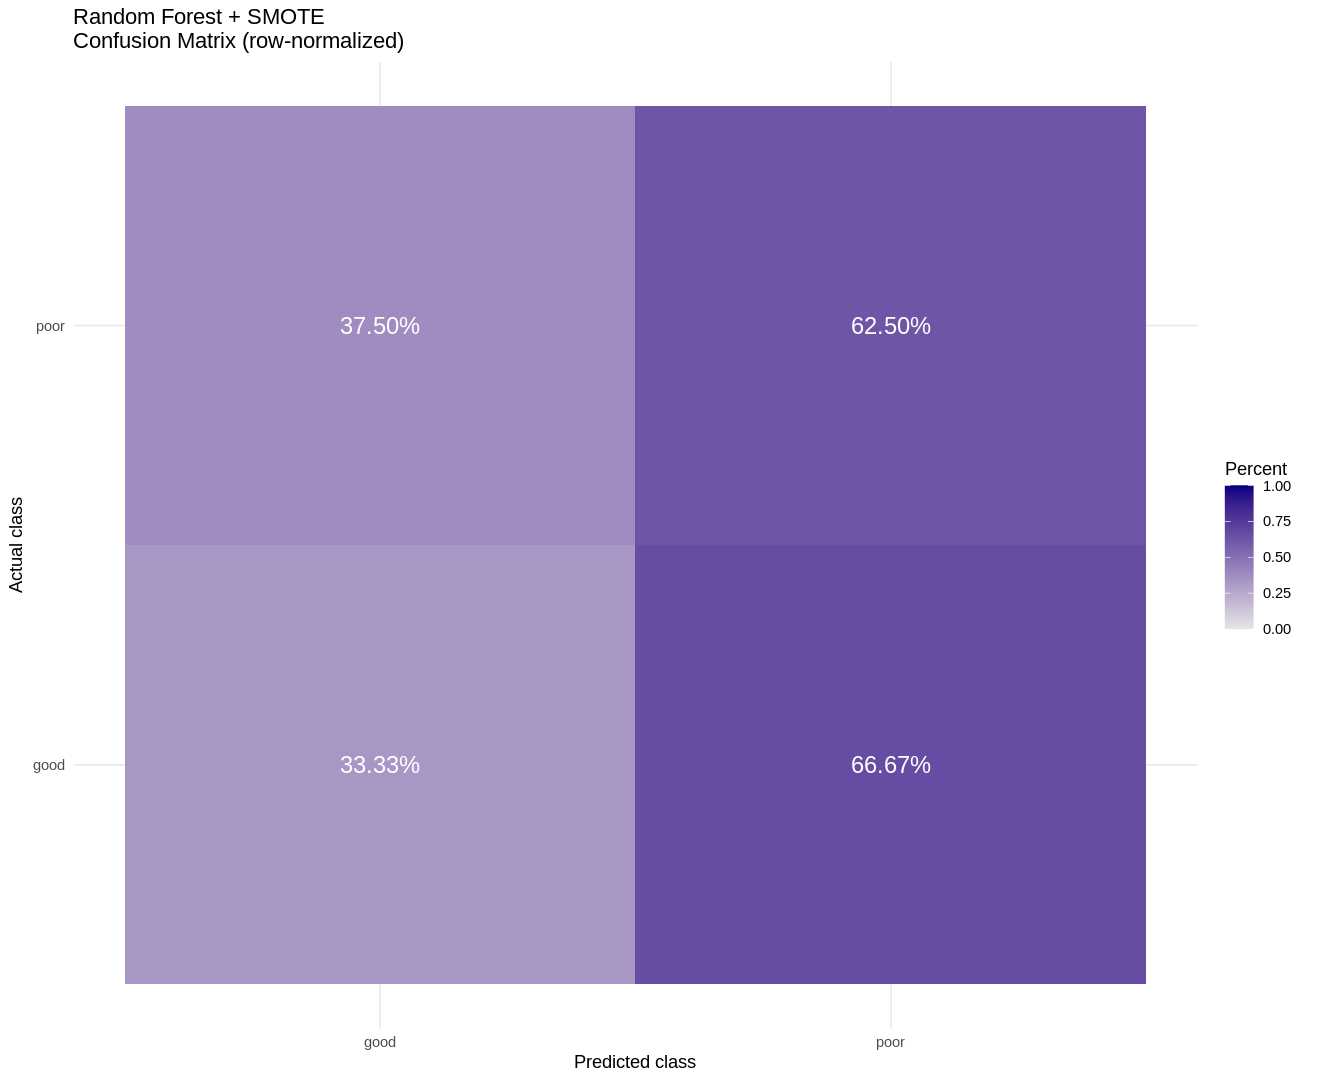

In [ ]:
# -----------------------------
# C3. Confusion matrix heatmap
# -----------------------------
library(ggplot2)
library(scales)

cm_mat <- cm_rf_smote$table
cm_df  <- as.data.frame(cm_mat)

# row-normalize (actual class)
cm_df <- cm_df %>%
  group_by(Reference) %>%
  mutate(Percent = Freq / sum(Freq))

ggplot(cm_df, aes(x = Prediction, y = Reference, fill = Percent)) +
  geom_tile() +
  geom_text(aes(label = percent(Percent, accuracy = 0.01)),
            color = "white", size = 5) +
  scale_fill_gradient(low = "grey90", high = "navy",
                      limits = c(0,1), name = "Percent") +
  theme_minimal() +
  labs(
    title = "Random Forest + SMOTE\nConfusion Matrix (row-normalized)",
    x = "Predicted class",
    y = "Actual class"
  )

Setting direction: controls > cases



Area under the curve: 0.5833

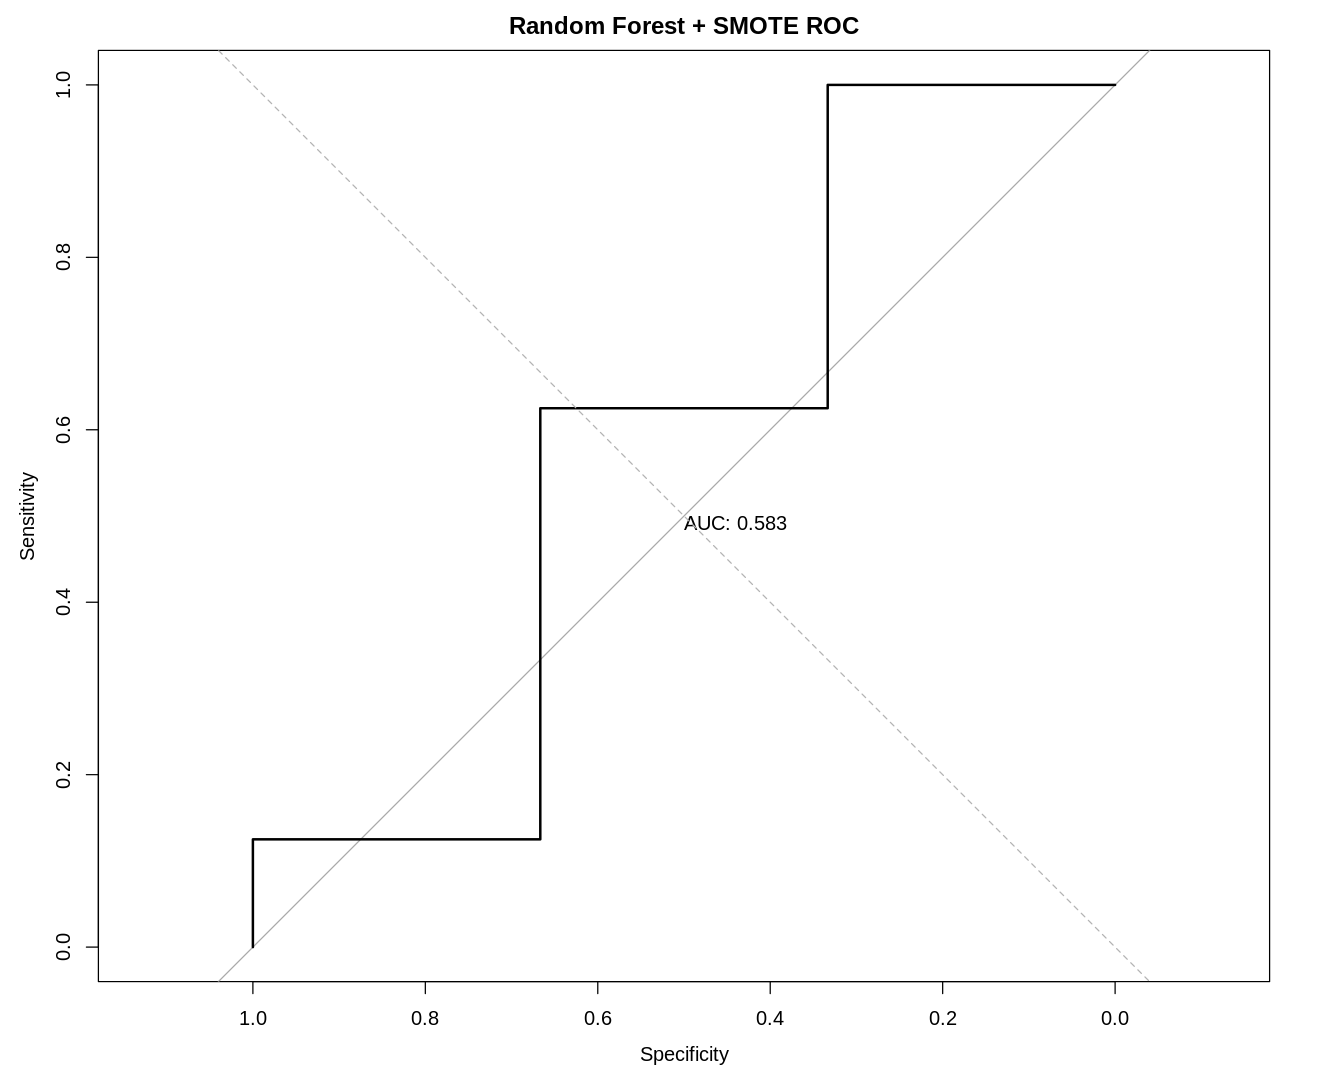

In [ ]:
# -----------------------------
# C4. ROC curve on test set
# -----------------------------
roc_rf <- roc(response = test_data$surv_binary,
              predictor = pred_prob,
              levels   = c("good","poor"))

auc(roc_rf)

plot(roc_rf, print.auc = TRUE, main = "Random Forest + SMOTE ROC")
abline(a = 0, b = 1, lty = 2, col = "grey70")

#LABEL PROPAGATION

In [2]:
install.packages("caret")
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [22]:
# Required Libraries (Assuming they are installed)
library(dplyr)
library(caret)
# library(label.propagation) # The package containing the LP algorithm (given as an example)

# =========================================================
# I. DATA LOADING AND SIMILARITY MATRIX PREPARATION
# =========================================================

# 1. Load the Similarity Matrix (W_omics) from fit_result.rds
fit <- readRDS("fit_result.rds")
W_omics <- fit$W
patient_ids <- rownames(W_omics)
n_patients <- nrow(W_omics)

cat("Total number of patients (from W matrix):", n_patients, "\n")

# 2. KNN Sparsification and Symmetrization (As in your previous code)
# LP typically performs better on a sparse graph.
W_norm <- W_omics / max(W_omics)
K <- 6 # K value used for KNN filtering

W_knn <- matrix(0, nrow = n_patients, ncol = n_patients)
rownames(W_knn) <- rownames(W_norm)
colnames(W_knn) <- colnames(W_norm)

for (i in 1:n_patients) {
  # Get indices of top-K neighbours (excluding self)
  idx <- order(W_norm[i, ], decreasing = TRUE)
  idx <- idx[idx != i][1:K]
  W_knn[i, idx] <- W_norm[i, idx]
}

# Symmetrize the matrix (to create an undirected graph)
W_final <- pmax(W_knn, t(W_knn))

cat("Final Similarity Matrix (W_final) prepared.\n")

# =========================================================
# II. CREATING THE INITIAL LABEL MATRIX (Y0) - FIXED FOR YOUR CSV
# =========================================================

clin <- read.csv("clin_cluster.csv", stringsAsFactors = FALSE, check.names = FALSE)
clin$case_id <- as.character(clin$case_id)

# Align the clinical data order with the W matrix order
m <- match(patient_ids, clin$case_id)
if (any(is.na(m))) {
  missing_ids <- patient_ids[is.na(m)]
  stop("These patient_ids are missing in clin_cluster.csv (case_id):\n",
       paste(missing_ids, collapse = ", "))
}
clin <- clin[m, ]
stopifnot(all(clin$case_id == patient_ids))

# ---- Create surv_binary because your file doesn't have it ----
# Rule:
#   - If lost to follow up OR follow_up_days is NA -> unlabeled (NA)
#   - Else: good if follow_up_days >= cutoff_days, poor otherwise
cutoff_days <- 400

clin$is_this_patient_lost_to_follow_up <- as.character(clin$is_this_patient_lost_to_follow_up)
clin$vital_status <- as.character(clin$vital_status)

clin$surv_binary <- NA_character_
valid_idx <- !is.na(clin$follow_up_days) & (clin$is_this_patient_lost_to_follow_up != "Yes")

clin$surv_binary[valid_idx] <- ifelse(clin$follow_up_days[valid_idx] >= cutoff_days, "good", "poor")
clin$surv_binary <- tolower(trimws(clin$surv_binary))

# Labels
y_label <- clin$surv_binary
levels_y <- c("good", "poor")
n_classes <- length(levels_y)

# Initial label matrix Y0 (N x C)
Y0 <- matrix(0, nrow = n_patients, ncol = n_classes)
colnames(Y0) <- levels_y
rownames(Y0) <- patient_ids

for (i in 1:n_patients) {
  if (is.na(y_label[i])) next
  if (y_label[i] %in% levels_y) Y0[i, y_label[i]] <- 1
}

n_labeled <- sum(rowSums(Y0) > 0)
n_unlabeled <- sum(rowSums(Y0) == 0)

cat("Number of labeled patients (LP seeds):", n_labeled, "\n")
cat("Number of unlabeled patients (To be predicted):", n_unlabeled, "\n")
print(table(y_label, useNA = "ifany"))


# =========================================================
# III. LABEL PROPAGATION IMPLEMENTATION (LP)
# =========================================================

# This part implements the LP algorithm using the iterative formula.

# 1. Calculate the Transition Matrix (P)
# P = D^(-1) * W, where D is the diagonal degree matrix.
D_inv <- diag(1 / rowSums(W_final)) # Inverse of the degree matrix
P <- D_inv %*% W_final             # Transition Matrix P

# 2. Iterative LP Formula
# Y_star will hold the final label probabilities
Y_star <- Y0
alpha <- 0.9  # Propagation coefficient (between 0 and 1)
max_iter <- 100
tol <- 1e-4

# Iteration Loop
for (iter in 1:max_iter) {
  Y_prev <- Y_star
  # LP Formula: Y(t+1) = (1 - alpha) * Y0 + alpha * P * Y(t)
  # This spreads the labels across the graph
  Y_star <- (1 - alpha) * Y0 + alpha * (P %*% Y_star)

  # Check for convergence (labels stabilizing)
  if (all(abs(Y_star - Y_prev) < tol)) {
    cat(paste("LP iteration converged at step", iter, ".\n"))
    break
  }
}
#

# =========================================================
# IV. EVALUATION OF RESULTS
# =========================================================

# Final label predictions (probability of belonging to each class)
preds_lp_prob <- Y_star

# Assign class based on the highest probability
preds_lp_class <- factor(
  colnames(Y_star)[apply(Y_star, 1, which.max)],
  levels = levels_y
)

cat("\nLP Prediction Results:\n")

# A. Examine predicted labels for unlabeled patients
unlabeled_preds <- preds_lp_class[rowSums(Y0) == 0]
cat("Prediction distribution for unlabeled patients:\n")
print(table(unlabeled_preds))

# B. Evaluate performance on the initially labeled patients (self-consistency check)
labeled_idx <- which(rowSums(Y0) > 0)

# Make sure BOTH are factors with identical levels
pred_eval <- factor(preds_lp_class[labeled_idx], levels = levels_y)
ref_eval  <- factor(y_label[labeled_idx],         levels = levels_y)

cm_lp <- confusionMatrix(
  data = pred_eval,
  reference = ref_eval,
  positive = "poor"
)

cat("\nPerformance Metrics on Labeled Patients (Self-Consistency):\n")
print(cm_lp$overall["Balanced Accuracy"])
print(cm_lp$table)


# Optional: You can now save or use preds_lp_class for further analysis.

Total number of patients (from W matrix): 137 
Final Similarity Matrix (W_final) prepared.
Number of labeled patients (LP seeds): 88 
Number of unlabeled patients (To be predicted): 49 
y_label
good poor <NA> 
  45   43   49 
LP iteration converged at step 26 .

LP Prediction Results:
Prediction distribution for unlabeled patients:
unlabeled_preds
good poor 
  31   18 

Performance Metrics on Labeled Patients (Self-Consistency):
<NA> 
  NA 
          Reference
Prediction good poor
      good   41    4
      poor    4   39


In [23]:
tab <- table(Prediction = pred_eval, Reference = ref_eval)

TP <- tab["poor","poor"]
TN <- tab["good","good"]
FP <- tab["poor","good"]
FN <- tab["good","poor"]

sens <- TP / (TP + FN)          # sensitivity for 'poor'
spec <- TN / (TN + FP)          # specificity for 'poor'
bal_acc <- (sens + spec) / 2

cat("Sensitivity (poor):", sens, "\n")
cat("Specificity (poor):", spec, "\n")
cat("Balanced Accuracy:", bal_acc, "\n")


Sensitivity (poor): 0.9069767 
Specificity (poor): 0.9111111 
Balanced Accuracy: 0.9090439 


In [13]:
install.packages("PRROC", repos = "https://cloud.r-project.org")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [14]:
library(pROC)
library(PRROC)


Loading required package: rlang



# A tibble: 7 × 2
  metric            value
  <chr>             <dbl>
1 Accuracy       9.09e- 1
2 Kappa          8.18e- 1
3 AccuracyLower  8.29e- 1
4 AccuracyUpper  9.60e- 1
5 AccuracyNull   5.11e- 1
6 AccuracyPValue 1.16e-15
7 McnemarPValue  1   e+ 0
# A tibble: 11 × 2
   metric               value
   <chr>                <dbl>
 1 Sensitivity          0.907
 2 Specificity          0.911
 3 Pos Pred Value       0.907
 4 Neg Pred Value       0.911
 5 Precision            0.907
 6 Recall               0.907
 7 F1                   0.907
 8 Prevalence           0.489
 9 Detection Rate       0.443
10 Detection Prevalence 0.489
11 Balanced Accuracy    0.909


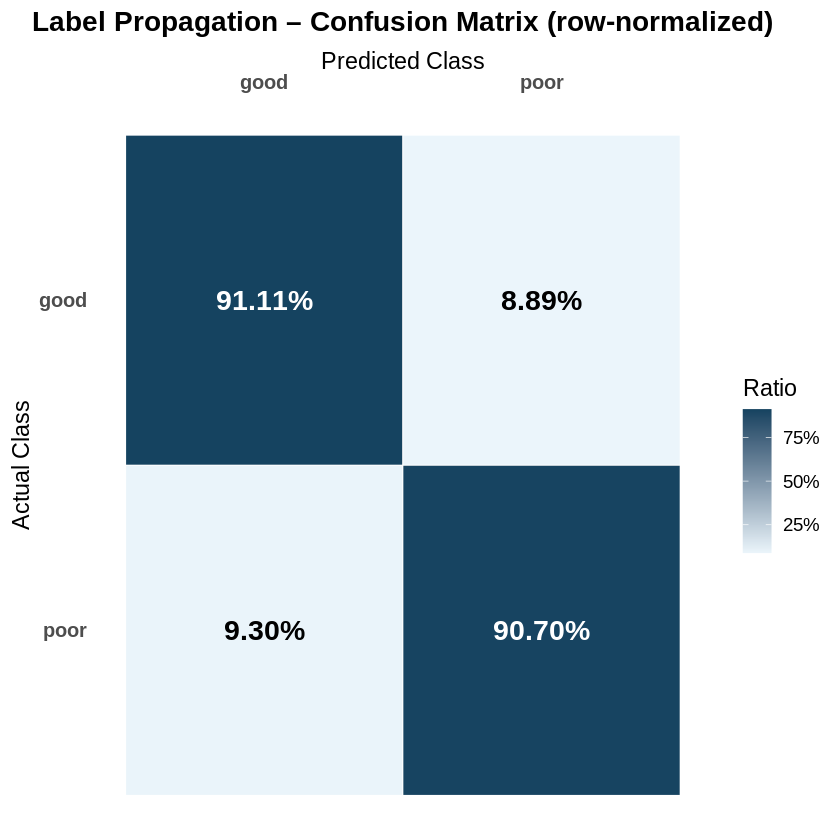

In [28]:
library(ggplot2)
library(tibble)
library(dplyr)

# 1. Define Levels and Positive Class
# It is crucial to convert vectors to factors with specific levels
# to ensure 'table()' does not sort them alphabetically by mistake.
levels_y <- c("good", "poor")
positive <- "poor"

# Ensure inputs are factors with the fixed order
ref_eval  <- factor(ref_eval, levels = levels_y)
pred_eval <- factor(pred_eval, levels = levels_y)

# 2. Generate Confusion Matrix Counts
cm_counts <- table(Prediction = pred_eval, Reference = ref_eval)

# 3. Prepare Data Frame for Plotting (Row-Normalized)
cm_df <- as.data.frame(cm_counts) %>%
  rename(pred = Prediction, actual = Reference, n = Freq) %>%
  group_by(actual) %>%
  mutate(total = sum(n)) %>%              # Calculate total per actual class
  mutate(p = ifelse(total == 0, 0, n / total)) %>% # Calculate percentage
  ungroup() %>%
  mutate(label = sprintf("%.2f%%", 100 * p)) %>%
  # Define text color: White for dark backgrounds (p > 0.5), Black for light
  mutate(text_color = ifelse(p > 0.5, "white", "black"))

# 4. Plot with ggplot2
ggplot(cm_df, aes(x = pred, y = actual, fill = p)) +
  geom_tile(color = "white") +  # Add white borders for clarity
  geom_text(aes(label = label, color = text_color), size = 6, fontface = "bold") +
  scale_fill_gradient(low = "#ebf5fb", high = "#154360", labels = scales::percent) +
  scale_color_identity() +      # Use the actual color names from 'text_color' column
  scale_y_discrete(limits = rev(levels_y)) + # Reverse Y axis to put the first class at the top
  scale_x_discrete(position = "top") +       # Move X axis labels to the top
  labs(
    title = "Label Propagation – Confusion Matrix (row-normalized)",
    x = "Predicted Class",
    y = "Actual Class",
    fill = "Ratio"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 12, face = "bold"),
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

# ---- Metrics Calculation ----

# Extract values using the specific names to ensure accuracy
TP <- cm_counts[positive, positive]
TN <- cm_counts["good", "good"]
FP <- cm_counts[positive, "good"]
FN <- cm_counts["good", positive]
N  <- sum(cm_counts)

# Calculate Accuracy
acc <- (TP + TN) / N

# Confidence Interval for Accuracy
bt <- binom.test(TP + TN, N)
acc_lower <- unname(bt$conf.int[1])
acc_upper <- unname(bt$conf.int[2])

# No Information Rate (AccuracyNull)
acc_null <- max(prop.table(table(ref_eval)))
acc_p <- unname(binom.test(TP + TN, N, p = acc_null, alternative = "greater")$p.value)

# Kappa Score
po <- acc
pe <- sum(prop.table(table(pred_eval)) * prop.table(table(ref_eval)))
kappa <- ifelse(1 - pe == 0, NA_real_, (po - pe) / (1 - pe))

# McNemar's Test
mcn_p <- tryCatch(mcnemar.test(cm_counts)$p.value, error = function(e) NA_real_)

# Class-Specific Metrics
sens <- TP / (TP + FN)  # Sensitivity (Recall for Positive Class)
spec <- TN / (TN + FP)  # Specificity (Recall for Negative Class)
ppv  <- TP / (TP + FP)  # Precision (Positive Predictive Value)
npv  <- TN / (TN + FN)  # Negative Predictive Value
f1   <- ifelse((ppv + sens) == 0, NA_real_, 2 * ppv * sens / (ppv + sens))
prev <- (TP + FN) / N
det_rate <- TP / N
det_prev <- (TP + FP) / N
bal_acc <- (sens + spec) / 2

# Compile Overall Metrics
overall_df <- tibble(
  metric = c("Accuracy", "Kappa", "AccuracyLower", "AccuracyUpper",
             "AccuracyNull", "AccuracyPValue", "McnemarPValue"),
  value  = c(acc, kappa, acc_lower, acc_upper, acc_null, acc_p, mcn_p)
)

# Compile Class Metrics
byclass_df <- tibble(
  metric = c("Sensitivity", "Specificity", "Pos Pred Value", "Neg Pred Value",
             "Precision", "Recall", "F1", "Prevalence",
             "Detection Rate", "Detection Prevalence", "Balanced Accuracy"),
  value  = c(sens, spec, ppv, npv, ppv, sens, f1, prev, det_rate, det_prev, bal_acc)
)

# Display Results
print(overall_df)
print(byclass_df)

[1] 0.972093

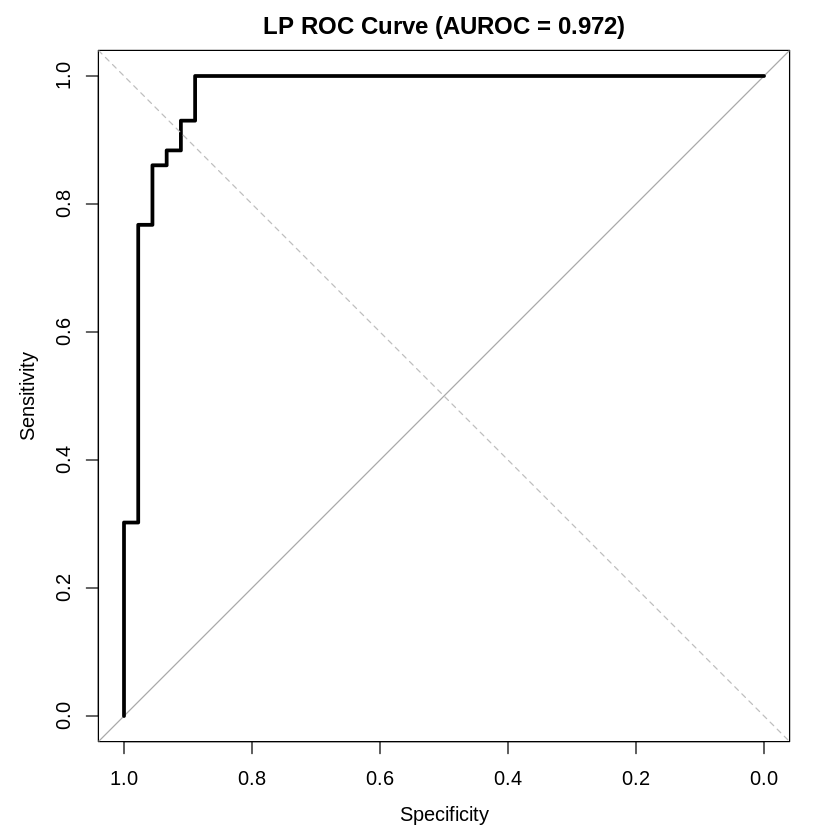

In [25]:
library(pROC)

y_prob_poor <- as.numeric(preds_lp_prob[labeled_idx, "poor"])  # score
y_true <- ref_eval  # factor good/poor

roc_obj <- roc(response = y_true, predictor = y_prob_poor,
               levels = c("good","poor"), direction = "<")

auc_roc <- as.numeric(auc(roc_obj))
auc_roc

plot(roc_obj, lwd = 3,
     main = paste0("LP ROC Curve (AUROC = ", round(auc_roc, 3), ")"))
abline(a = 0, b = 1, lty = 2, col = "gray")


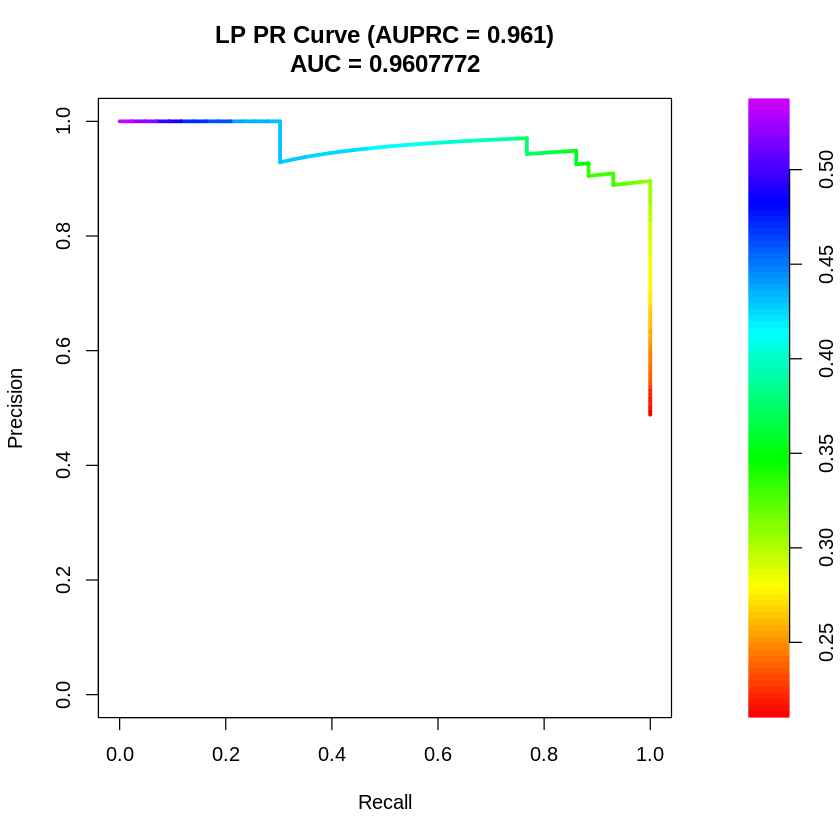

In [26]:
if (requireNamespace("PRROC", quietly = TRUE)) {
  library(PRROC)

  y_bin <- ifelse(y_true == "poor", 1, 0)

  pr_obj <- pr.curve(
    scores.class0 = y_prob_poor[y_bin == 1],  # positives
    scores.class1 = y_prob_poor[y_bin == 0],  # negatives
    curve = TRUE
  )

  auprc <- pr_obj$auc.integral
  auprc

  plot(pr_obj, main = paste0("LP PR Curve (AUPRC = ", round(auprc, 3), ")"))

} else {
  # 3B) PRROC yoksa: yardstick ile AUPRC + PR curve data
  install.packages("yardstick", repos = "https://cloud.r-project.org")
  library(yardstick)

  df_eval <- data.frame(truth = y_true, prob_poor = y_prob_poor)

  auprc <- pr_auc(df_eval, truth = truth, prob_poor, event_level = "second")$.estimate
  auprc

  # Curve points (threshold sweep)
  pr_curve_df <- pr_curve(df_eval, truth = truth, prob_poor, event_level = "second")

  ggplot(pr_curve_df, aes(x = recall, y = precision)) +
    geom_line(linewidth = 1.2) +
    theme_minimal(base_size = 14) +
    labs(title = paste0("LP PR Curve (AUPRC = ", round(auprc, 3), ")"),
         x = "Recall", y = "Precision")
}


In [31]:
# Assuming the LP code has been executed and the following variables are available:
# 1. clin (the aligned clinical data frame, which must contain the 'cluster_knn' column)
# 2. preds_lp_class (the LP predicted labels for all 137 patients)

# =========================================================
# V. COMPARISON OF LP PREDICTIONS WITH CLUSTERING RESULTS
# =========================================================

# 1. Prepare Vectors for Comparison

# Extract the Louvain (KNN) cluster assignments
cluster_labels <- clin$cluster_knn
# Extract the LP predicted survival labels
lp_predictions <- preds_lp_class

# 2. Create the Cross-Tabulation

# Create a table showing the distribution of LP predictions across each cluster ID (rows)
comparison_table <- table(
  Cluster = cluster_labels,
  LP_Prediction = lp_predictions
)

# 3. Calculate Percentage Distribution (Row-wise)

# Calculate the percentage distribution within each cluster (row margin)
percentage_table <- prop.table(comparison_table, margin = 1) * 100

# 4. Interpret Key Clusters (For Log/Final Output)

# Analyze the 'poor' prediction percentage for each cluster to assess risk profile
cat("==================================================\n")
cat("CLINICAL RISK ASSESSMENT BASED ON OMIICS CLUSTERS\n")
cat("==================================================\n")

# Check and report the percentage of 'poor' outcome for each cluster
for (cluster_id in rownames(percentage_table)) {

  # Check if the 'poor' column exists for safety
  if ("poor" %in% colnames(percentage_table)) {
    poor_percent <- percentage_table[cluster_id, "poor"]

    cat(paste0("Cluster ", cluster_id, ": ", round(poor_percent, 1),
               "% of patients were predicted as 'poor' outcome (High Risk).\n"))

    # Simple interpretation based on risk level
    if (poor_percent >= 80) {
      cat("  -> INTERPRETATION: High confidence 'Poor' (High Risk) Subtype.\n")
    } else if (poor_percent <= 20) {
      cat("  -> INTERPRETATION: High confidence 'Good' (Low Risk) Subtype.\n")
    } else {
      cat("  -> INTERPRETATION: Mixed/Intermediate Risk Subtype.\n")
    }
  }
}

cat("==================================================\n")

# Store the final table for further analysis (e.g., Kaplan-Meier)
# This step is essential if you want to use the percentage data later.
# Instead of printing, we save it as a data frame.
df_percentage_analysis <- as.data.frame(percentage_table)

CLINICAL RISK ASSESSMENT BASED ON OMIICS CLUSTERS
Cluster 1: 36% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: Mixed/Intermediate Risk Subtype.
Cluster 2: 11.8% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: High confidence 'Good' (Low Risk) Subtype.
Cluster 3: 81% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: High confidence 'Poor' (High Risk) Subtype.
Cluster 4: 62.5% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: Mixed/Intermediate Risk Subtype.
Cluster 5: 17.6% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: High confidence 'Good' (Low Risk) Subtype.
Cluster 6: 100% of patients were predicted as 'poor' outcome (High Risk).
  -> INTERPRETATION: High confidence 'Poor' (High Risk) Subtype.


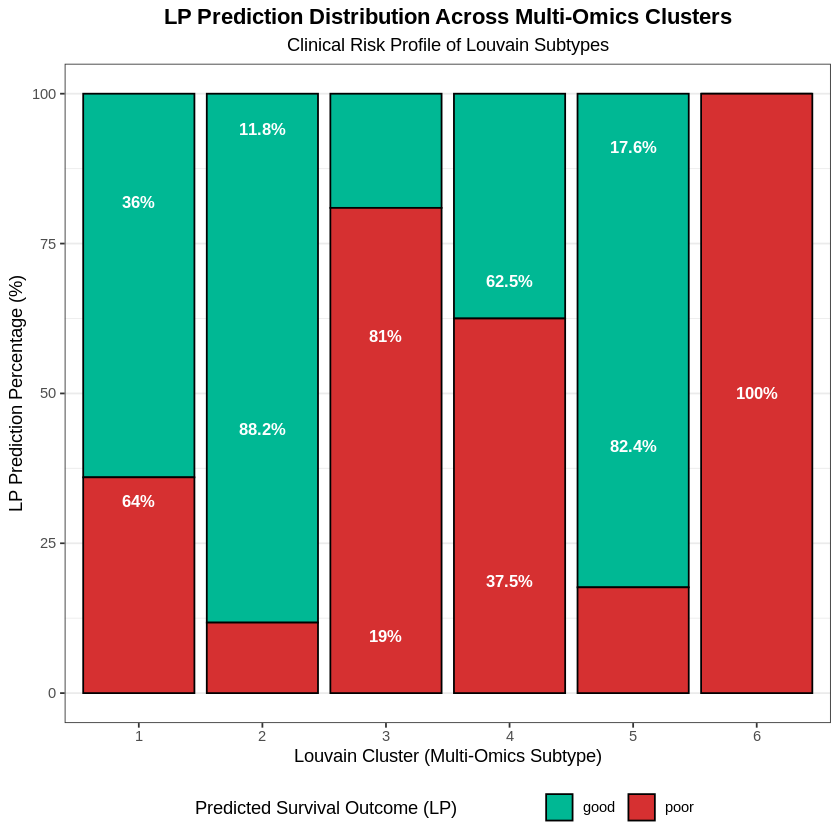

In [35]:
# Required Libraries
library(ggplot2)
library(dplyr) # Required for data manipulation (mutate, group_by)

# =========================================================
# VI. VISUALIZATION OF CROSS-ANALYSIS (Stacked Bar Plot)
# =========================================================

# 1. Data Preparation (Assuming comparison_table is available)
# Convert the raw count table into a data frame
df_comp <- as.data.frame(comparison_table)
colnames(df_comp) <- c("Cluster", "LP_Prediction", "Count")

# Ensure Cluster IDs are treated as factors in their proper order
df_comp$Cluster <- factor(df_comp$Cluster, levels = unique(df_comp$Cluster))

# Calculate percentage distribution within each cluster (row-wise)
df_comp_percent <- df_comp %>%
  group_by(Cluster) %>%
  mutate(
    Percentage = Count / sum(Count) * 100,
    # Calculate the position for centering percentage labels
    Label_Y = cumsum(Percentage) - (Percentage / 2)
  ) %>%
  ungroup()

# Define Vibrant Red and Green Palette
vibrant_colors <- c(
    "good" = "#00B894",  # Vibrant Teal/Emerald Green (High Saturation)
    "poor" = "#D63031"   # Vibrant Scarlet Red (High Saturation)
)

# 2. Visualization (Stacked Bar Plot)
plot_cross_tab <- ggplot(df_comp_percent, aes(x = Cluster, y = Percentage, fill = LP_Prediction)) +

  # Create Stacked Bars
  geom_bar(stat = "identity", position = "stack", color = "black", linewidth = 0.5) +

  # Add Percentage Labels to Bars
  geom_text(aes(y = Label_Y,
                # Only show labels larger than 5% for clarity
                label = ifelse(Percentage > 5, paste0(round(Percentage, 1), "%"), "")),
            # Use white text for better contrast on vibrant dark colors
            color = "white",
            size = 3.5,
            fontface = "bold") +

  # Set Vibrant Color Palette
  scale_fill_manual(values = vibrant_colors,
                    name = "Predicted Survival Outcome (LP)") +

  # Set Title and Axis Labels
  labs(
    title = "LP Prediction Distribution Across Multi-Omics Clusters",
    subtitle = "Clinical Risk Profile of Louvain Subtypes",
    x = "Louvain Cluster (Multi-Omics Subtype)",
    y = "LP Prediction Percentage (%)"
  ) +

  # Apply Scientific Theme Settings
  theme_bw() + # Clean white background theme
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.text.x = element_text(angle = 0, hjust = 0.5),
    legend.position = "bottom", # Position the legend at the bottom
    panel.grid.major.x = element_blank() # Remove vertical grid lines for a cleaner look
  )

# Display the plot
print(plot_cross_tab)